# Imports

In [34]:
!pip install transformers

   ---------------------------------------- 0.0/10.4 MB ? eta -:--:--
   - -------------------------------------- 0.3/10.4 MB ? eta -:--:--
   ---------------- ----------------------- 4.2/10.4 MB 15.7 MB/s eta 0:00:01
   ---------------------------------------- 10.4/10.4 MB 24.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
   ---------------------------------------- 2.4/2.4 MB 46.2 MB/s eta 0:00:00

   -------- ------------------------------- 1/5 [pyyaml]
   ---------------- ----------------------- 2/5 [huggingface-hub]
   ---------------- ----------------------- 2/5 [huggingface-hub]
   ---------------- ----------------------- 2/5 [huggingface-hub]
   ---------------- ----------------------- 2/5 [huggingface-hub]
   ---------------- ----------------------- 2/5 [huggingface-hub]
   ---------------- ----------------------- 2/5 [huggingface-hub]
   ---------------- ----------------------- 2/5 [huggingface-hub]
   ---------------- -----------------

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import json
from datetime import datetime
import ast
import time
import nltk
import logging
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from tqdm import tqdm
import torch
import os
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch.nn.functional as F
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
# Set the aesthetic style
plt.style.use('ggplot')
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to C:\Users\Shahaf/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shahaf/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Shahaf/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Data Analysis

In [74]:
# Part 1: Data Loading and Exploration
# ===================================

def load_data(posts_file, comments_file):
    """
    Load the Reddit posts and comments data
    """
    print("Loading data files...")
    posts_df = pd.read_csv(posts_file)
    comments_df = pd.read_csv(comments_file)
    
    print(f"Loaded {len(posts_df)} posts and {len(comments_df)} comments")
    return posts_df, comments_df

# Load the data
posts_df, comments_df = load_data('merged_posts.csv', 'merged_comments.csv')
# Get all unique subreddit values



Loading data files...
Loaded 150505 posts and 3561862 comments


## Filter Non trump related 

In [81]:
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import spacy

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Load spaCy model
try:
    nlp = spacy.load("en_core_web_sm")
except:
    # If model not installed, provide instructions
    print("Please install spaCy model with: python -m spacy download en_core_web_sm")
    nlp = None

def load_data(posts_file, comments_file):
    """
    Load posts and comments data from CSV files
    """
    posts_df = pd.read_csv(posts_file)
    comments_df = pd.read_csv(comments_file)
    
    print(f"Loaded {len(posts_df)} posts and {len(comments_df)} comments")
    print("Posts columns:", posts_df.columns.tolist())
    print("Comments columns:", comments_df.columns.tolist())
    
    return posts_df, comments_df

def is_trump_related(text, threshold=0.6):
    """
    Determine if text is related to Trump using multiple methods
    
    Args:
        text: The text to analyze
        threshold: Confidence threshold for classification
    
    Returns:
        Boolean indicating if text is Trump-related
    """
    if pd.isna(text) or not isinstance(text, str):
        return False
    
    # Convert to lowercase for case-insensitive matching
    text_lower = text.lower()
    
    # Method 1: Direct keyword matching
    trump_keywords = [
        'trump', 'donald trump', 'president trump', 'donald j trump', 
        'donald j. trump', 'potus', 'former president', '45th president',
        'the donald', 'djt', 'maga', 'make america great again', 'trump2024',
        'trumpism', 'trumpian', 'trump administration'
    ]
    
    # Check for direct matches
    for keyword in trump_keywords:
        # Use word boundary to avoid partial matches (e.g., "trumpet" shouldn't match "trump")
        pattern = r'\b' + re.escape(keyword) + r'\b'
        if re.search(pattern, text_lower):
            return True
    
    # Method 2: Context analysis using spaCy (if available)
    if nlp:
        doc = nlp(text)
        
        # Check for Trump as a named entity
        for ent in doc.ents:
            if ent.label_ in ['PERSON', 'ORG'] and 'trump' in ent.text.lower():
                return True
        
        # Check for Trump in noun chunks (e.g., "Trump supporters")
        for chunk in doc.noun_chunks:
            if 'trump' in chunk.text.lower():
                return True
    
    # Method 3: Co-occurrence with related terms
    trump_related_terms = [
        'ivanka', 'melania', 'barron', 'eric trump', 'don jr', 'donald jr',
        'trump tower', 'mar-a-lago', 'mar a lago', 'trump organization', 
        'trump university', 'trump hotels', 'trump international'
    ]
    
    # For this method, we only need one match
    for term in trump_related_terms:
        pattern = r'\b' + re.escape(term) + r'\b'
        if re.search(pattern, text_lower):
            return True
            
    # Method 4: Check for pronouns near Trump mentions
    # This helps catch continued discussions about Trump after his name is mentioned
    if 'trump' in text_lower:
        # If we find pronouns like "he", "his", "him" after Trump is mentioned,
        # subsequent sentences likely continue discussing Trump
        pronouns = ['he ', 'his ', 'him ', 'himself ', 'the president ']
        for pronoun in pronouns:
            if pronoun in text_lower:
                return True
    
    return False

def filter_trump_related_content(df, text_column):
    """
    Filter dataframe to only include Trump-related content
    
    Args:
        df: DataFrame containing posts or comments
        text_column: Column name containing the text to analyze
    
    Returns:
        Filtered DataFrame with only Trump-related content
    """
    # Ensure the text column exists
    if text_column not in df.columns:
        raise ValueError(f"Column '{text_column}' not found in DataFrame. Available columns: {df.columns.tolist()}")
    
    # Create a new column indicating if the content is Trump-related
    df['is_trump_related'] = df[text_column].apply(is_trump_related)
    
    # Filter to only Trump-related content
    trump_related_df = df[df['is_trump_related']]
    
    print(f"Found {len(trump_related_df)} Trump-related items out of {len(df)} total items")
    return trump_related_df

def analyze_trump_sentiment(posts_df, comments_df, posts_text_column, comments_text_column):
    """
    Main function to analyze Trump-related content from subreddits
    """
    # Filter posts and comments to only include Trump-related content
    trump_posts_df = filter_trump_related_content(posts_df, posts_text_column)
    trump_comments_df = filter_trump_related_content(comments_df, comments_text_column)
    
    # Save filtered data to new CSV files
    trump_posts_df.to_csv('trump_related_posts.csv', index=False)
    trump_comments_df.to_csv('trump_related_comments.csv', index=False)
    
    print(f"Saved {len(trump_posts_df)} Trump-related posts to 'trump_related_posts.csv'")
    print(f"Saved {len(trump_comments_df)} Trump-related comments to 'trump_related_comments.csv'")
    
    # Return the filtered DataFrames for further analysis
    return trump_posts_df, trump_comments_df


Please install spaCy model with: python -m spacy download en_core_web_sm


[nltk_data] Downloading package punkt to C:\Users\Shahaf/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shahaf/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [82]:
# trump_posts_df, trump_comments_df, subreddit_distribution = filter_and_save_data_from_df(posts_df, comments_df, output_prefix='trump_')
try:
    posts_text_column = 'title'  # or 'selftext' or both combined
    comments_text_column = 'body'  # typical column name for Reddit comments
    # Option: Combine title and selftext for posts if both exist
    if 'title' in posts_df.columns and 'selftext' in posts_df.columns:
        posts_df['full_text'] = posts_df['title'] + ' ' + posts_df['selftext'].fillna('')
        posts_text_column = 'full_text'
    
    # Filter and analyze
    trump_posts_df, trump_comments_df = analyze_trump_sentiment(
        posts_df, comments_df, posts_text_column, comments_text_column
    )
    
    print("Filtering complete. You can now proceed with sentiment analysis on the filtered data.")
except Exception as e:
    print(f"Error: {str(e)}")

Found 36111 Trump-related items out of 36111 total items
Found 160987 Trump-related items out of 1440681 total items
Saved 36111 Trump-related posts to 'trump_related_posts.csv'
Saved 160987 Trump-related comments to 'trump_related_comments.csv'
Filtering complete. You can now proceed with sentiment analysis on the filtered data.


In [85]:
posts_df, comments_df = trump_posts_df, trump_comments_df


===== Exploring Posts DataFrame =====
Shape: (36111, 137)

Column names:
['_meta', 'all_awardings', 'allow_live_comments', 'approved_at_utc', 'approved_by', 'archived', 'author', 'author_flair_background_color', 'author_flair_css_class', 'author_flair_richtext', 'author_flair_template_id', 'author_flair_text', 'author_flair_text_color', 'author_flair_type', 'author_fullname', 'author_is_blocked', 'author_patreon_flair', 'author_premium', 'awarders', 'banned_at_utc', 'banned_by', 'can_gild', 'can_mod_post', 'category', 'clicked', 'content_categories', 'contest_mode', 'created', 'created_utc', 'discussion_type', 'distinguished', 'domain', 'downs', 'edited', 'gilded', 'gildings', 'hidden', 'hide_score', 'id', 'is_created_from_ads_ui', 'is_crosspostable', 'is_meta', 'is_original_content', 'is_reddit_media_domain', 'is_robot_indexable', 'is_self', 'is_video', 'likes', 'link_flair_background_color', 'link_flair_css_class', 'link_flair_richtext', 'link_flair_text', 'link_flair_text_color', '

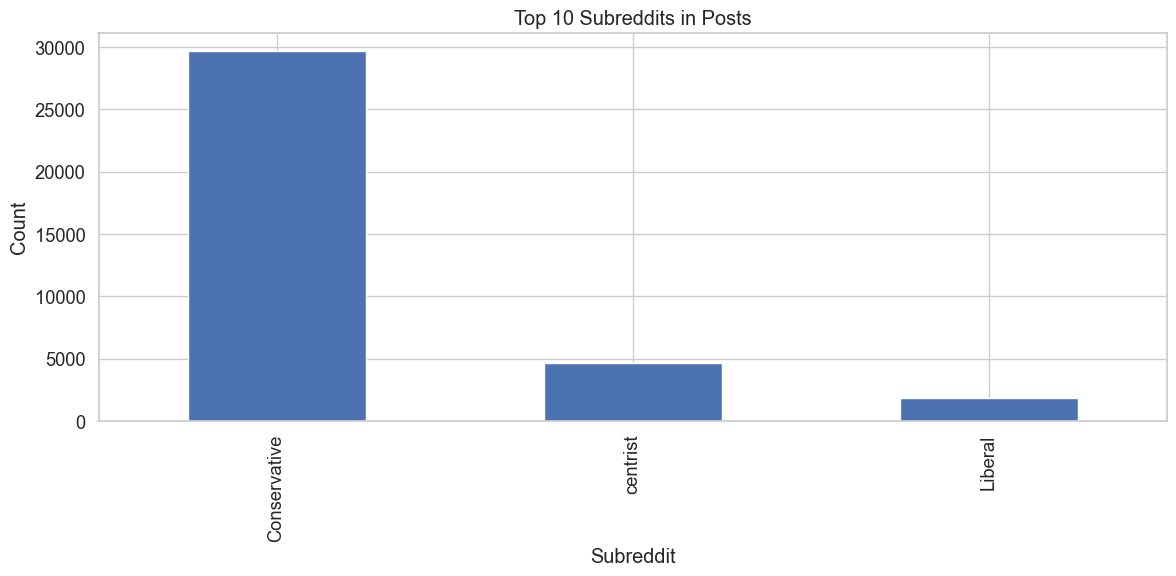


===== Exploring Comments DataFrame =====
Shape: (160987, 88)

Column names:
['_meta', 'all_awardings', 'approved_at_utc', 'approved_by', 'archived', 'associated_award', 'author', 'author_flair_background_color', 'author_flair_css_class', 'author_flair_richtext', 'author_flair_template_id', 'author_flair_text', 'author_flair_text_color', 'author_flair_type', 'author_fullname', 'author_is_blocked', 'author_patreon_flair', 'author_premium', 'awarders', 'banned_at_utc', 'banned_by', 'body', 'can_gild', 'can_mod_post', 'collapsed', 'collapsed_because_crowd_control', 'collapsed_reason', 'collapsed_reason_code', 'comment_type', 'controversiality', 'created', 'created_utc', 'distinguished', 'downs', 'edited', 'gilded', 'gildings', 'id', 'is_submitter', 'likes', 'link_id', 'locked', 'mod_note', 'mod_reason_by', 'mod_reason_title', 'mod_reports', 'name', 'no_follow', 'num_reports', 'parent_id', 'permalink', 'removal_reason', 'replies', 'report_reasons', 'retrieved_on', 'saved', 'score', 'score_

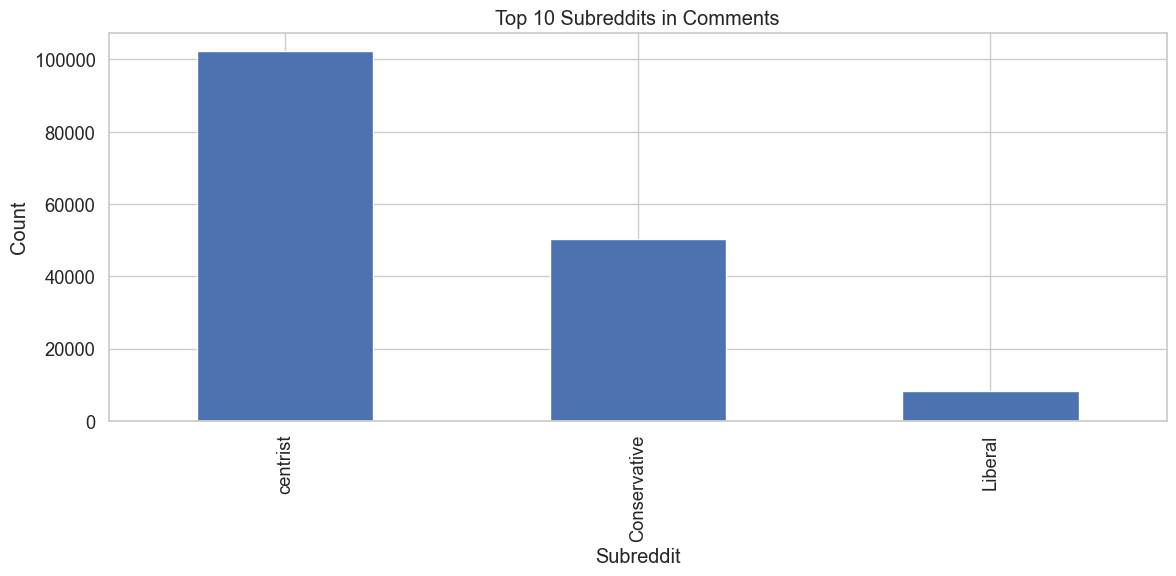


Date range:
First date: 2024-04-01 16:44:20
Last date: 2025-04-29 23:31:44

Date range:
First date: 2024-04-01 17:10:27
Last date: 2025-04-29 23:58:51

===== Exploring title in Posts =====
Null values: 0 (0.00%)

Text length statistics:
count    36111.000000
mean        76.119410
std         40.781072
min          3.000000
25%         51.000000
50%         71.000000
75%         93.000000
max        300.000000
Name: text_length, dtype: float64


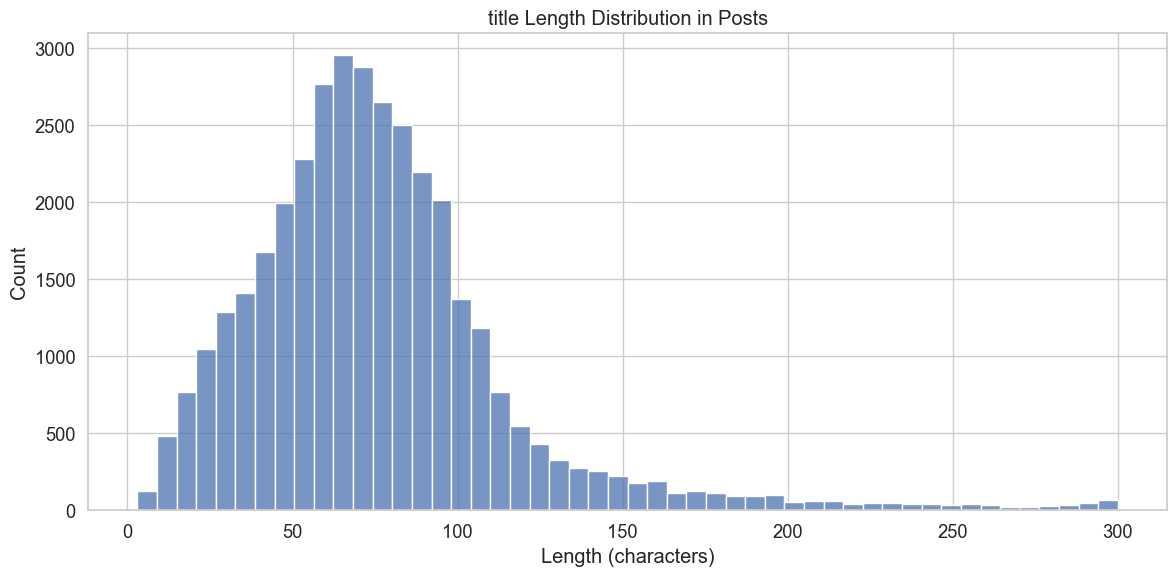


Sample texts:

Sample 1:
Pro-Trump fake electors in Arizona have pleaded the Fifth before grand jury

Sample 2:
DJT Stock Plummets 

Sample 3:
Trump Posts 175 Million Bond in Fraud case

===== Exploring selftext in Posts =====
Null values: 21015 (58.20%)

Text length statistics:
count    36111.000000
mean       134.858132
std        653.828643
min          0.000000
25%          0.000000
50%          0.000000
75%          9.000000
max      27899.000000
Name: text_length, dtype: float64


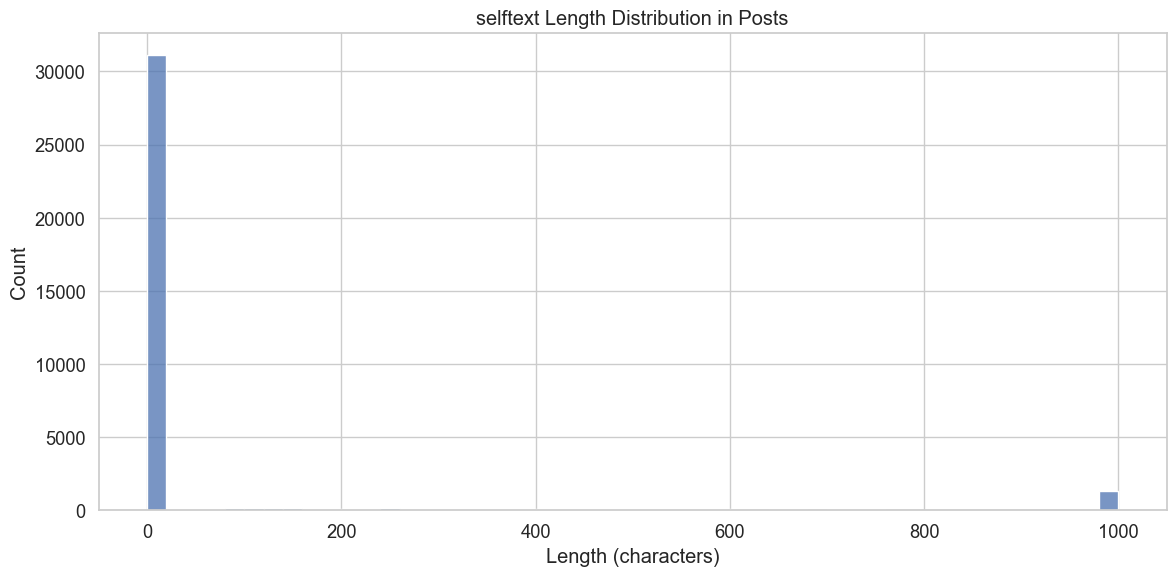


Sample texts:

Sample 1:
https://www.cnbc.com/quotes/DJT

And you ding dongs downvoted me when I said I'd make money on a short position hahahaha. 

Sample 2:
https://www.reuters.com/world/us/trump-posts-175-million-bond-civil-fraud-case-averting-asset-seizures-2024-04-02/

Trump managed to secure the bond for his fraud case. No details yet on when the appeals will be seen.

Sample 3:
As I said in my last post about this, I don’t think he’s going to get away with attacking the judges daughter forever

===== Exploring body in Comments =====
Null values: 0 (0.00%)

Text length statistics:
count    160987.000000
mean        396.907197
std         503.184149
min           4.000000
25%         132.000000
50%         248.000000
75%         468.000000
max        9957.000000
Name: text_length, dtype: float64


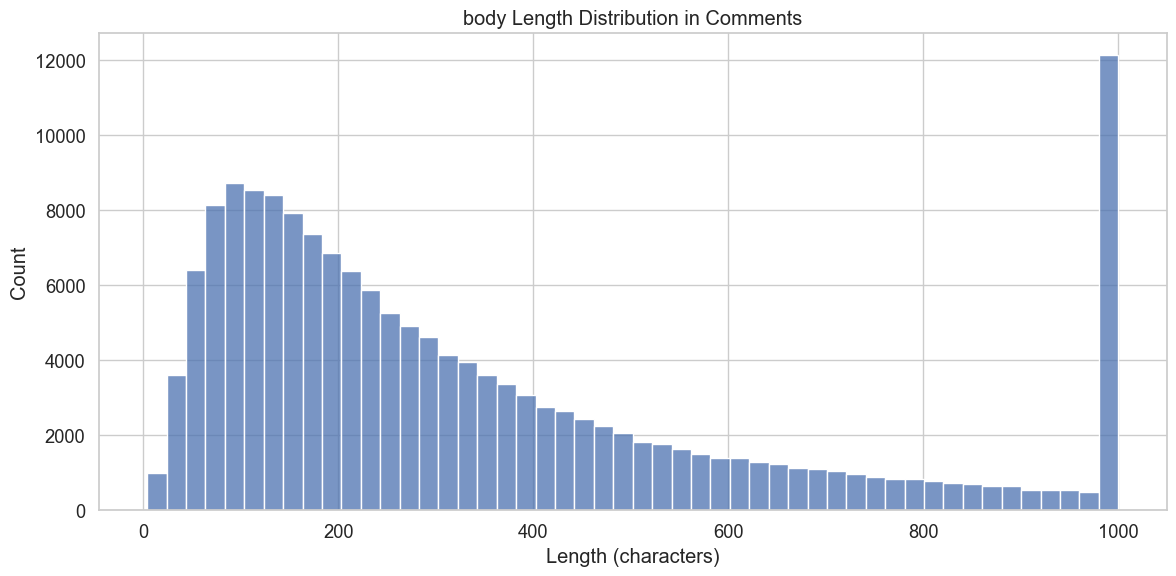


Sample texts:

Sample 1:
“If you’re innocent, why are you taking the Fifth Amendment?” - Donald Trump

Sample 2:
This is the full text of the Fifth amendment:

> No person shall be held to answer for a capital, or otherwise infamous crime, unless on a presentment or indictment of a Grand Jury, except in cases arising in the land or naval forces, or in the Militia, when in actual service in time of War or publi...

Sample 3:
In the words of Donald Trump, "The mob takes the fifth".

===== Analyzing Engagement in Posts =====

Score statistics:
count    36111.000000
mean        98.856526
std        407.939690
min          0.000000
25%          1.000000
50%          1.000000
75%         43.000000
max      17894.000000
Name: score, dtype: float64


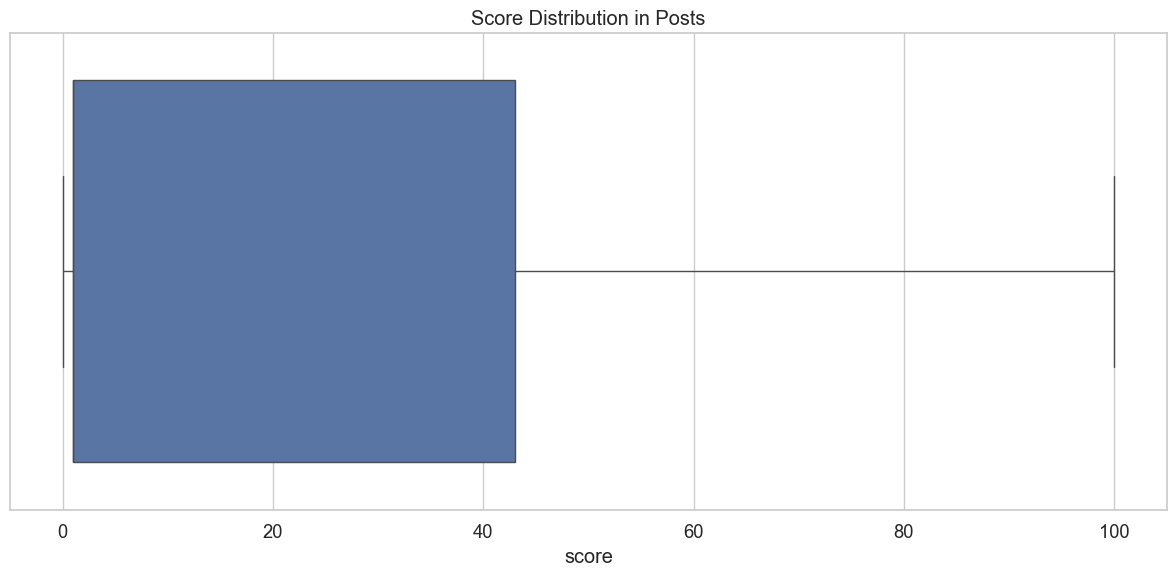


Number of comments statistics:
count    36111.000000
mean        36.759381
std        193.615104
min          0.000000
25%          0.000000
50%          0.000000
75%         18.000000
max      16236.000000
Name: num_comments, dtype: float64


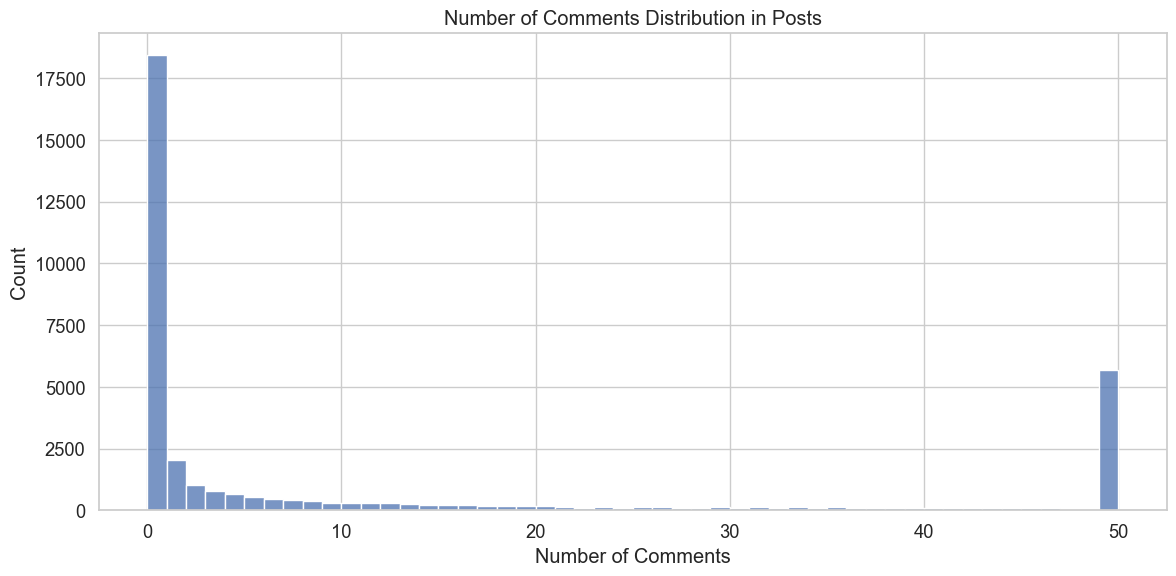


Correlation between metrics:
                 score  num_comments
score         1.000000      0.575917
num_comments  0.575917      1.000000


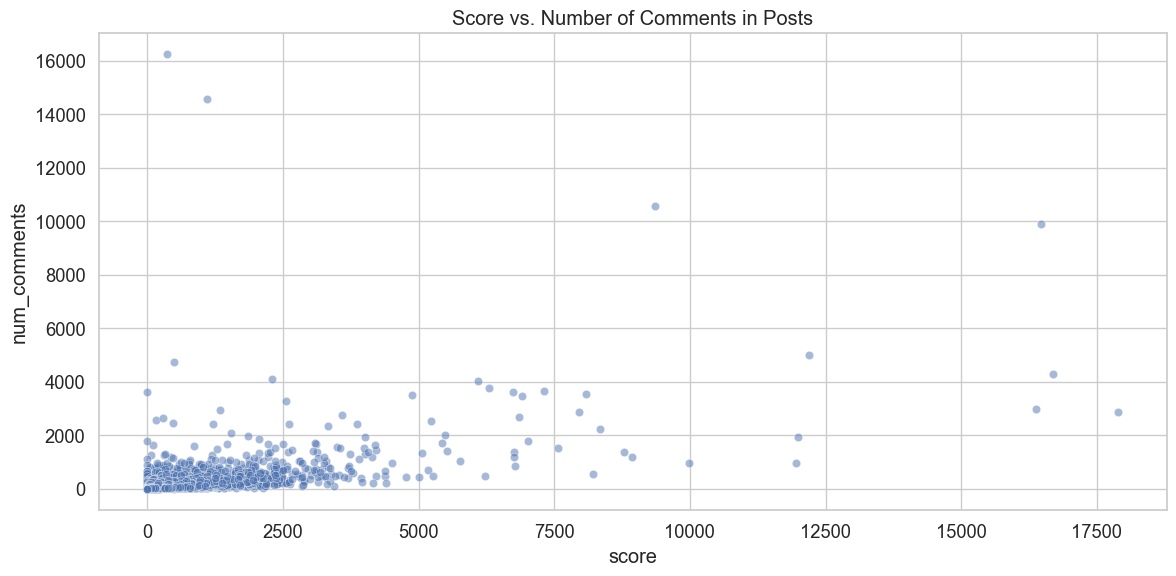


===== Analyzing Engagement in Comments =====

Score statistics:
count    160987.000000
mean         13.331555
std          65.358493
min        -740.000000
25%           1.000000
50%           2.000000
75%           9.000000
max        5755.000000
Name: score, dtype: float64


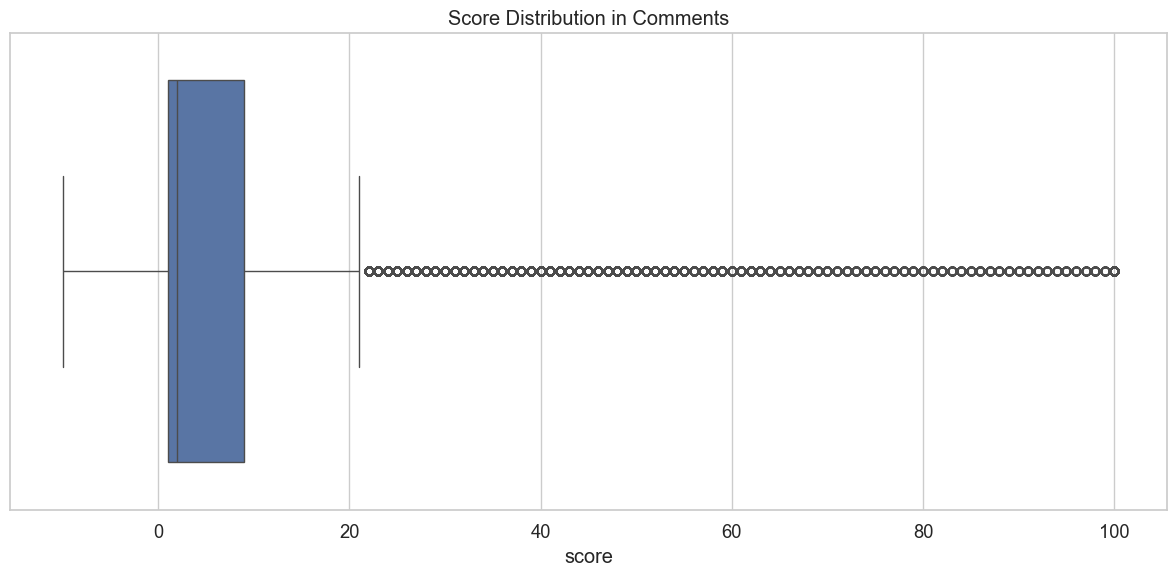

In [86]:
# Basic exploration
def explore_dataframe(df, name):
    """
    Perform basic exploration of a DataFrame
    """
    print(f"\n===== Exploring {name} DataFrame =====")
    print(f"Shape: {df.shape}")
    print("\nColumn names:")
    print(df.columns.tolist())
    print("\nData types:")
    print(df.dtypes)
    print("\nMissing values:")
    print(df.isnull().sum().sort_values(ascending=False).head(20))
    
    # Check if subreddit column exists
    if 'subreddit' in df.columns:
        print("\nSubreddit distribution:")
        sr_counts = df['subreddit'].value_counts()
        print(sr_counts)
        
        # Visualize subreddit distribution
        plt.figure(figsize=(12, 6))
        sr_counts.head(10).plot(kind='bar')
        plt.title(f'Top 10 Subreddits in {name}')
        plt.xlabel('Subreddit')
        plt.ylabel('Count')
        plt.tight_layout()
        plt.show()

# Explore the datasets
explore_dataframe(posts_df, "Posts")
explore_dataframe(comments_df, "Comments")

# Function to parse date fields
def add_datetime_features(df):
    """
    Add datetime features to the DataFrame
    """
    if 'created_utc' in df.columns:
        df['datetime'] = pd.to_datetime(df['created_utc'], unit='s')
        df['date'] = df['datetime'].dt.date
        df['year'] = df['datetime'].dt.year
        df['month'] = df['datetime'].dt.month
        df['day'] = df['datetime'].dt.day
        df['day_of_week'] = df['datetime'].dt.dayofweek
        df['hour'] = df['datetime'].dt.hour
        
        print("\nDate range:")
        print(f"First date: {df['datetime'].min()}")
        print(f"Last date: {df['datetime'].max()}")
    
    return df

# Add datetime features
posts_df = add_datetime_features(posts_df)
comments_df = add_datetime_features(comments_df)

# Function to explore text content 
def explore_text_content(df, text_column, name):
    """
    Explore text content in a DataFrame
    """
    if text_column in df.columns:
        print(f"\n===== Exploring {text_column} in {name} =====")
        
        # Check for null values
        null_count = df[text_column].isnull().sum()
        print(f"Null values: {null_count} ({null_count/len(df)*100:.2f}%)")
        
        # Text length statistics
        df['text_length'] = df[text_column].fillna('').astype(str).apply(len)
        
        print("\nText length statistics:")
        print(df['text_length'].describe())
        
        # Visualize text length distribution
        plt.figure(figsize=(12, 6))
        sns.histplot(df['text_length'].clip(upper=1000), bins=50)
        plt.title(f'{text_column} Length Distribution in {name}')
        plt.xlabel('Length (characters)')
        plt.ylabel('Count')
        plt.tight_layout()
        plt.show()
        
        # Sample of texts (for inspection)
        print("\nSample texts:")
        non_null_samples = df[df[text_column].notna()][text_column].astype(str)
        if not non_null_samples.empty:
            for i, text in enumerate(non_null_samples.head(3)):
                print(f"\nSample {i+1}:")
                print(text[:300] + ('...' if len(text) > 300 else ''))
    
    return df

# Explore text content
posts_df = explore_text_content(posts_df, 'title', 'Posts')
posts_df = explore_text_content(posts_df, 'selftext', 'Posts')
comments_df = explore_text_content(comments_df, 'body', 'Comments')

# Function to analyze engagement metrics
def analyze_engagement(df, name):
    """
    Analyze engagement metrics
    """
    print(f"\n===== Analyzing Engagement in {name} =====")
    
    metrics = []
    
    if 'score' in df.columns:
        metrics.append('score')
        print("\nScore statistics:")
        print(df['score'].describe())
        
        plt.figure(figsize=(12, 6))
        sns.boxplot(x=df['score'].clip(lower=-10, upper=100))
        plt.title(f'Score Distribution in {name}')
        plt.tight_layout()
        plt.show()
    
    if 'num_comments' in df.columns:
        metrics.append('num_comments')
        print("\nNumber of comments statistics:")
        print(df['num_comments'].describe())
        
        plt.figure(figsize=(12, 6))
        sns.histplot(df['num_comments'].clip(upper=50), bins=50)
        plt.title(f'Number of Comments Distribution in {name}')
        plt.xlabel('Number of Comments')
        plt.ylabel('Count')
        plt.tight_layout()
        plt.show()
    
    # If both metrics exist, analyze correlation
    if len(metrics) > 1:
        print("\nCorrelation between metrics:")
        print(df[metrics].corr())
        
        plt.figure(figsize=(12, 6))
        sns.scatterplot(data=df, x='score', y='num_comments', alpha=0.5)
        plt.title(f'Score vs. Number of Comments in {name}')
        plt.tight_layout()
        plt.show()
    
    return df

# Analyze engagement
posts_df = analyze_engagement(posts_df, "Posts")
comments_df = analyze_engagement(comments_df, "Comments")


# Preprocess

Preprocessing title...

Sample processed texts:

Sample 1:
Original: Pro-Trump fake electors in Arizona have pleaded the Fifth before grand jury...
Processed: protrump fake elector arizona pleaded fifth grand jury...

Sample 2:
Original: DJT Stock Plummets ...
Processed: djt stock plummet...

Sample 3:
Original: Trump Posts 175 Million Bond in Fraud case...
Processed: trump post 175 million bond fraud case...
Preprocessing selftext...

Sample processed texts:

Sample 1:
Original: ...
Processed: ...

Sample 2:
Original: https://www.cnbc.com/quotes/DJT

And you ding dongs downvoted me when I said I'd make money on a short position hahahaha. ...
Processed: ding dong downvoted said id make money short position hahahaha...

Sample 3:
Original: https://www.reuters.com/world/us/trump-posts-175-million-bond-civil-fraud-case-averting-asset-seizures-2024-04-02/

Trump managed to secure the bond f...
Processed: trump managed secure bond fraud case detail yet appeal seen...
Preprocessing body...



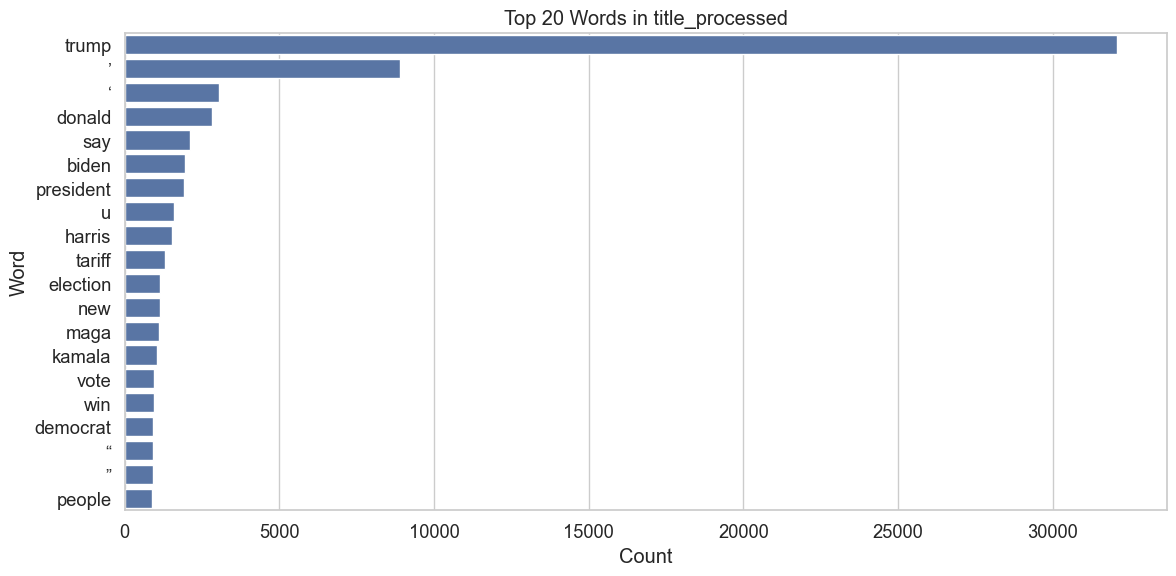


===== Top 20 words in selftext_processed =====

Top words:
’: 8735
trump: 8346
people: 3274
“: 2686
”: 2669
like: 2625
would: 2337
u: 2063
one: 1715
think: 1714
president: 1629
even: 1554
get: 1534
biden: 1497
election: 1440
time: 1413
state: 1397
right: 1379
year: 1371
vote: 1369


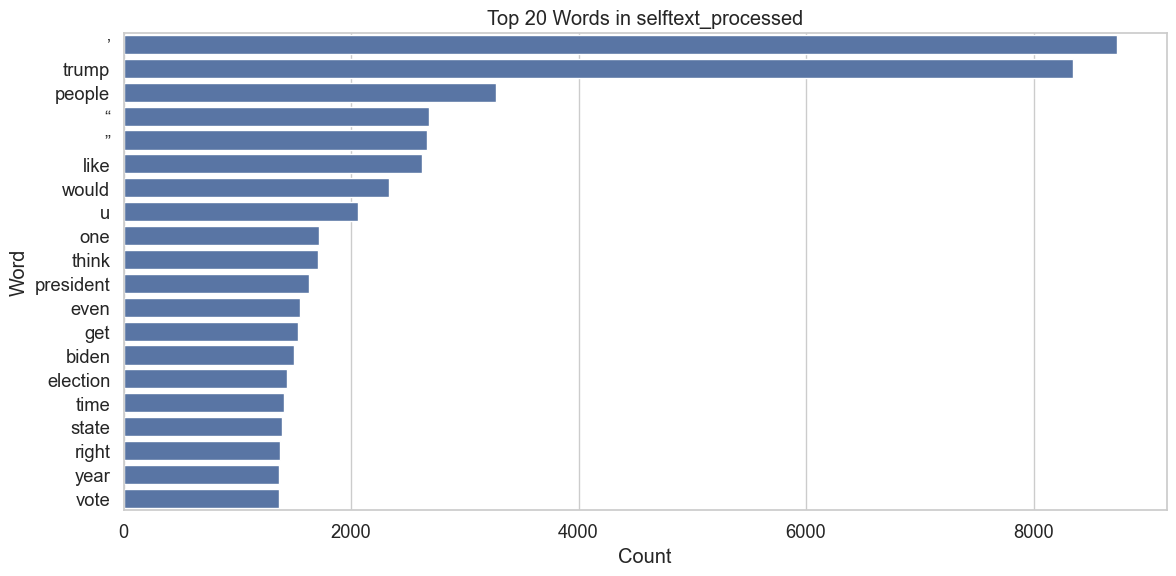


===== Top 20 words in body_processed =====

Top words:
trump: 211826
’: 127762
people: 52967
like: 42722
would: 37661
think: 34603
biden: 29237
one: 26436
get: 25241
even: 23898
thing: 22796
dont: 22627
“: 22210
”: 21994
want: 21453
vote: 21117
right: 20782
going: 20653
say: 20479
u: 20386


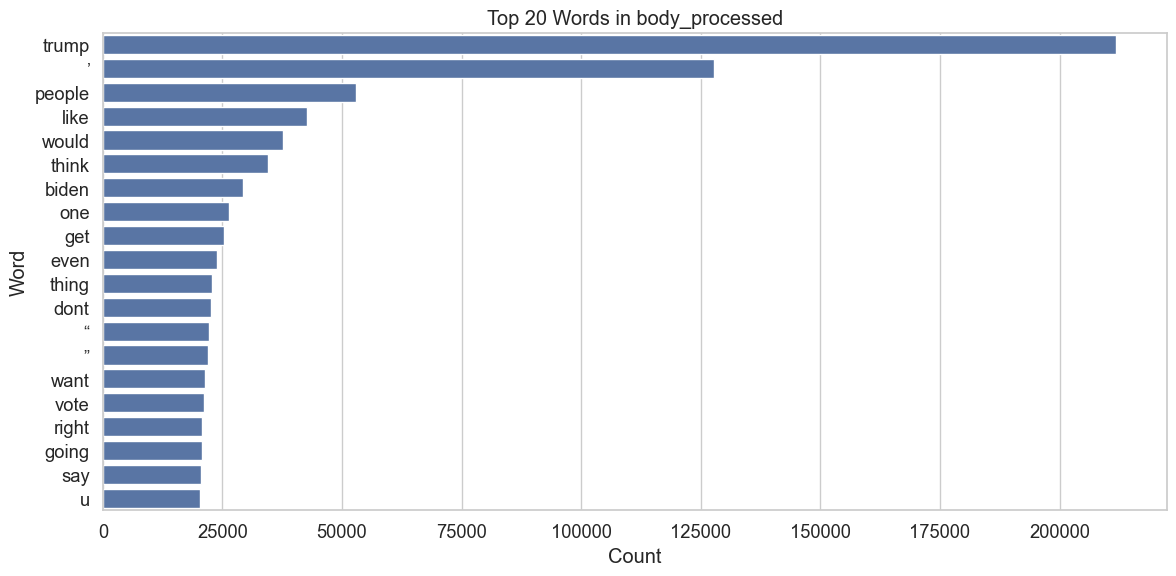

Preprocessing complete! Data saved to 'preprocessed_posts.csv' and 'preprocessed_comments.csv'


In [87]:
def preprocess_text(text, remove_stopwords=True, lemmatize=True):
    """
    Preprocess text data for NLP tasks
    """
    if not isinstance(text, str):
        return ''
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs, links
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove Reddit-specific formatting
    text = re.sub(r'\[.*?\]|\(.*?\)', '', text)
    
    # Remove punctuation and special characters
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatize
    if lemmatize:
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Join tokens back into a string
    processed_text = ' '.join(tokens)
    
    return processed_text

# Apply preprocessing to text columns
def preprocess_dataframe(df, text_columns):
    """
    Apply preprocessing to text columns in a DataFrame
    """
    for col in text_columns:
        if col in df.columns:
            print(f"Preprocessing {col}...")
            col_processed = f"{col}_processed"
            df[col_processed] = df[col].fillna('').astype(str).apply(preprocess_text)
            
            # Sample of processed texts
            print("\nSample processed texts:")
            for i, (original, processed) in enumerate(zip(df[col].fillna('').astype(str).head(3), 
                                                        df[col_processed].head(3))):
                print(f"\nSample {i+1}:")
                print(f"Original: {original[:150]}...")
                print(f"Processed: {processed[:150]}...")
    
    return df

# Preprocess text columns
posts_df = preprocess_dataframe(posts_df, ['title', 'selftext'])
comments_df = preprocess_dataframe(comments_df, ['body'])

# Function to extract and analyze top words
def analyze_top_words(df, text_column, n=20):
    """
    Extract and analyze top words from a processed text column
    """
    if text_column in df.columns:
        print(f"\n===== Top {n} words in {text_column} =====")
        
        # Combine all words
        all_words = ' '.join(df[text_column].fillna('')).split()
        
        # Count word frequencies
        word_counts = Counter(all_words)
        
        # Get top N words
        top_words = word_counts.most_common(n)
        
        print("\nTop words:")
        for word, count in top_words:
            print(f"{word}: {count}")
        
        # Visualize top words
        plt.figure(figsize=(12, 6))
        words, counts = zip(*top_words)
        sns.barplot(x=list(counts), y=list(words))
        plt.title(f'Top {n} Words in {text_column}')
        plt.xlabel('Count')
        plt.ylabel('Word')
        plt.tight_layout()
        plt.show()
    
    return df

# Analyze top words
analyze_top_words(posts_df, 'title_processed')
analyze_top_words(posts_df, 'selftext_processed')
analyze_top_words(comments_df, 'body_processed')

# Save preprocessed data
posts_df.to_csv('preprocessed_posts.csv', index=False)
comments_df.to_csv('preprocessed_comments.csv', index=False)

print("Preprocessing complete! Data saved to 'preprocessed_posts.csv' and 'preprocessed_comments.csv'")

# RoBERTa Sentiment Analysis

In [ ]:
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


In [91]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(torch.cuda.is_available())       # Should be True
# print(torch.cuda.device_count())       # Should be >= 1
# print(torch.cuda.get_device_name(0))   # Should show your GPU model


Using device: cpu
Loading RoBERTa model: cardiffnlp/twitter-roberta-base-sentiment...


Analyzing sentiment with RoBERTa for title_processed: 100%|██████████| 36111/36111 [03:20<00:00, 179.77it/s]


RoBERTa sentiment distribution:
title_processed_roberta_sentiment
NEUTRAL     24042
NEGATIVE    10385
POSITIVE     1684
Name: count, dtype: int64


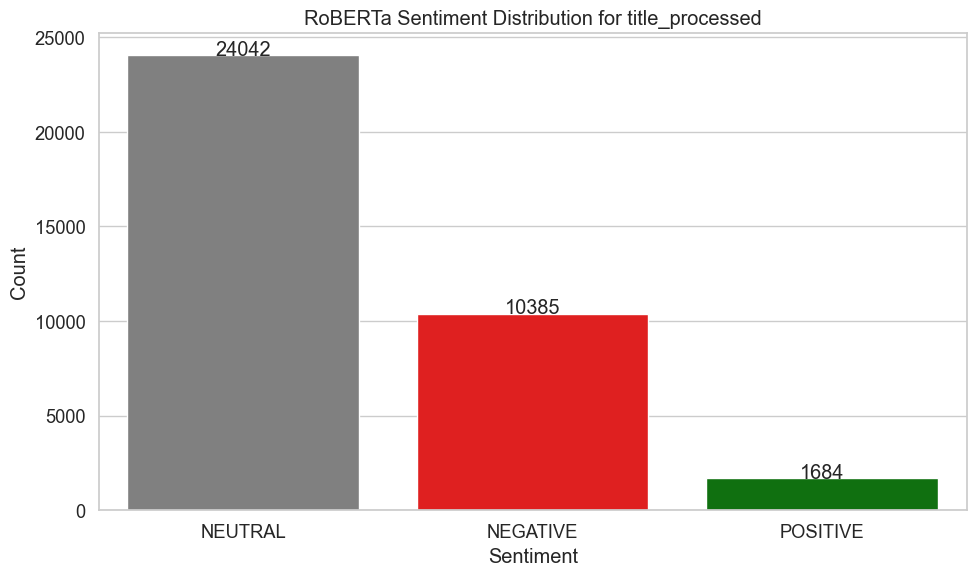

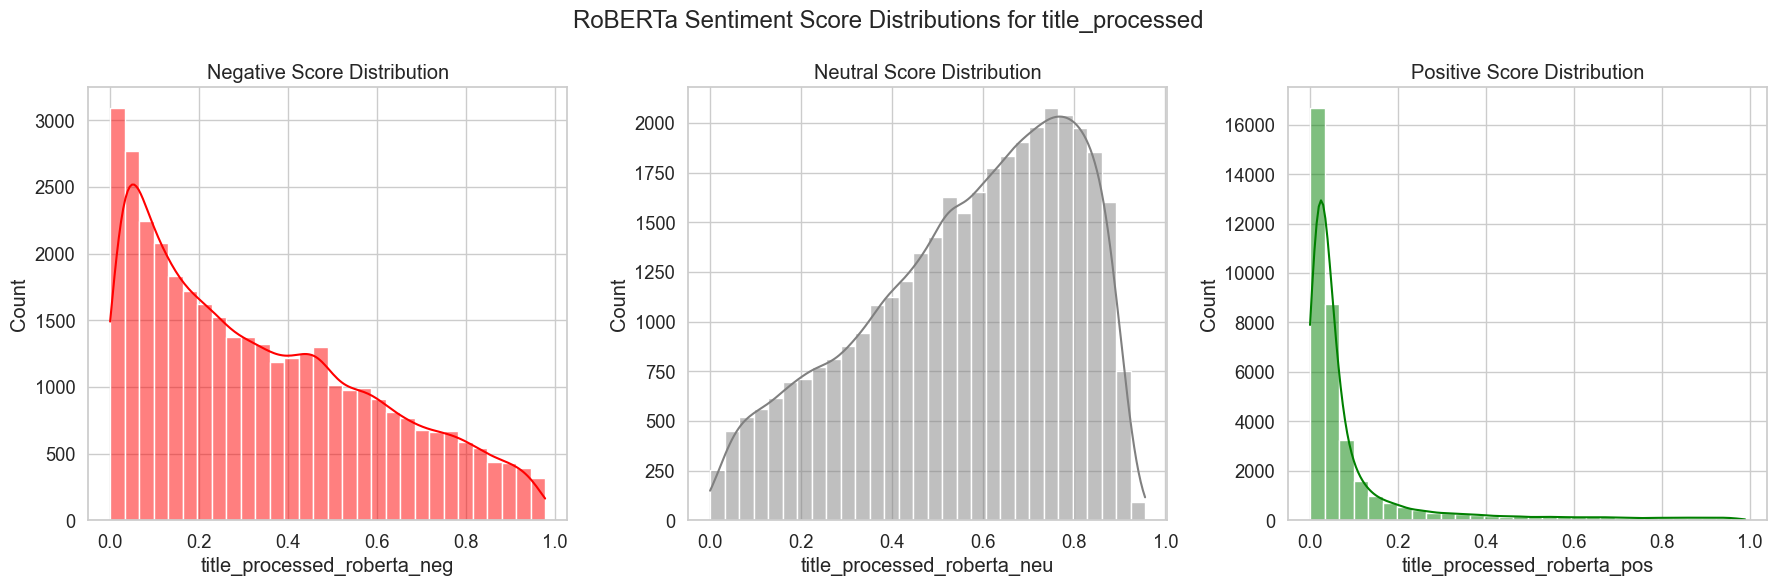

Average confidence score: 0.6954
Loading RoBERTa model: cardiffnlp/twitter-roberta-base-sentiment...


Analyzing sentiment with RoBERTa for body_processed: 100%|██████████| 160987/160987 [1:41:51<00:00, 26.34it/s]  


RoBERTa sentiment distribution:
body_processed_roberta_sentiment
NEGATIVE    82608
NEUTRAL     72030
POSITIVE     6349
Name: count, dtype: int64


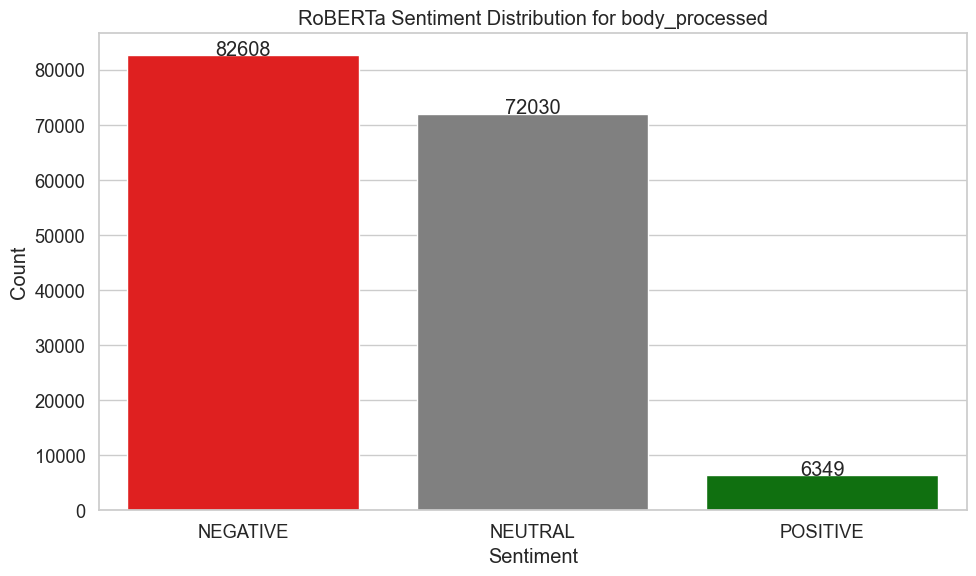

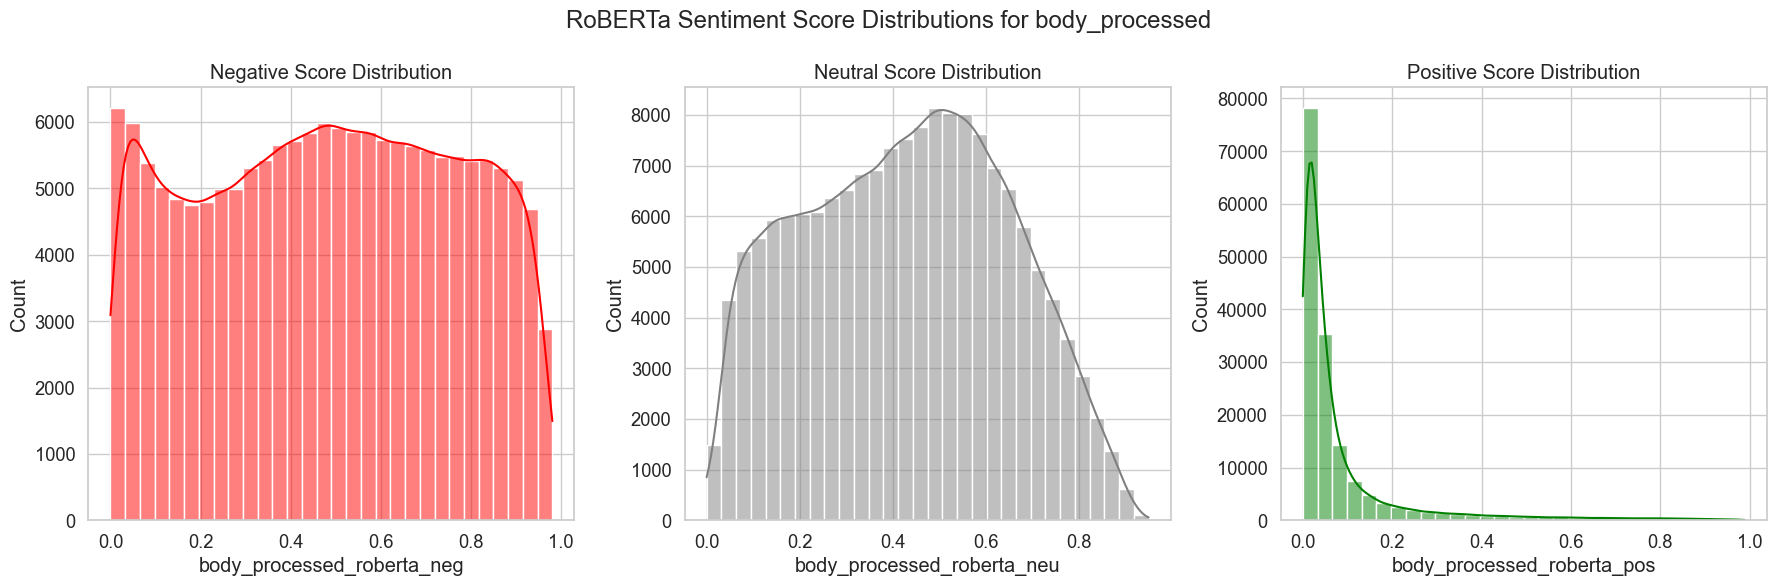

Average confidence score: 0.6723
Not enough sentiment methods available for comparison
Not enough sentiment methods available for comparison

===== RoBERTa Sentiment Analysis by Subreddit (title_processed) =====

Sentiment distribution by subreddit (%):
title_processed_roberta_sentiment  NEGATIVE  NEUTRAL  POSITIVE
subreddit                                                     
Conservative                          28.07    66.88      5.05
Liberal                               36.38    60.65      2.97
centrist                              30.19    66.97      2.84


<Figure size 1400x800 with 0 Axes>

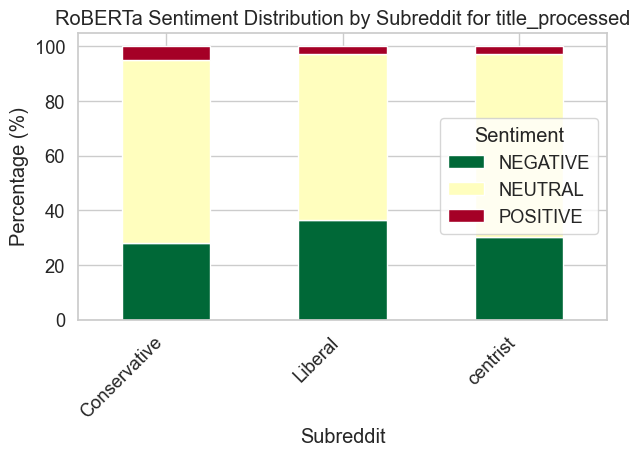


Sentiment score by subreddit (Positive % - Negative %):
subreddit
Conservative   -23.018868
centrist       -27.351539
Liberal        -33.406714
Name: SENTIMENT_SCORE, dtype: float64


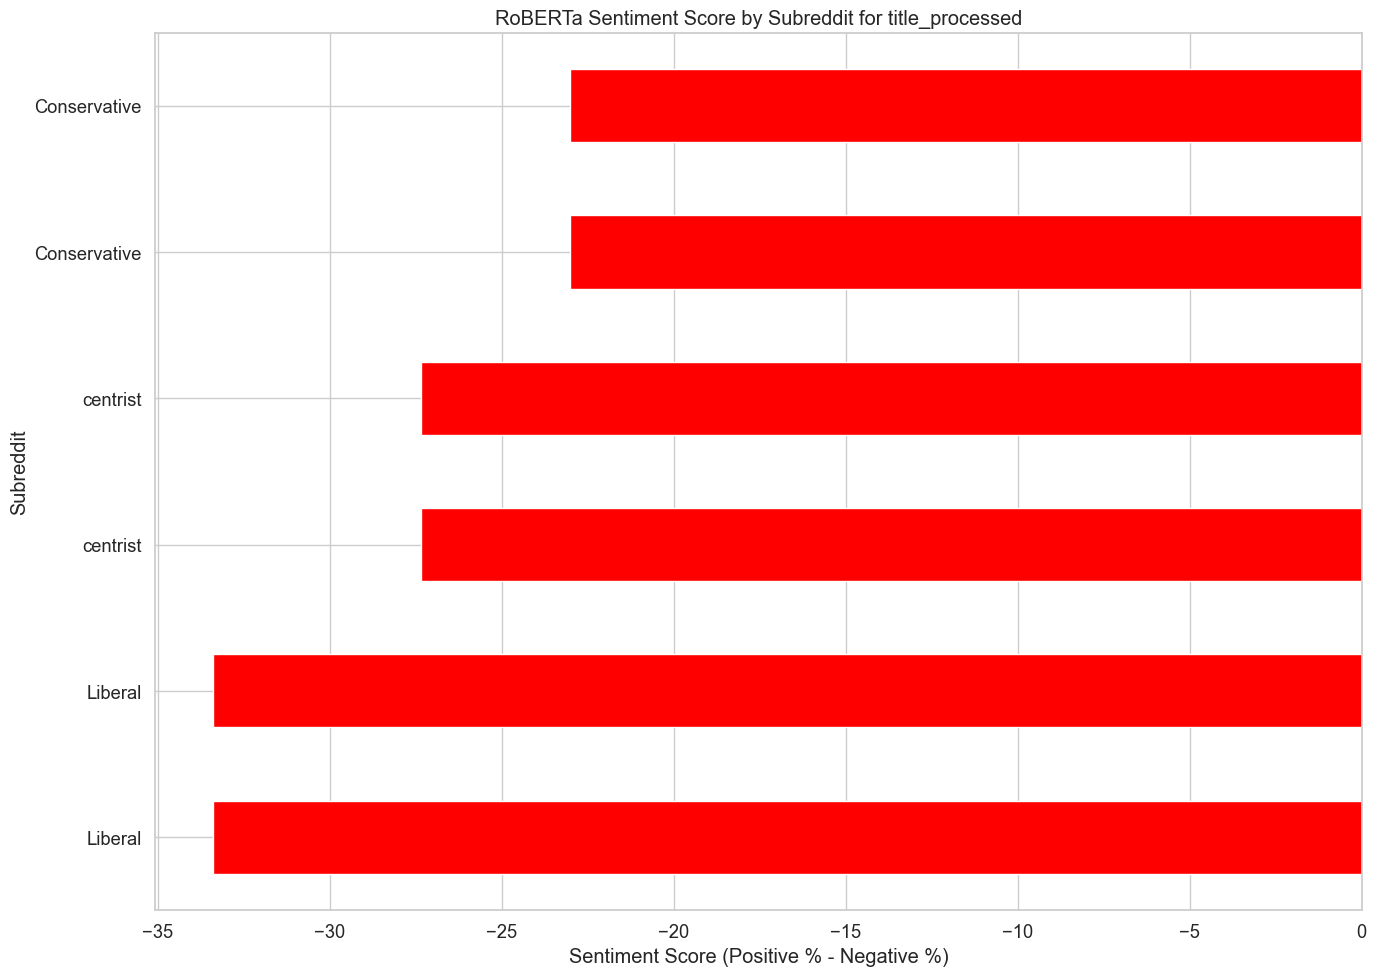


===== RoBERTa Sentiment Analysis by Subreddit (body_processed) =====

Sentiment distribution by subreddit (%):
body_processed_roberta_sentiment  NEGATIVE  NEUTRAL  POSITIVE
subreddit                                                    
Conservative                         45.29    48.22      6.49
Liberal                              56.62    40.24      3.14
centrist                             53.85    43.39      2.76


<Figure size 1400x800 with 0 Axes>

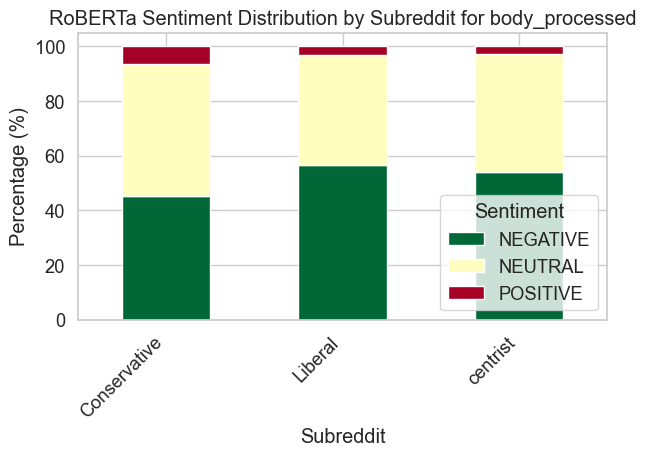


Sentiment score by subreddit (Positive % - Negative %):
subreddit
Conservative   -38.808517
centrist       -51.091481
Liberal        -53.487527
Name: SENTIMENT_SCORE, dtype: float64


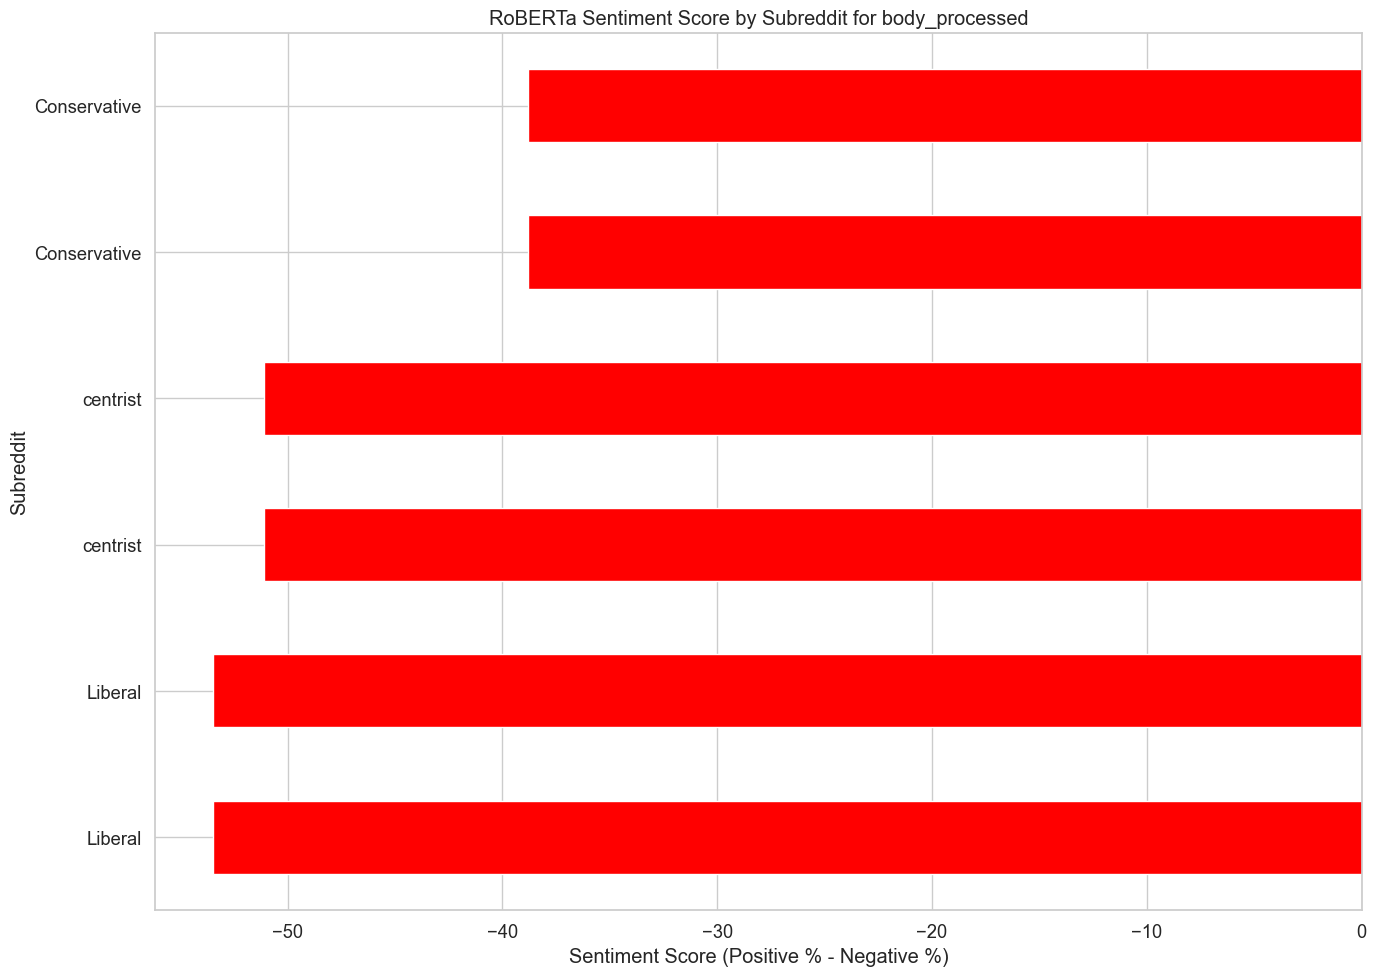

RoBERTa sentiment analysis complete! Results saved to CSV files.

===== Most Positive title_processed Examples =====

Example 1 (Score: 0.9887):
photo adorable barron look proud mom 🥹🥰❤️

Example 2 (Score: 0.9858):
give ❤️ love president donald j trump

Example 3 (Score: 0.9858):
give ❤️ love president donald j trump

===== Most Negative title_processed Examples =====

Example 1 (Score: 0.0018):
trump actually incited hatred violence word

Example 2 (Score: 0.0018):
recently saw news video trump feed much cant stand trump stop watching cody wouldnt stfu israel supposed genocide palestinian

Example 3 (Score: 0.0018):
daily reminder donald trump literally child rapist let sink raped 12 year old girl

===== Most Positive title_processed Examples =====

Example 1 (Score: 0.9783):
fucking idiot bottom feeder like trump boomer lead poisoning

Example 2 (Score: 0.9780):
donald trump lying fucking retard youre going burn obeying none inherit kingdom damnation come white race disgusting freak 

In [92]:

# Check if CUDA is available for GPU acceleration
print(f"Using device: {device}")

# RoBERTa Sentiment Analysis Implementation
# =======================================

from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch.nn.functional as F

def apply_roberta_sentiment(df, text_column, model_name='cardiffnlp/twitter-roberta-base-sentiment', batch_size=16, max_length=512):
    """
    Apply RoBERTa-based sentiment analysis to a text column
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing the text data
    text_column : str
        Column name with the text to analyze
    model_name : str, default='cardiffnlp/twitter-roberta-base-sentiment'
        HuggingFace model name to use
    batch_size : int, default=16
        Batch size for processing
    max_length : int, default=512
        Maximum sequence length for tokenization
        
    Returns:
    --------
    df : pandas DataFrame
        DataFrame with RoBERTa sentiment scores added
    """
    print(f"Loading RoBERTa model: {model_name}...")
    
    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)
    
    # Define label mapping for the model
    labels = ['NEGATIVE', 'NEUTRAL', 'POSITIVE']
    
    # Create progress bar for overall process
    with tqdm(total=len(df), desc=f"Analyzing sentiment with RoBERTa for {text_column}") as pbar:
        
        # Create new columns for RoBERTa results
        df[f'{text_column}_roberta_sentiment'] = 'NEUTRAL'  # Default value
        df[f'{text_column}_roberta_neg'] = 0.0
        df[f'{text_column}_roberta_neu'] = 0.0
        df[f'{text_column}_roberta_pos'] = 0.0
        
        # Process in batches
        for start_idx in range(0, len(df), batch_size):
            end_idx = min(start_idx + batch_size, len(df))
            batch = df.iloc[start_idx:end_idx]
            
            # Get text data
            texts = batch[text_column].fillna('').astype(str).tolist()
            
            # Skip empty batch
            if not any(text.strip() for text in texts):
                pbar.update(len(batch))
                continue
            
            try:
                # Tokenize
                encoded_input = tokenizer(
                    texts, 
                    padding=True, 
                    truncation=True, 
                    max_length=max_length, 
                    return_tensors='pt'
                ).to(device)
                
                # Get predictions
                with torch.no_grad():
                    output = model(**encoded_input)
                    
                # Get sentiment scores
                scores = F.softmax(output.logits, dim=1).cpu().numpy()
                
                # Update DataFrame with results
                for i, (idx, row) in enumerate(batch.iterrows()):
                    text = row[text_column]
                    if isinstance(text, str) and text.strip():
                        label_idx = np.argmax(scores[i])
                        df.at[idx, f'{text_column}_roberta_sentiment'] = labels[label_idx]
                        df.at[idx, f'{text_column}_roberta_neg'] = float(scores[i][0])
                        df.at[idx, f'{text_column}_roberta_neu'] = float(scores[i][1])
                        df.at[idx, f'{text_column}_roberta_pos'] = float(scores[i][2])
            
            except Exception as e:
                print(f"Error processing batch {start_idx}-{end_idx}: {str(e)}")
            
            # Update progress bar
            pbar.update(len(batch))
    
    # Analyze results
    print("\nRoBERTa sentiment distribution:")
    sentiment_counts = df[f'{text_column}_roberta_sentiment'].value_counts()
    print(sentiment_counts)
    
    # Visualize sentiment distribution
    plt.figure(figsize=(10, 6))
    colors = {'POSITIVE': 'green', 'NEUTRAL': 'gray', 'NEGATIVE': 'red'}
    
    # Plot counts
    ax = sns.barplot(
        x=sentiment_counts.index, 
        y=sentiment_counts.values,
        palette=[colors.get(x, 'blue') for x in sentiment_counts.index]
    )
    
    # Add count labels on bars
    for i, count in enumerate(sentiment_counts.values):
        ax.text(i, count + 5, str(count), ha='center')
    
    plt.title(f'RoBERTa Sentiment Distribution for {text_column}')
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()
    
    # Visualize score distributions
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Negative scores
    sns.histplot(df[f'{text_column}_roberta_neg'], bins=30, kde=True, ax=axes[0], color='red')
    axes[0].set_title('Negative Score Distribution')
    
    # Neutral scores
    sns.histplot(df[f'{text_column}_roberta_neu'], bins=30, kde=True, ax=axes[1], color='gray')
    axes[1].set_title('Neutral Score Distribution')
    
    # Positive scores
    sns.histplot(df[f'{text_column}_roberta_pos'], bins=30, kde=True, ax=axes[2], color='green')
    axes[2].set_title('Positive Score Distribution')
    
    plt.suptitle(f'RoBERTa Sentiment Score Distributions for {text_column}')
    plt.tight_layout()
    plt.show()
    
    # Calculate average confidence
    df[f'{text_column}_roberta_confidence'] = df.apply(
        lambda row: max(
            row[f'{text_column}_roberta_neg'],
            row[f'{text_column}_roberta_neu'],
            row[f'{text_column}_roberta_pos']
        ),
        axis=1
    )
    
    avg_confidence = df[f'{text_column}_roberta_confidence'].mean()
    print(f"Average confidence score: {avg_confidence:.4f}")
    
    return df

# Apply RoBERTa sentiment analysis to Reddit posts
# Note: You can adjust the batch_size based on your GPU memory
roberta_posts_df = apply_roberta_sentiment(posts_df, 'title_processed', batch_size=32)

# Apply RoBERTa sentiment analysis to Reddit comments
roberta_comments_df = apply_roberta_sentiment(comments_df, 'body_processed', batch_size=32)

# Compare with other sentiment analysis methods (if available)
def compare_sentiment_methods(df, text_column):
    """
    Compare RoBERTa sentiment with other methods (if available)
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame with sentiment analysis results
    text_column : str
        Base column name used for sentiment analysis
    """
    # Check if other sentiment methods are available for comparison
    has_vader = f'{text_column}_sentiment' in df.columns
    has_textblob = f'{text_column}_tb_sentiment' in df.columns
    has_roberta = f'{text_column}_roberta_sentiment' in df.columns
    
    if not (has_vader and has_roberta):
        print("Not enough sentiment methods available for comparison")
        return
    
    print(f"\n===== Comparing Sentiment Methods for {text_column} =====")
    
    # Convert RoBERTa labels to lowercase for consistent comparison
    df[f'{text_column}_roberta_sentiment_lower'] = df[f'{text_column}_roberta_sentiment'].str.lower()
    
    # Compare RoBERTa with VADER
    if has_vader:
        print("\nRoBERTa vs VADER:")
        vader_comparison = pd.crosstab(
            df[f'{text_column}_roberta_sentiment_lower'],
            df[f'{text_column}_sentiment'],
            rownames=['RoBERTa'],
            colnames=['VADER'],
            normalize='index'
        ) * 100  # Convert to percentage
        
        print(vader_comparison.round(2))
        
        # Visualize comparison
        plt.figure(figsize=(10, 8))
        sns.heatmap(
            vader_comparison, 
            annot=True, 
            fmt='.1f', 
            cmap='YlGnBu',
            cbar_kws={'label': 'Percentage %'}
        )
        plt.title(f'RoBERTa vs VADER Sentiment for {text_column}')
        plt.tight_layout()
        plt.show()
    
    # Compare RoBERTa with TextBlob
    if has_textblob:
        print("\nRoBERTa vs TextBlob:")
        textblob_comparison = pd.crosstab(
            df[f'{text_column}_roberta_sentiment_lower'],
            df[f'{text_column}_tb_sentiment'],
            rownames=['RoBERTa'],
            colnames=['TextBlob'],
            normalize='index'
        ) * 100  # Convert to percentage
        
        print(textblob_comparison.round(2))
        
        # Visualize comparison
        plt.figure(figsize=(10, 8))
        sns.heatmap(
            textblob_comparison, 
            annot=True, 
            fmt='.1f', 
            cmap='YlGnBu',
            cbar_kws={'label': 'Percentage %'}
        )
        plt.title(f'RoBERTa vs TextBlob Sentiment for {text_column}')
        plt.tight_layout()
        plt.show()
    
    # Calculate overall agreement percentage
    if has_vader:
        vader_agreement = (df[f'{text_column}_roberta_sentiment_lower'] == df[f'{text_column}_sentiment']).mean() * 100
        print(f"\nRoBERTa and VADER agreement: {vader_agreement:.2f}%")
    
    if has_textblob:
        textblob_agreement = (df[f'{text_column}_roberta_sentiment_lower'] == df[f'{text_column}_tb_sentiment']).mean() * 100
        print(f"RoBERTa and TextBlob agreement: {textblob_agreement:.2f}%")
    
    # Calculate agreement across all methods
    if has_vader and has_textblob:
        all_agree = (
            (df[f'{text_column}_roberta_sentiment_lower'] == df[f'{text_column}_sentiment']) &
            (df[f'{text_column}_sentiment'] == df[f'{text_column}_tb_sentiment'])
        ).mean() * 100
        print(f"All methods agreement: {all_agree:.2f}%")

# Compare sentiment methods
compare_sentiment_methods(roberta_posts_df, 'title_processed')
compare_sentiment_methods(roberta_comments_df, 'body_processed')

# Function to analyze sentiment by subreddit using RoBERTa
def analyze_roberta_sentiment_by_subreddit(df, text_column):
    """
    Analyze RoBERTa sentiment distribution across different subreddits
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame with RoBERTa sentiment results
    text_column : str
        Base column name used for sentiment analysis
    """
    if 'subreddit' not in df.columns or f'{text_column}_roberta_sentiment' not in df.columns:
        print("Required columns not found in DataFrame")
        return
    
    print(f"\n===== RoBERTa Sentiment Analysis by Subreddit ({text_column}) =====")
    
    # Get sentiment counts by subreddit
    sentiment_by_subreddit = pd.crosstab(
        df['subreddit'],
        df[f'{text_column}_roberta_sentiment'],
        normalize='index'
    ) * 100  # Convert to percentage
    
    # Sort by positive sentiment
    if 'POSITIVE' in sentiment_by_subreddit.columns:
        sentiment_by_subreddit = sentiment_by_subreddit.sort_values('POSITIVE', ascending=False)
    
    print("\nSentiment distribution by subreddit (%):")
    print(sentiment_by_subreddit.round(2).head(10))  # Show top 10 subreddits
    
    # Visualize sentiment by subreddit (top 10)
    plt.figure(figsize=(14, 8))
    sentiment_by_subreddit.head(10).plot(
        kind='bar', 
        stacked=True,
        colormap='RdYlGn_r'  # Red for negative, green for positive
    )
    plt.title(f'RoBERTa Sentiment Distribution by Subreddit for {text_column}')
    plt.xlabel('Subreddit')
    plt.ylabel('Percentage (%)')
    plt.legend(title='Sentiment')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Create a sentiment score (positive - negative percentage)
    sentiment_score = sentiment_by_subreddit.copy()
    if all(label in sentiment_by_subreddit.columns for label in ['POSITIVE', 'NEGATIVE']):
        sentiment_score['SENTIMENT_SCORE'] = sentiment_by_subreddit['POSITIVE'] - sentiment_by_subreddit['NEGATIVE']
        
        # Sort and display
        sentiment_score = sentiment_score.sort_values('SENTIMENT_SCORE', ascending=False)
        print("\nSentiment score by subreddit (Positive % - Negative %):")
        print(sentiment_score['SENTIMENT_SCORE'].head(10))
        
        # Visualize sentiment score
        plt.figure(figsize=(14, 8))
        top_subreddits = sentiment_score.head(15).index
        bottom_subreddits = sentiment_score.tail(15).index
        selected_subreddits = pd.concat([sentiment_score.loc[top_subreddits], sentiment_score.loc[bottom_subreddits]])
        
        # Plot sentiment score
        colors = ['green' if x >= 0 else 'red' for x in selected_subreddits['SENTIMENT_SCORE']]
        ax = selected_subreddits['SENTIMENT_SCORE'].sort_values().plot(
            kind='barh',
            color=colors,
            figsize=(14, 10)
        )
        
        # Add a vertical line at 0
        plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
        
        plt.title(f'RoBERTa Sentiment Score by Subreddit for {text_column}')
        plt.xlabel('Sentiment Score (Positive % - Negative %)')
        plt.ylabel('Subreddit')
        plt.tight_layout()
        plt.show()

# Analyze RoBERTa sentiment by subreddit
analyze_roberta_sentiment_by_subreddit(roberta_posts_df, 'title_processed')
analyze_roberta_sentiment_by_subreddit(roberta_comments_df, 'body_processed')

# Save results
roberta_posts_df.to_csv('roberta_sentiment_posts.csv', index=False)
roberta_comments_df.to_csv('roberta_sentiment_comments.csv', index=False)

print("RoBERTa sentiment analysis complete! Results saved to CSV files.")

# Additional Analysis: Extract Most Positive and Negative Posts/Comments
# ===================================================================

def extract_sentiment_examples(df, text_column, sentiment_column, n=5):
    """
    Extract examples of the most positive and negative content
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame with sentiment analysis results
    text_column : str
        Column containing the text content
    sentiment_column : str
        Column containing sentiment scores
    n : int, default=5
        Number of examples to extract
    """
    # Make sure text is not empty
    filtered_df = df[df[text_column].notna() & (df[text_column].astype(str).str.strip() != '')]
    
    if sentiment_column not in filtered_df.columns:
        print(f"Sentiment column {sentiment_column} not found")
        return
    
    print(f"\n===== Most Positive {text_column} Examples =====")
    most_positive = filtered_df.nlargest(n, sentiment_column)
    for i, (_, row) in enumerate(most_positive.iterrows()):
        print(f"\nExample {i+1} (Score: {row[sentiment_column]:.4f}):")
        text = row[text_column]
        # Truncate very long text
        if len(text) > 500:
            text = text[:500] + "..."
        print(text)
    
    print(f"\n===== Most Negative {text_column} Examples =====")
    most_negative = filtered_df.nsmallest(n, sentiment_column)
    for i, (_, row) in enumerate(most_negative.iterrows()):
        print(f"\nExample {i+1} (Score: {row[sentiment_column]:.4f}):")
        text = row[text_column]
        # Truncate very long text
        if len(text) > 500:
            text = text[:500] + "..."
        print(text)

# Extract examples based on RoBERTa scores
if 'title_processed_roberta_pos' in roberta_posts_df.columns:
    extract_sentiment_examples(
        roberta_posts_df, 
        'title_processed', 
        'title_processed_roberta_pos', 
        n=3
    )

if 'title_processed_roberta_neg' in roberta_posts_df.columns:
    extract_sentiment_examples(
        roberta_posts_df, 
        'title_processed', 
        'title_processed_roberta_neg', 
        n=3
    )

if 'body_processed_roberta_pos' in roberta_comments_df.columns:
    extract_sentiment_examples(
        roberta_comments_df, 
        'body_processed', 
        'body_processed_roberta_pos', 
        n=3
    )

if 'body_processed_roberta_neg' in roberta_comments_df.columns:
    extract_sentiment_examples(
        roberta_comments_df, 
        'body_processed', 
        'body_processed_roberta_neg', 
        n=3
    )

print("\nRoBERTa sentiment analysis and examples extraction complete!")

##  ====================================================================
## 1. Sentiment Polarization Analysis by Subreddit
## ====================================================================

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import pearsonr, spearmanr
import networkx as nx
from sklearn.metrics import confusion_matrix, classification_report

# Assuming you already have the following DataFrames:
# trump_posts_df - filtered posts related to Trump with RoBERTa sentiment
# trump_comments_df - comments on Trump-related posts with RoBERTa sentiment



def analyze_subreddit_polarization(df, sentiment_col_prefix, min_posts=30):
    """
    Analyze how polarized sentiment is within each subreddit
    
    Parameters:
    -----------
    df : DataFrame
        DataFrame with posts/comments data
    sentiment_col_prefix : str
        Prefix for RoBERTa sentiment columns (e.g., 'title_processed_' or 'body_processed_')
    min_posts : int
        Minimum number of posts required for a subreddit to be included
    """
    print("\n===== Subreddit Polarization Analysis =====")
    
    # Get positive and negative scores
    pos_col = f"{sentiment_col_prefix}roberta_pos"
    neg_col = f"{sentiment_col_prefix}roberta_neg"
    neu_col = f"{sentiment_col_prefix}roberta_neu"
    
    # Group by subreddit
    subreddit_counts = df['subreddit'].value_counts()
    qualified_subreddits = subreddit_counts[subreddit_counts >= min_posts].index
    
    if len(qualified_subreddits) == 0:
        print(f"No subreddits with at least {min_posts} posts/comments")
        return
    
    df_filtered = df[df['subreddit'].isin(qualified_subreddits)]
    
    # Calculate polarization metrics by subreddit
    polarization_data = []
    
    for subreddit in qualified_subreddits:
        subreddit_df = df_filtered[df_filtered['subreddit'] == subreddit]
        
        # Calculate average sentiment scores
        avg_pos = subreddit_df[pos_col].mean()
        avg_neg = subreddit_df[neg_col].mean()
        avg_neu = subreddit_df[neu_col].mean()
        
        # Calculate sentiment variance (higher variance = more polarized)
        sentiment_variance = subreddit_df[pos_col].var() + subreddit_df[neg_col].var()
        
        # Calculate bimodality coefficient (higher = more polarized)
        # For simplicity, we'll use the difference between pos and neg scores
        pos_neg_diff = (subreddit_df[pos_col] - subreddit_df[neg_col]).abs().mean()
        
        # Count sentiment labels
        sentiment_label_col = f"{sentiment_col_prefix}roberta_sentiment"
        labels = subreddit_df[sentiment_label_col].value_counts(normalize=True).to_dict()
        pos_pct = labels.get('POSITIVE', 0) * 100
        neg_pct = labels.get('NEGATIVE', 0) * 100
        neu_pct = labels.get('NEUTRAL', 0) * 100
        
        # Calculate polarity ratio (pos + neg) / neu
        # Higher ratio means more polarized opinions, lower neutral content
        polarity_ratio = (pos_pct + neg_pct) / neu_pct if neu_pct > 0 else float('inf')
        
        # Calculate sentiment extremity (distance from neutral)
        extremity = abs(pos_pct - neg_pct)
        
        polarization_data.append({
            'subreddit': subreddit,
            'count': len(subreddit_df),
            'avg_pos_score': avg_pos,
            'avg_neg_score': avg_neg,
            'avg_neu_score': avg_neu,
            'sentiment_variance': sentiment_variance,
            'pos_neg_difference': pos_neg_diff,
            'pos_percentage': pos_pct,
            'neg_percentage': neg_pct,
            'neu_percentage': neu_pct,
            'polarity_ratio': polarity_ratio,
            'sentiment_extremity': extremity
        })
    
    # Create DataFrame from results
    polarization_df = pd.DataFrame(polarization_data)
    
    # Sort by different metrics
    print("\nTop subreddits by sentiment variance (most polarized):")
    print(polarization_df.sort_values('sentiment_variance', ascending=False).head(10)[['subreddit', 'count', 'sentiment_variance']])
    
    print("\nTop subreddits by polarity ratio (strongest opinions):")
    print(polarization_df.sort_values('polarity_ratio', ascending=False).head(10)[['subreddit', 'count', 'polarity_ratio', 'neu_percentage']])
    
    print("\nTop subreddits by sentiment extremity (biggest gap between positive and negative):")
    print(polarization_df.sort_values('sentiment_extremity', ascending=False).head(10)[['subreddit', 'count', 'sentiment_extremity', 'pos_percentage', 'neg_percentage']])
    
    # Visualize top polarized subreddits (by variance)
    plt.figure(figsize=(14, 8))
    top_polarized = polarization_df.sort_values('sentiment_variance', ascending=False).head(15)
    sns.barplot(x='sentiment_variance', y='subreddit', data=top_polarized)
    plt.title('Subreddits with Most Polarized Trump Sentiment (by Variance)')
    plt.tight_layout()
    plt.show()
    
    # Visualize sentiment distribution for top polarized subreddits
    plt.figure(figsize=(18, 10))
    
    # Select top 10 most polarized subreddits
    top10_polarized = polarization_df.sort_values('sentiment_variance', ascending=False).head(10)
    
    # Create data for stacked bar chart
    sentiment_data = []
    for _, row in top10_polarized.iterrows():
        sentiment_data.append({
            'subreddit': row['subreddit'],
            'Positive': row['pos_percentage'],
            'Neutral': row['neu_percentage'],
            'Negative': row['neg_percentage']
        })
    
    sentiment_df = pd.DataFrame(sentiment_data)
    sentiment_df = sentiment_df.set_index('subreddit')
    
    # Plot stacked bars
    sentiment_df.plot(kind='barh', stacked=True, figsize=(14, 8), 
                     colormap='RdYlGn_r')
    plt.title('Sentiment Distribution in Most Polarized Subreddits')
    plt.xlabel('Percentage')
    plt.tight_layout()
    plt.show()
    
    return polarization_df



## ====================================================================
## 2. Temporal Analysis of Trump Sentiment
## ====================================================================

In [ ]:


def analyze_trump_sentiment_over_time(df, sentiment_col_prefix, time_interval='M'):
    """
    Analyze how sentiment toward Trump changes over time
    
    Parameters:
    -----------
    df : DataFrame
        DataFrame with posts/comments data
    sentiment_col_prefix : str
        Prefix for RoBERTa sentiment columns
    time_interval : str
        Time interval for grouping ('D' for daily, 'W' for weekly, 'M' for monthly)
    """
    print("\n===== Temporal Analysis of Trump Sentiment =====")
    
    # Check if created_utc column exists
    if 'created_utc' not in df.columns:
        print("Error: 'created_utc' column not found in the DataFrame")
        return
    
    # Convert Unix timestamp to datetime
    df['created_date'] = pd.to_datetime(df['created_utc'], unit='s')
    
    # Get sentiment label column
    sentiment_label_col = f"{sentiment_col_prefix}roberta_sentiment"
    pos_col = f"{sentiment_col_prefix}roberta_pos"
    neg_col = f"{sentiment_col_prefix}roberta_neg"
    
    # Group by time interval
    df['time_period'] = df['created_date'].dt.to_period(time_interval)
    
    # Calculate sentiment stats for each time period
    temporal_data = []
    
    for period, group in df.groupby('time_period'):
        # Calculate sentiment percentages
        sentiment_counts = group[sentiment_label_col].value_counts(normalize=True).to_dict()
        pos_pct = sentiment_counts.get('POSITIVE', 0) * 100
        neg_pct = sentiment_counts.get('NEGATIVE', 0) * 100
        neu_pct = sentiment_counts.get('NEUTRAL', 0) * 100
        
        # Calculate average sentiment scores
        avg_pos = group[pos_col].mean()
        avg_neg = group[neg_col].mean()
        
        # Calculate net sentiment
        net_sentiment = pos_pct - neg_pct
        
        temporal_data.append({
            'period': period,
            'period_start': period.start_time,
            'count': len(group),
            'pos_percentage': pos_pct,
            'neg_percentage': neg_pct,
            'neu_percentage': neu_pct,
            'avg_pos_score': avg_pos,
            'avg_neg_score': avg_neg,
            'net_sentiment': net_sentiment
        })
    
    # Create DataFrame
    temporal_df = pd.DataFrame(temporal_data).sort_values('period_start')
    
    # Plot sentiment over time
    plt.figure(figsize=(16, 8))
    plt.plot(temporal_df['period_start'], temporal_df['pos_percentage'], 'g-', label='Positive')
    plt.plot(temporal_df['period_start'], temporal_df['neg_percentage'], 'r-', label='Negative')
    plt.plot(temporal_df['period_start'], temporal_df['neu_percentage'], 'b-', label='Neutral')
    
    plt.title('Trump Sentiment Over Time')
    plt.xlabel('Date')
    plt.ylabel('Percentage (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Plot net sentiment over time
    plt.figure(figsize=(16, 6))
    plt.bar(temporal_df['period_start'], temporal_df['net_sentiment'], 
           color=['green' if x >= 0 else 'red' for x in temporal_df['net_sentiment']])
    
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.7)
    plt.title('Net Sentiment Toward Trump Over Time (Positive - Negative)')
    plt.xlabel('Date')
    plt.ylabel('Net Sentiment (%)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Plot post/comment volume over time
    plt.figure(figsize=(16, 6))
    plt.bar(temporal_df['period_start'], temporal_df['count'], color='blue', alpha=0.7)
    
    plt.title('Volume of Trump-Related Posts/Comments Over Time')
    plt.xlabel('Date')
    plt.ylabel('Count')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return temporal_df



## ====================================================================
## 3. Key Topics and Term Analysis by Sentiment
## ====================================================================

In [ ]:
def analyze_topics_by_sentiment(df, text_col, sentiment_col, top_n=20, min_df=5):
    """
    Analyze key terms and topics by sentiment category
    
    Parameters:
    -----------
    df : DataFrame
        DataFrame with posts/comments data
    text_col : str
        Column containing the text content
    sentiment_col : str
        Column containing sentiment labels (POSITIVE, NEUTRAL, NEGATIVE)
    top_n : int
        Number of top terms to extract
    min_df : int
        Minimum document frequency for terms
    """
    print("\n===== Key Topics Analysis by Sentiment =====")
    
    # Filter out empty text
    df_filtered = df[(df[text_col].notna()) & (df[text_col].str.strip() != '')]
    
    # Define additional stopwords
    additional_stopwords = set(['trump', 'donald', 'president', 'like', 'would', 'could', 'also',
                              'even', 'much', 'many', 'though', 'thing', 'think', 'said', 'say',
                              'really', 'just', 'one', 'get', 'know', 'well', 'going', 'got',
                              'make', 'still', 'way', 'time', 'now', 'see', 'good', 'bad',
                              'people', 'person', 'actually', 'never', 'every', 'anybody',
                              'everyone', 'someone', 'anyone', 'another', 'anything', 'something'])
    
    all_stopwords = STOPWORDS.union(additional_stopwords)
    
    # Function to extract top terms using TF-IDF
    def get_top_terms(texts, top_n=20):
        # Create TF-IDF vectorizer
        tfidf = TfidfVectorizer(max_features=500, min_df=min_df, max_df=0.8, 
                               stop_words='english')
        
        # Fit and transform the texts
        try:
            tfidf_matrix = tfidf.fit_transform(texts)
            feature_names = tfidf.get_feature_names_out()
            
            # Get average TF-IDF score for each term
            tfidf_mean = tfidf_matrix.mean(axis=0).tolist()[0]
            
            # Create a dictionary of terms and their scores
            term_scores = {feature_names[i]: tfidf_mean[i] for i in range(len(feature_names))}
            
            # Get top terms
            top_terms = sorted(term_scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
            return top_terms
        
        except ValueError as e:
            print(f"Error extracting terms: {str(e)}")
            return []
    
    # Generate word clouds and extract top terms for each sentiment
    sentiment_categories = ['POSITIVE', 'NEUTRAL', 'NEGATIVE']
    sentiment_colors = {'POSITIVE': 'green', 'NEUTRAL': 'blue', 'NEGATIVE': 'red'}
    
    plt.figure(figsize=(18, 15))
    
    for i, sentiment in enumerate(sentiment_categories):
        # Filter by sentiment
        sentiment_texts = df_filtered[df_filtered[sentiment_col] == sentiment][text_col].tolist()
        
        if not sentiment_texts:
            print(f"No {sentiment} texts found")
            continue
            
        print(f"\n-- {sentiment} Sentiment ({len(sentiment_texts)} texts) --")
        
        # Get top terms
        top_terms = get_top_terms(sentiment_texts, top_n=top_n)
        
        if top_terms:
            print(f"Top {sentiment} terms:")
            for term, score in top_terms[:15]:
                print(f"  {term}: {score:.4f}")
        
        # Generate word cloud
        if sentiment_texts:
            # Combine all texts
            combined_text = ' '.join(sentiment_texts)
            
            # Create word cloud
            plt.subplot(1, 3, i+1)
            wordcloud = WordCloud(
                width=800, height=800,
                background_color='white',
                stopwords=all_stopwords,
                min_font_size=10,
                max_words=100,
                colormap=f'{"RdYlGn_r" if sentiment == "NEGATIVE" else "YlGn" if sentiment == "POSITIVE" else "Blues"}'
            ).generate(combined_text)
            
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.title(f'Top Words in {sentiment} Trump Content', fontsize=18)
            plt.axis('off')
    #save as pdf
    plt.tight_layout()
    plt.show()
    
    # Find shared and distinctive terms across sentiment categories
    print("\nComparing terms across sentiment categories...")
    
    # Get texts by sentiment
    positive_texts = df_filtered[df_filtered[sentiment_col] == 'POSITIVE'][text_col].tolist()
    neutral_texts = df_filtered[df_filtered[sentiment_col] == 'NEUTRAL'][text_col].tolist()
    negative_texts = df_filtered[df_filtered[sentiment_col] == 'NEGATIVE'][text_col].tolist()
    
    # Get top terms for each sentiment
    positive_terms = dict(get_top_terms(positive_texts, top_n=50)) if positive_texts else {}
    neutral_terms = dict(get_top_terms(neutral_texts, top_n=50)) if neutral_texts else {}
    negative_terms = dict(get_top_terms(negative_texts, top_n=50)) if negative_texts else {}
    
    # Find shared terms
    all_terms = set(positive_terms.keys()) | set(neutral_terms.keys()) | set(negative_terms.keys())
    shared_terms = set(positive_terms.keys()) & set(negative_terms.keys())
    
    # Find distinctive terms
    positive_distinctive = set(positive_terms.keys()) - set(negative_terms.keys())
    negative_distinctive = set(negative_terms.keys()) - set(positive_terms.keys())
    
    print(f"\nShared terms across sentiments ({len(shared_terms)}):")
    shared_terms_list = list(shared_terms)[:15] if len(shared_terms) > 15 else shared_terms
    for term in shared_terms_list:
        print(f"  {term}: Pos={positive_terms.get(term, 0):.4f}, Neg={negative_terms.get(term, 0):.4f}")
    
    print(f"\nDistinctively positive terms ({len(positive_distinctive)}):")
    pos_distinctive_list = list(positive_distinctive)[:15] if len(positive_distinctive) > 15 else positive_distinctive
    for term in pos_distinctive_list:
        print(f"  {term}: {positive_terms.get(term, 0):.4f}")
    
    print(f"\nDistinctively negative terms ({len(negative_distinctive)}):")
    neg_distinctive_list = list(negative_distinctive)[:15] if len(negative_distinctive) > 15 else negative_distinctive
    for term in neg_distinctive_list:
        print(f"  {term}: {negative_terms.get(term, 0):.4f}")
    
    return {
        'positive_terms': positive_terms,
        'neutral_terms': neutral_terms,
        'negative_terms': negative_terms,
        'shared_terms': shared_terms,
        'positive_distinctive': positive_distinctive,
        'negative_distinctive': negative_distinctive
    }

# ====================================================================
# 4. Political Leaning vs. Trump Sentiment Analysis
# ====================================================================

def analyze_political_leaning_vs_sentiment(df, sentiment_col_prefix):
    """
    Analyze the relationship between subreddit political leaning and Trump sentiment
    
    Parameters:
    -----------
    df : DataFrame
        DataFrame with posts/comments data
    sentiment_col_prefix : str
        Prefix for RoBERTa sentiment columns
    """
    print("\n===== Political Leaning vs. Trump Sentiment Analysis =====")
    
    # Define political leaning categories (pre-defined subreddit categorization)
    # This is a simple example - you might want to use a more comprehensive list
    political_categories = {
        'left': ['politics', 'democrats', 'liberal', 'progressive', 'bluemidterm2018', 
                'voteblue', 'esist', 'impeach_trump', 'sandersforpresident', 'political_revolution',
                'socialism', 'latestagecapitalism', 'antiwork', 'toiletpaperusa'],
        
        'center_left': ['neoliberal', 'joebiden', 'kamala', 'pete_buttigieg', 'enough_sanders_spam'],
        
        'center': ['moderatepolitics', 'centrist', 'neutralpolitics', 'tuesday', 'politicaldiscussion'],
        
        'center_right': ['libertarian', 'neoconservative', 'classical_liberals'],
        
        'right': ['conservative', 'republican', 'askthe_donald', 'asktrumpsupporters', 
                 'the_congress', 'prolife', 'thedonald', 'trump']
    }
    
    # Flatten the category dictionary to map each subreddit to its category
    subreddit_to_category = {}
    for category, subreddits in political_categories.items():
        for subreddit in subreddits:
            subreddit_to_category[subreddit.lower()] = category
    
    # Add political leaning to DataFrame
    df['political_leaning'] = df['subreddit'].str.lower().map(subreddit_to_category)
    
    # Get sentiment columns
    sentiment_label_col = f"{sentiment_col_prefix}roberta_sentiment"
    
    # Filter to subreddits with known political leaning
    df_with_leaning = df[df['political_leaning'].notna()]
    
    if len(df_with_leaning) == 0:
        print("No data with identified political leaning")
        return
    
    print(f"Found {len(df_with_leaning)} posts/comments from subreddits with identified political leaning")
    print(f"Political leaning distribution:")
    print(df_with_leaning['political_leaning'].value_counts())
    
    # Analyze sentiment by political leaning
    leaning_sentiment = pd.crosstab(
        df_with_leaning['political_leaning'],
        df_with_leaning[sentiment_label_col],
        normalize='index'
    ) * 100
    
    print("\nSentiment distribution by political leaning (%):")
    print(leaning_sentiment.round(2))
    
    # Calculate net sentiment (positive - negative) by political leaning
    leaning_sentiment['NET_SENTIMENT'] = leaning_sentiment.get('POSITIVE', 0) - leaning_sentiment.get('NEGATIVE', 0)
    
    # Visualize sentiment by political leaning
    plt.figure(figsize=(14, 8))
    leaning_sentiment[['POSITIVE', 'NEUTRAL', 'NEGATIVE']].plot(
        kind='bar',
        stacked=True,
        colormap='RdYlGn_r'
    )
    plt.title('Trump Sentiment by Political Leaning')
    plt.xlabel('Political Leaning')
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.legend(title='Sentiment')
    plt.tight_layout()
    plt.show()
    
    # Visualize net sentiment by political leaning
    plt.figure(figsize=(12, 6))
    colors = ['green' if x >= 0 else 'red' for x in leaning_sentiment['NET_SENTIMENT']]
    
    plt.bar(
        leaning_sentiment.index,
        leaning_sentiment['NET_SENTIMENT'],
        color=colors
    )
    
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.7)
    plt.title('Net Sentiment Toward Trump by Political Leaning')
    plt.xlabel('Political Leaning')
    plt.ylabel('Net Sentiment (Positive % - Negative %)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return leaning_sentiment

# ====================================================================
# 5. Subreddit Network Analysis Based on Sentiment Similarity
# ====================================================================

def analyze_subreddit_sentiment_network(df, sentiment_col_prefix, min_posts=20, min_similarity=0.7):
    """
    Create a network of subreddits based on Trump sentiment similarity
    
    Parameters:
    -----------
    df : DataFrame
        DataFrame with posts/comments data
    sentiment_col_prefix : str
        Prefix for RoBERTa sentiment columns
    min_posts : int
        Minimum number of posts required for a subreddit to be included
    min_similarity : float
        Minimum similarity threshold for connecting subreddits
    """
    print("\n===== Subreddit Sentiment Network Analysis =====")
    
    # Get sentiment columns
    pos_col = f"{sentiment_col_prefix}roberta_pos"
    neg_col = f"{sentiment_col_prefix}roberta_neg"
    neu_col = f"{sentiment_col_prefix}roberta_neu"
    sentiment_label_col = f"{sentiment_col_prefix}roberta_sentiment"
    
    # Get subreddits with enough posts
    subreddit_counts = df['subreddit'].value_counts()
    qualified_subreddits = subreddit_counts[subreddit_counts >= min_posts].index
    
    if len(qualified_subreddits) == 0:
        print(f"No subreddits with at least {min_posts} posts/comments")
        return
    
    print(f"Analyzing {len(qualified_subreddits)} subreddits with at least {min_posts} posts/comments")
    
    # Calculate sentiment profiles for each subreddit
    subreddit_profiles = {}
    
    for subreddit in qualified_subreddits:
        subreddit_df = df[df['subreddit'] == subreddit]
        
        # Calculate sentiment distribution
        sentiment_counts = subreddit_df[sentiment_label_col].value_counts(normalize=True)
        pos_pct = sentiment_counts.get('POSITIVE', 0)
        neg_pct = sentiment_counts.get('NEGATIVE', 0)
        neu_pct = sentiment_counts.get('NEUTRAL', 0)
        
        # Calculate average sentiment scores
        avg_pos = subreddit_df[pos_col].mean()
        avg_neg = subreddit_df[neg_col].mean()
        avg_neu = subreddit_df[neu_col].mean()
        
        # Create sentiment profile
        profile = [pos_pct, neu_pct, neg_pct, avg_pos, avg_neg, avg_neu]
        subreddit_profiles[subreddit] = profile
    
    # Calculate similarity between subreddits
    subreddit_list = list(subreddit_profiles.keys())
    similarity_matrix = np.zeros((len(subreddit_list), len(subreddit_list)))
    
    for i, sub1 in enumerate(subreddit_list):
        for j, sub2 in enumerate(subreddit_list):
            if i == j:
                similarity_matrix[i, j] = 1.0  # Self-similarity
            else:
                # Calculate cosine similarity between sentiment profiles
                profile1 = np.array(subreddit_profiles[sub1])
                profile2 = np.array(subreddit_profiles[sub2])
                
                # Cosine similarity
                similarity = np.dot(profile1, profile2) / (np.linalg.norm(profile1) * np.linalg.norm(profile2))
                similarity_matrix[i, j] = similarity
    
    # Create a network graph
    G = nx.Graph()
    
    # Add nodes (subreddits)
    for subreddit in subreddit_list:
        # Calculate sentiment ratio for node color
        profile = subreddit_profiles[subreddit]
        sentiment_ratio = profile[0] - profile[2]  # positive - negative
        
        # Add node with sentiment data
        G.add_node(subreddit, 
                   count=subreddit_counts[subreddit],
                   sentiment_ratio=sentiment_ratio,
                   pos_pct=profile[0],
                   neg_pct=profile[2])
    
    # Add edges (similarities)
    for i, sub1 in enumerate(subreddit_list):
        for j, sub2 in enumerate(subreddit_list):
            if i < j:  # Add each pair only once
                similarity = similarity_matrix[i, j]
                if similarity >= min_similarity:
                    G.add_edge(sub1, sub2, weight=similarity)
    
    print(f"Created network with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
    
    # Calculate network metrics
    if G.number_of_nodes() > 1:
        # Calculate communities using Louvain method
        try:
            import community as community_louvain
            partition = community_louvain.best_partition(G)
            modularity = community_louvain.modularity(partition, G)
            print(f"Network modularity: {modularity:.4f}")
            
            # Count communities
            communities = set(partition.values())
            print(f"Found {len(communities)} communities in the network")
            
            # Add community information to nodes
            nx.set_node_attributes(G, partition, 'community')
        except ImportError:
            print("Community detection requires python-louvain package")
            partition = {node: 0 for node in G.nodes()}
    
    # Visualize the network if it's not too large
    if G.number_of_nodes() <= 50:
        plt.figure(figsize=(20, 20))
        
        # Calculate layout
        pos = nx.spring_layout(G, k=0.3, iterations=50)
        
        # Node sizes based on post count
        node_sizes = [20 + (G.nodes[node]['count'] / 10) for node in G.nodes()]
        
        # Node colors based on sentiment (green=positive, red=negative)
        node_colors = [G.nodes[node]['sentiment_ratio'] for node in G.nodes()]
        
        # Edge widths based on similarity
        edge_widths = [G[u][v]['weight'] * 2 for u, v in G.edges()]
        
        # Draw network
        nodes = nx.draw_networkx_nodes(
            G, pos,
            node_size=node_sizes,
            node_color=node_colors,
            cmap=plt.cm.RdYlGn,
            alpha=0.8
        )
        
        edges = nx.draw_networkx_edges(
            G, pos,
            width=edge_widths,
            alpha=0.5,
            edge_color='gray'
        )
        
        # Add labels
        nx.draw_networkx_labels(
            G, pos,
            font_size=12,
            font_family='sans-serif'
        )
        
        plt.title('Subreddit Network based on Trump Sentiment Similarity')
        plt.colorbar(nodes, label='Sentiment Ratio (Positive - Negative)')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    
    # Return the network graph and similarity matrix
    return {
        'graph': G,
        'similarity_matrix': similarity_matrix,
        'subreddit_list': subreddit_list,
        'profiles': subreddit_profiles
    }


## ====================================================================
## Main Analysis
## ====================================================================


In [ ]:
def run_all_analyses(posts_df, comments_df):
    """
    Run all analyses on the Trump-related posts and comments
    
    Parameters:
    -----------
    posts_df : DataFrame
        DataFrame with Trump-related posts and RoBERTa sentiment
    comments_df : DataFrame
        DataFrame with comments on Trump-related posts and RoBERTa sentiment
    """
    print("\n===== COMPREHENSIVE TRUMP SENTIMENT ANALYSIS =====")
    
    # Determine the correct column prefixes based on your RoBERTa output
    # You may need to adjust these based on your actual column names
    posts_prefix = 'title_processed_'
    comments_prefix = 'body_processed_'
    
    # 1. Polarization Analysis
    print("\nRunning polarization analysis for posts...")
    post_polarization = analyze_subreddit_polarization(posts_df, posts_prefix, min_posts=20)
    
    print("\nRunning polarization analysis for comments...")
    comment_polarization = analyze_subreddit_polarization(comments_df, comments_prefix, min_posts=30)
    
    # 2. Temporal Analysis
    print("\nRunning temporal analysis for posts...")
    posts_temporal = analyze_trump_sentiment_over_time(posts_df, posts_prefix, time_interval='M')
    
    print("\nRunning temporal analysis for comments...")
    comments_temporal = analyze_trump_sentiment_over_time(comments_df, comments_prefix, time_interval='M')
    
    # 3. Topic Analysis
    print("\nRunning topic analysis for posts...")
    posts_topics = analyze_topics_by_sentiment(
        posts_df, 
        'title_processed', 
        f'{posts_prefix}roberta_sentiment'
    )
    
    print("\nRunning topic analysis for comments...")
    comments_topics = analyze_topics_by_sentiment(
        comments_df, 
        'body_processed', 
        f'{comments_prefix}roberta_sentiment'
    )
    
    # 4. Political Leaning Analysis
    print("\nRunning political leaning analysis for posts...")
    posts_political = analyze_political_leaning_vs_sentiment(posts_df, posts_prefix)
    
    print("\nRunning political leaning analysis for comments...")
    comments_political = analyze_political_leaning_vs_sentiment(comments_df, comments_prefix)
    
    # 5. Network Analysis
    print("\nRunning network analysis for posts...")
    posts_network = analyze_subreddit_sentiment_network(posts_df, posts_prefix, min_posts=20)
    
    # 6. Additional Insights
    print("\n===== ADDITIONAL INSIGHTS =====")
    
    # Combine all results for comprehensive insights
    generate_comprehensive_insights(
        posts_df, comments_df,
        post_polarization, comment_polarization,
        posts_temporal, comments_temporal,
        posts_topics, comments_topics,
        posts_political, comments_political,
        posts_network
    )
    
    return {
        'post_polarization': post_polarization,
        'comment_polarization': comment_polarization,
        'posts_temporal': posts_temporal,
        'comments_temporal': comments_temporal,
        'posts_topics': posts_topics,
        'comments_topics': comments_topics,
        'posts_political': posts_political,
        'comments_political': comments_political,
        'posts_network': posts_network
    }


def generate_comprehensive_insights(posts_df, comments_df, 
                                   post_polarization, comment_polarization,
                                   posts_temporal, comments_temporal,
                                   posts_topics, comments_topics,
                                   posts_political, comments_political,
                                   posts_network):
    """
    Generate comprehensive insights from all analyses
    """
    print("\n===== COMPREHENSIVE TRUMP SENTIMENT INSIGHTS =====")
    
    # Calculate overall sentiment statistics
    posts_sentiment_col = 'title_processed_roberta_sentiment'
    comments_sentiment_col = 'body_processed_roberta_sentiment'
    
    posts_sentiment = posts_df[posts_sentiment_col].value_counts(normalize=True) * 100
    comments_sentiment = comments_df[comments_sentiment_col].value_counts(normalize=True) * 100
    
    print("\n1. OVERALL SENTIMENT SUMMARY")
    print("----------------------------")
    print(f"Analysis of {len(posts_df)} Trump-related posts and {len(comments_df)} comments")
    
    print("\nPost Sentiment Distribution:")
    for label, percentage in posts_sentiment.items():
        print(f"  {label}: {percentage:.1f}%")
    
    print("\nComment Sentiment Distribution:")
    for label, percentage in comments_sentiment.items():
        print(f"  {label}: {percentage:.1f}%")
    
    # Calculate overall sentiment scores
    posts_pos_ratio = posts_sentiment.get('POSITIVE', 0) / posts_sentiment.get('NEGATIVE', 1)
    comments_pos_ratio = comments_sentiment.get('POSITIVE', 0) / comments_sentiment.get('NEGATIVE', 1)
    
    posts_net_sentiment = posts_sentiment.get('POSITIVE', 0) - posts_sentiment.get('NEGATIVE', 0)
    comments_net_sentiment = comments_sentiment.get('POSITIVE', 0) - comments_sentiment.get('NEGATIVE', 0)
    
    print(f"\nPosts Positive-to-Negative Ratio: {posts_pos_ratio:.2f}")
    print(f"Comments Positive-to-Negative Ratio: {comments_pos_ratio:.2f}")
    
    print(f"Posts Net Sentiment: {posts_net_sentiment:.1f}%")
    print(f"Comments Net Sentiment: {comments_net_sentiment:.1f}%")
    
    # 2. Subreddit Analysis
    print("\n2. SUBREDDIT ANALYSIS")
    print("--------------------")
    
    # Top subreddits by post volume
    top_post_subreddits = posts_df['subreddit'].value_counts().head(10)
    
    print("\nTop 10 Subreddits by Trump-related Post Volume:")
    for subreddit, count in top_post_subreddits.items():
        # Calculate sentiment for this subreddit
        subreddit_posts = posts_df[posts_df['subreddit'] == subreddit]
        subreddit_sentiment = subreddit_posts[posts_sentiment_col].value_counts(normalize=True) * 100
        pos_pct = subreddit_sentiment.get('POSITIVE', 0)
        neg_pct = subreddit_sentiment.get('NEGATIVE', 0)
        net_sentiment = pos_pct - neg_pct
        
        sentiment_label = "Positive" if net_sentiment > 10 else "Negative" if net_sentiment < -10 else "Neutral"
        
        print(f"  {subreddit}: {count} posts, Net Sentiment: {net_sentiment:.1f}% ({sentiment_label})")
    
    # Most positive and negative subreddits
    if post_polarization is not None and isinstance(post_polarization, pd.DataFrame):
        # Get subreddits with at least 20 posts
        subreddit_posts = posts_df['subreddit'].value_counts()
        subreddits_with_min_posts = subreddit_posts[subreddit_posts >= 20].index
        
        if len(subreddits_with_min_posts) > 0:
            # Calculate sentiment for each subreddit
            subreddit_sentiments = []
            
            for subreddit in subreddits_with_min_posts:
                subreddit_df = posts_df[posts_df['subreddit'] == subreddit]
                sentiment_counts = subreddit_df[posts_sentiment_col].value_counts(normalize=True) * 100
                pos_pct = sentiment_counts.get('POSITIVE', 0)
                neg_pct = sentiment_counts.get('NEGATIVE', 0)
                neu_pct = sentiment_counts.get('NEUTRAL', 0)
                
                subreddit_sentiments.append({
                    'subreddit': subreddit,
                    'count': len(subreddit_df),
                    'positive': pos_pct,
                    'negative': neg_pct,
                    'neutral': neu_pct,
                    'net_sentiment': pos_pct - neg_pct
                })
            
            # Create DataFrame
            subreddit_sentiment_df = pd.DataFrame(subreddit_sentiments)
            
            # Most positive subreddits
            print("\nMost Pro-Trump Subreddits (with at least 20 posts):")
            most_positive = subreddit_sentiment_df.sort_values('net_sentiment', ascending=False).head(5)
            for _, row in most_positive.iterrows():
                print(f"  {row['subreddit']}: Net Sentiment +{row['net_sentiment']:.1f}% ({row['count']} posts)")
            
            # Most negative subreddits
            print("\nMost Anti-Trump Subreddits (with at least 20 posts):")
            most_negative = subreddit_sentiment_df.sort_values('net_sentiment', ascending=True).head(5)
            for _, row in most_negative.iterrows():
                print(f"  {row['subreddit']}: Net Sentiment {row['net_sentiment']:.1f}% ({row['count']} posts)")
    
    # 3. Content Analysis
    print("\n3. CONTENT ANALYSIS")
    print("-----------------")
    
    # Distinctive terms by sentiment
    if posts_topics is not None and isinstance(posts_topics, dict):
        pos_terms = list(posts_topics.get('positive_distinctive', []))[:5]
        neg_terms = list(posts_topics.get('negative_distinctive', []))[:5]
        
        print("\nDistinctive terms in positive Trump-related content:")
        print(f"  {', '.join(pos_terms)}")
        
        print("\nDistinctive terms in negative Trump-related content:")
        print(f"  {', '.join(neg_terms)}")
    
    # 4. Temporal Insights
    print("\n4. TEMPORAL INSIGHTS")
    print("------------------")
    
    if posts_temporal is not None and isinstance(posts_temporal, pd.DataFrame):
        # Calculate trends
        if len(posts_temporal) >= 3:
            last_periods = posts_temporal.tail(3)
            first_periods = posts_temporal.head(3)
            
            recent_sentiment = last_periods['net_sentiment'].mean()
            early_sentiment = first_periods['net_sentiment'].mean()
            
            sentiment_trend = recent_sentiment - early_sentiment
            
            trend_description = "more positive" if sentiment_trend > 5 else "more negative" if sentiment_trend < -5 else "relatively stable"
            
            print(f"\nSentiment trend over time: {trend_description}")
            print(f"  Early periods average net sentiment: {early_sentiment:.1f}%")
            print(f"  Recent periods average net sentiment: {recent_sentiment:.1f}%")
            print(f"  Change: {sentiment_trend:.1f}%")
    
    # 5. Political Division Insights
    print("\n5. POLITICAL DIVISION INSIGHTS")
    print("----------------------------")
    
    if posts_political is not None and isinstance(posts_political, pd.DataFrame):
        if 'NET_SENTIMENT' in posts_political.columns:
            left_sentiment = posts_political.loc['left', 'NET_SENTIMENT'] if 'left' in posts_political.index else 0
            right_sentiment = posts_political.loc['right', 'NET_SENTIMENT'] if 'right' in posts_political.index else 0
            
            print(f"Sentiment division between political leanings:")
            print(f"  Left-leaning subreddits: {left_sentiment:.1f}% net sentiment")
            print(f"  Right-leaning subreddits: {right_sentiment:.1f}% net sentiment")
            print(f"  Division gap: {abs(left_sentiment - right_sentiment):.1f}%")
    
    # 6. Conclusion and Key Findings
    print("\n6. CONCLUSION AND KEY FINDINGS")
    print("----------------------------")
    
    # Overall sentiment finding
    overall_label = "predominantly positive" if posts_net_sentiment > 15 else \
                   "predominantly negative" if posts_net_sentiment < -15 else \
                   "slightly positive" if posts_net_sentiment > 5 else \
                   "slightly negative" if posts_net_sentiment < -5 else "neutral/mixed"
    
    print(f"Overall sentiment toward Trump in the analyzed Reddit content is {overall_label}.")
    
    # Political divide finding
    if posts_political is not None and isinstance(posts_political, pd.DataFrame):
        if 'NET_SENTIMENT' in posts_political.columns and 'left' in posts_political.index and 'right' in posts_political.index:
            left_sentiment = posts_political.loc['left', 'NET_SENTIMENT']
            right_sentiment = posts_political.loc['right', 'NET_SENTIMENT']
            
            if (left_sentiment < 0 and right_sentiment > 0) or (left_sentiment > 0 and right_sentiment < 0):
                print("There is a clear political divide in sentiment toward Trump, with opposing views across the political spectrum.")
            else:
                print("Sentiment toward Trump shows some consistency across the political spectrum, though with varying intensities.")
    
    # Most polarized subreddits finding
    if post_polarization is not None and isinstance(post_polarization, pd.DataFrame):
        if 'sentiment_variance' in post_polarization.columns:
            top_polarized = post_polarization.sort_values('sentiment_variance', ascending=False).head(3)
            if not top_polarized.empty:
                # Fix: Convert index values to strings before joining
                subreddits = ", ".join([str(sub) for sub in top_polarized.index])
                print(f"The most polarized subreddits regarding Trump are: {subreddits}.")
    
    # Generate charts for the report
    generate_report_charts(posts_df, comments_df, posts_sentiment_col, comments_sentiment_col)
    
    print("\nAnalysis complete! The insights above provide a comprehensive view of Trump sentiment across Reddit subreddits.")



## ====================================================================
## 7. Report Charts Generator 
## ====================================================================

In [ ]:
def generate_report_charts(posts_df, comments_df, posts_sentiment_col, comments_sentiment_col):
    """
    Generate summary charts for the final report
    """
    # 1. Overall Sentiment Distribution
    plt.figure(figsize=(14, 6))
    
    # Posts sentiment
    plt.subplot(1, 2, 1)
    posts_sentiment = posts_df[posts_sentiment_col].value_counts(normalize=True) * 100
    colors = {'POSITIVE': 'green', 'NEUTRAL': 'gray', 'NEGATIVE': 'red'}
    
    sns.barplot(
        x=posts_sentiment.index,
        y=posts_sentiment.values,
        palette=[colors.get(x, 'blue') for x in posts_sentiment.index]
    )
    
    # Add percentage labels
    for i, percentage in enumerate(posts_sentiment.values):
        plt.text(i, percentage + 1, f"{percentage:.1f}%", ha='center')
    
    plt.title('Post Sentiment Distribution')
    plt.ylabel('Percentage (%)')
    plt.ylim(0, 100)
    
    # Comments sentiment
    plt.subplot(1, 2, 2)
    comments_sentiment = comments_df[comments_sentiment_col].value_counts(normalize=True) * 100
    
    sns.barplot(
        x=comments_sentiment.index,
        y=comments_sentiment.values,
        palette=[colors.get(x, 'blue') for x in comments_sentiment.index]
    )
    
    # Add percentage labels
    for i, percentage in enumerate(comments_sentiment.values):
        plt.text(i, percentage + 1, f"{percentage:.1f}%", ha='center')
    
    plt.title('Comment Sentiment Distribution')
    plt.ylabel('Percentage (%)')
    plt.ylim(0, 100)
    
    plt.tight_layout()
    plt.savefig('trump_sentiment_distribution.png')
    plt.show()
    
    # 2. Top Subreddits by Post Count with Sentiment
    plt.figure(figsize=(16, 10))
    
    # Get top 15 subreddits
    top_subreddits = posts_df['subreddit'].value_counts().head(15).index
    
    # Calculate sentiment for each subreddit
    subreddit_data = []
    
    for subreddit in top_subreddits:
        subreddit_df = posts_df[posts_df['subreddit'] == subreddit]
        sentiment_counts = subreddit_df[posts_sentiment_col].value_counts(normalize=True) * 100
        
        subreddit_data.append({
            'subreddit': subreddit,
            'count': len(subreddit_df),
            'positive': sentiment_counts.get('POSITIVE', 0),
            'neutral': sentiment_counts.get('NEUTRAL', 0),
            'negative': sentiment_counts.get('NEGATIVE', 0)
        })
    
    # Create DataFrame and sort by count
    subreddit_df = pd.DataFrame(subreddit_data).sort_values('count', ascending=True)
    
    # Plot stacked bars
    ax = plt.subplot(111)
    
    # Create stacked bar chart
    ax.barh(subreddit_df['subreddit'], subreddit_df['positive'], color='green', label='Positive')
    ax.barh(subreddit_df['subreddit'], subreddit_df['neutral'], left=subreddit_df['positive'], color='gray', label='Neutral')
    ax.barh(subreddit_df['subreddit'], subreddit_df['negative'], left=subreddit_df['positive'] + subreddit_df['neutral'], color='red', label='Negative')
    
    # Add count labels
    for i, (_, row) in enumerate(subreddit_df.iterrows()):
        ax.text(101, i, f"{row['count']} posts", va='center')
    
    plt.xlim(0, 100)
    plt.xlabel('Percentage (%)')
    plt.title('Sentiment Distribution in Top Subreddits Discussing Trump')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3)
    
    plt.tight_layout()
    plt.savefig('trump_sentiment_by_subreddit.png')
    plt.show()
    
    # 3. Political Leaning vs Sentiment
    try:
        # Add political leaning to DataFrame
        political_categories = {
            'left': ['politics', 'democrats', 'liberal', 'progressive', 'sandersforpresident', 
                    'bluemidterm2018', 'voteblue', 'impeach_trump'],
            'center_left': ['neoliberal', 'joebiden', 'enough_sanders_spam'],
            'center': ['moderatepolitics', 'centrist', 'neutralpolitics', 'politicaldiscussion'],
            'center_right': ['libertarian', 'classical_liberals'],
            'right': ['conservative', 'republican', 'askthe_donald', 'asktrumpsupporters', 'the_donald', 'trump']
        }
        
        # Flatten the category dictionary to map each subreddit to its category
        subreddit_to_category = {}
        for category, subreddits in political_categories.items():
            for subreddit in subreddits:
                subreddit_to_category[subreddit.lower()] = category
        
        # Add political leaning to DataFrame
        posts_df['political_leaning'] = posts_df['subreddit'].str.lower().map(subreddit_to_category)
        
        # Filter to subreddits with known political leaning
        politics_df = posts_df[posts_df['political_leaning'].notna()]
        
        if len(politics_df) > 0:
            # Calculate sentiment by political leaning
            leaning_sentiment = pd.crosstab(
                politics_df['political_leaning'],
                politics_df[posts_sentiment_col],
                normalize='index'
            ) * 100
            
            # Add net sentiment
            if all(label in leaning_sentiment.columns for label in ['POSITIVE', 'NEGATIVE']):
                leaning_sentiment['NET_SENTIMENT'] = leaning_sentiment['POSITIVE'] - leaning_sentiment['NEGATIVE']
            
                # Plot political leaning sentiment
                plt.figure(figsize=(12, 8))
                
                # Set order of political leanings
                order = ['left', 'center_left', 'center', 'center_right', 'right']
                order = [x for x in order if x in leaning_sentiment.index]
                
                # Plot net sentiment
                colors = ['red' if x < 0 else 'green' for x in leaning_sentiment.loc[order, 'NET_SENTIMENT']]
                
                ax = sns.barplot(
                    x=order,
                    y=leaning_sentiment.loc[order, 'NET_SENTIMENT'],
                    palette=colors
                )
                
                # Add percentage labels
                for i, value in enumerate(leaning_sentiment.loc[order, 'NET_SENTIMENT']):
                    ax.text(i, value + (5 if value >= 0 else -5), f"{value:.1f}%", ha='center',
                           va='bottom' if value >= 0 else 'top')
                
                plt.axhline(y=0, color='black', linestyle='-', alpha=0.7)
                plt.title('Net Sentiment Toward Trump by Political Leaning')
                plt.xlabel('Political Leaning')
                plt.ylabel('Net Sentiment (Positive % - Negative %)')
                
                # Nicer x-axis labels
                nice_labels = {'left': 'Left', 'center_left': 'Center-Left', 
                             'center': 'Center', 'center_right': 'Center-Right', 
                             'right': 'Right'}
                
                plt.xticks(range(len(order)), [nice_labels.get(x, x) for x in order])
                
                plt.tight_layout()
                plt.savefig('trump_sentiment_by_political_leaning.png')
                plt.show()
    except Exception as e:
        print(f"Error generating political leaning chart: {str(e)}")





===== COMPREHENSIVE TRUMP SENTIMENT ANALYSIS =====

Running polarization analysis for posts...

===== Subreddit Polarization Analysis =====

Top subreddits by sentiment variance (most polarized):
      subreddit  count  sentiment_variance
0  Conservative  29680            0.094698
2       Liberal   1817            0.093908
1      centrist   4614            0.084436

Top subreddits by polarity ratio (strongest opinions):
      subreddit  count  polarity_ratio  neu_percentage
2       Liberal   1817        0.648820       60.649422
0  Conservative  29680        0.495214       66.880054
1      centrist   4614        0.493204       66.970091

Top subreddits by sentiment extremity (biggest gap between positive and negative):
      subreddit  count  sentiment_extremity  pos_percentage  neg_percentage
2       Liberal   1817            33.406714        2.971932       36.378646
1      centrist   4614            27.351539        2.839185       30.190724
0  Conservative  29680            23.018868

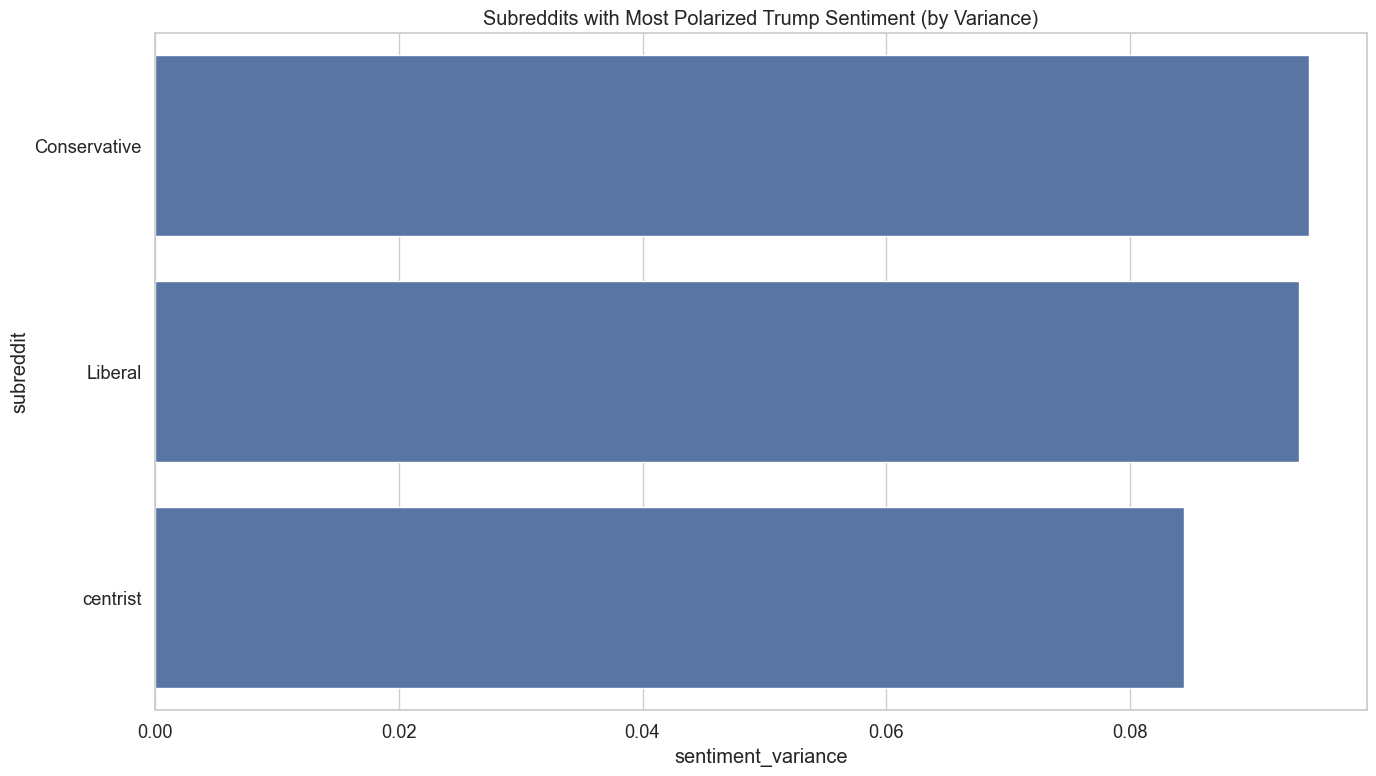

<Figure size 1800x1000 with 0 Axes>

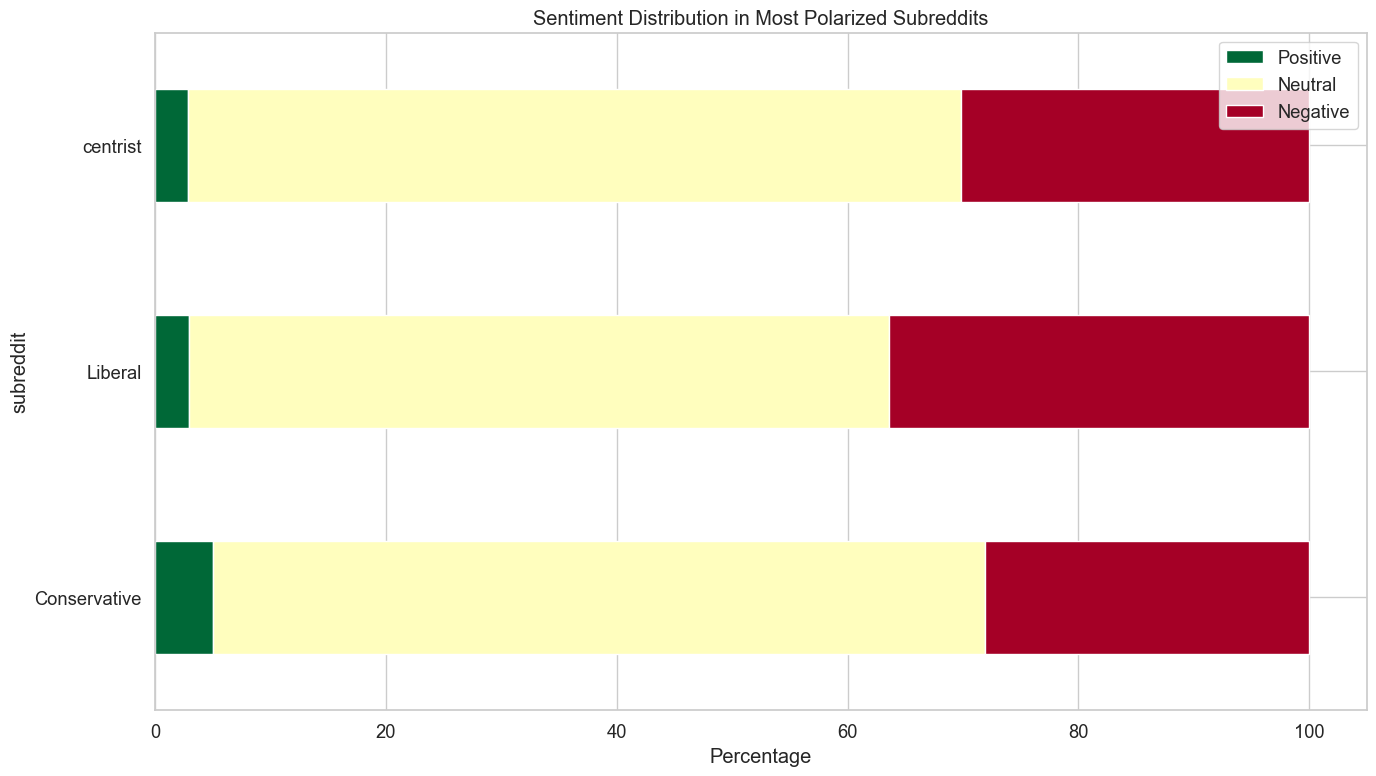


Running polarization analysis for comments...

===== Subreddit Polarization Analysis =====

Top subreddits by sentiment variance (most polarized):
      subreddit   count  sentiment_variance
1  Conservative   50391            0.111037
2       Liberal    8258            0.095955
0      centrist  102338            0.089141

Top subreddits by polarity ratio (strongest opinions):
      subreddit   count  polarity_ratio  neu_percentage
2       Liberal    8258        1.485104       40.239767
0      centrist  102338        1.304495       43.393461
1  Conservative   50391        1.073789       48.220912

Top subreddits by sentiment extremity (biggest gap between positive and negative):
      subreddit   count  sentiment_extremity  pos_percentage  neg_percentage
2       Liberal    8258            53.487527        3.136353       56.623880
0      centrist  102338            51.091481        2.757529       53.849010
1  Conservative   50391            38.808517        6.485285       45.293802


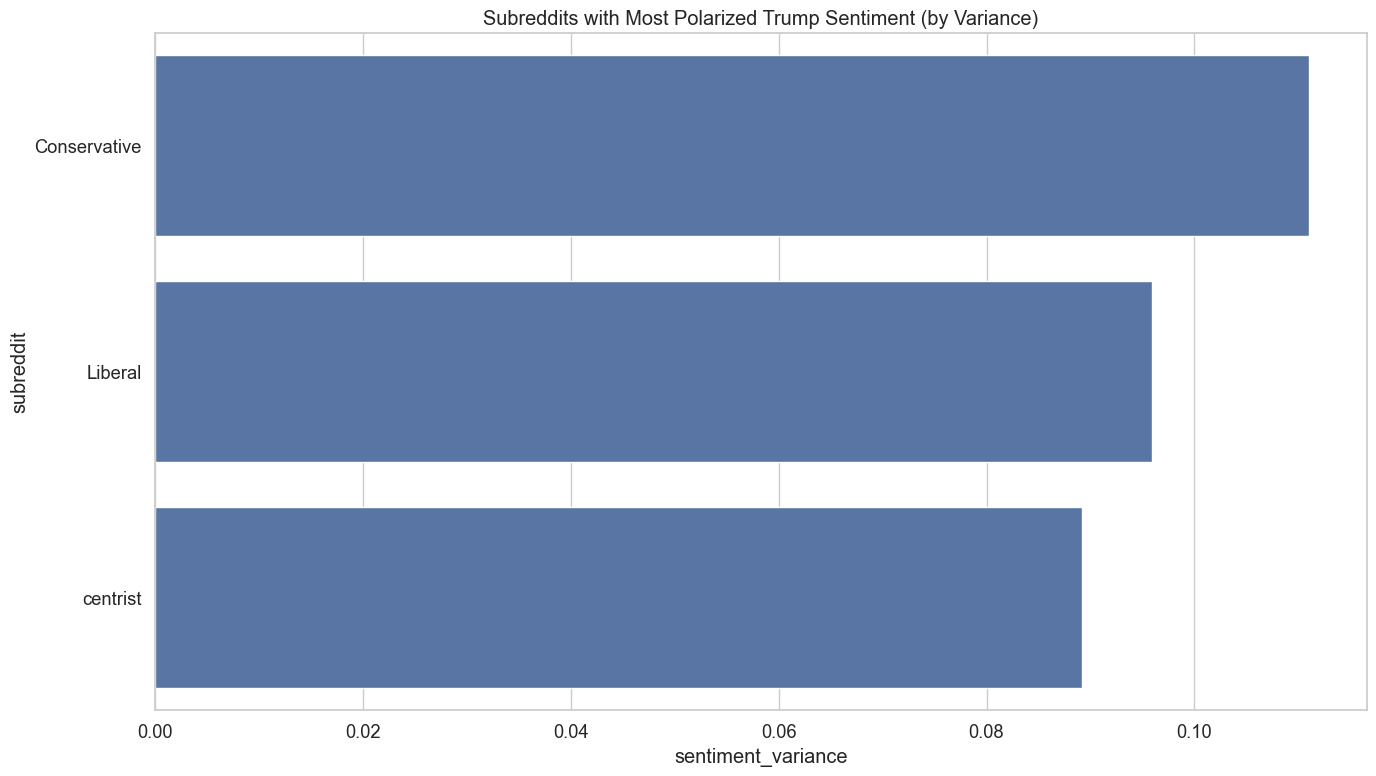

<Figure size 1800x1000 with 0 Axes>

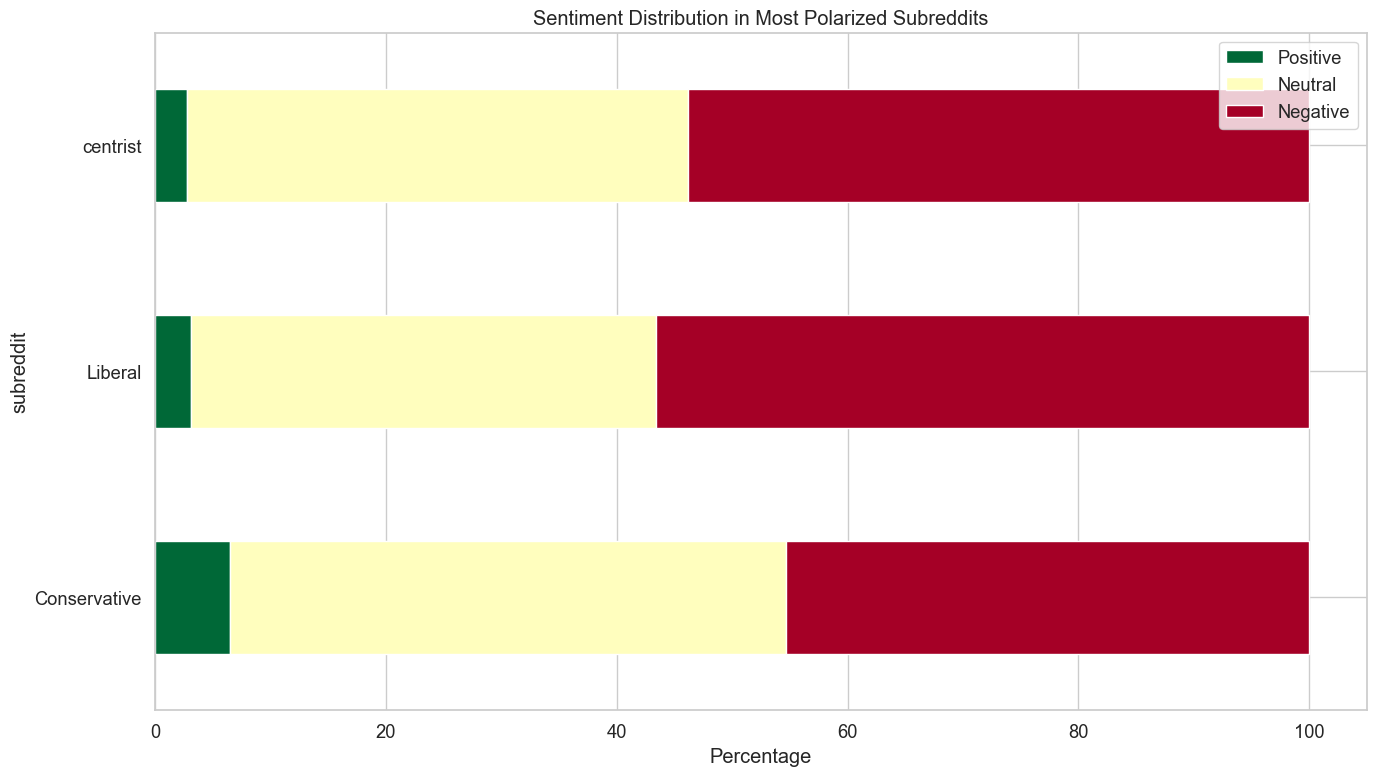


Running temporal analysis for posts...

===== Temporal Analysis of Trump Sentiment =====


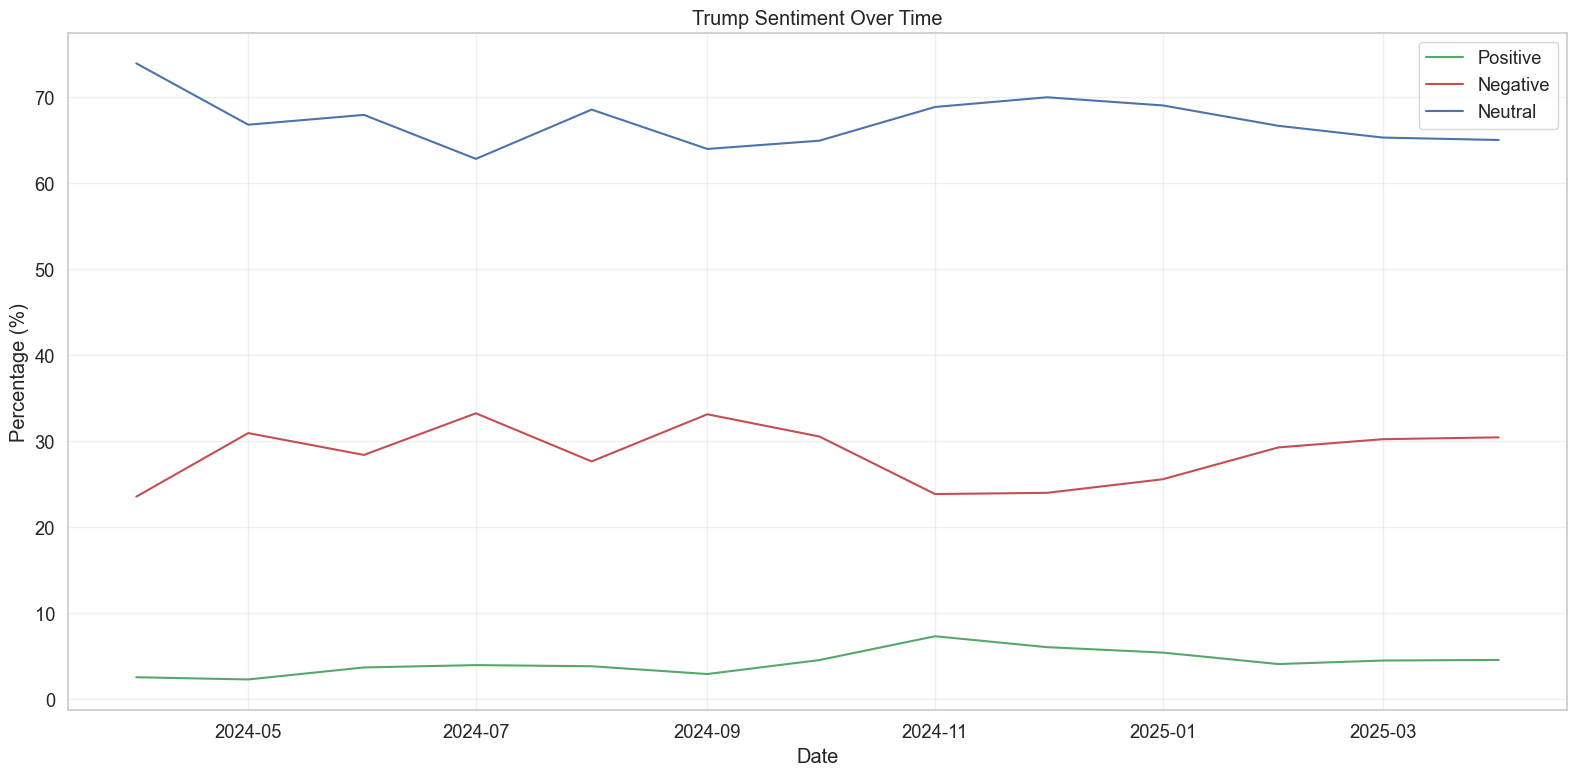

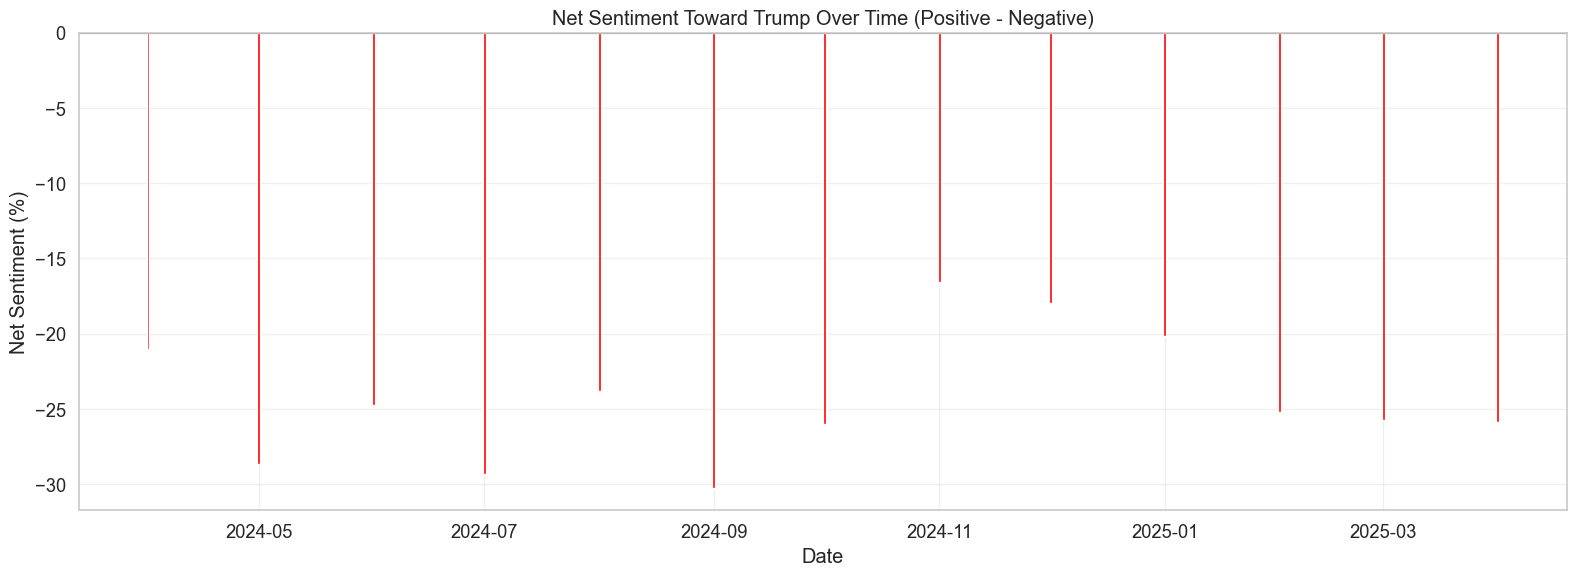

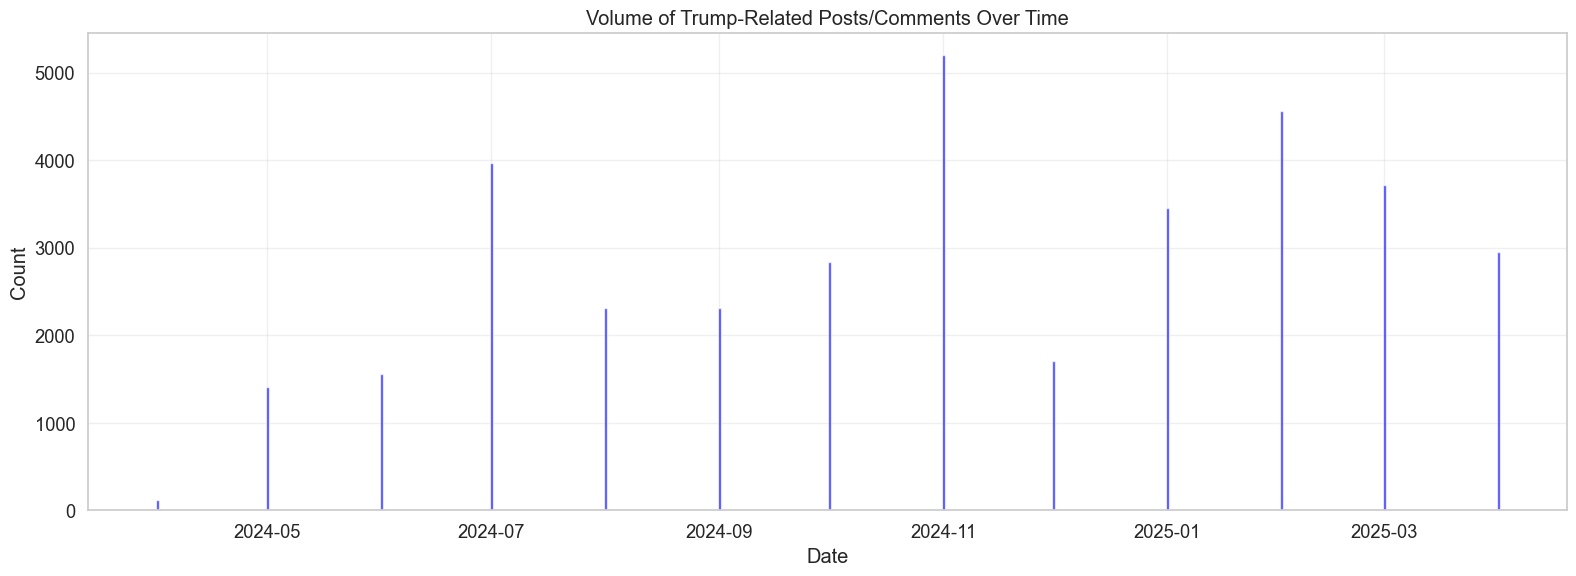


Running temporal analysis for comments...

===== Temporal Analysis of Trump Sentiment =====


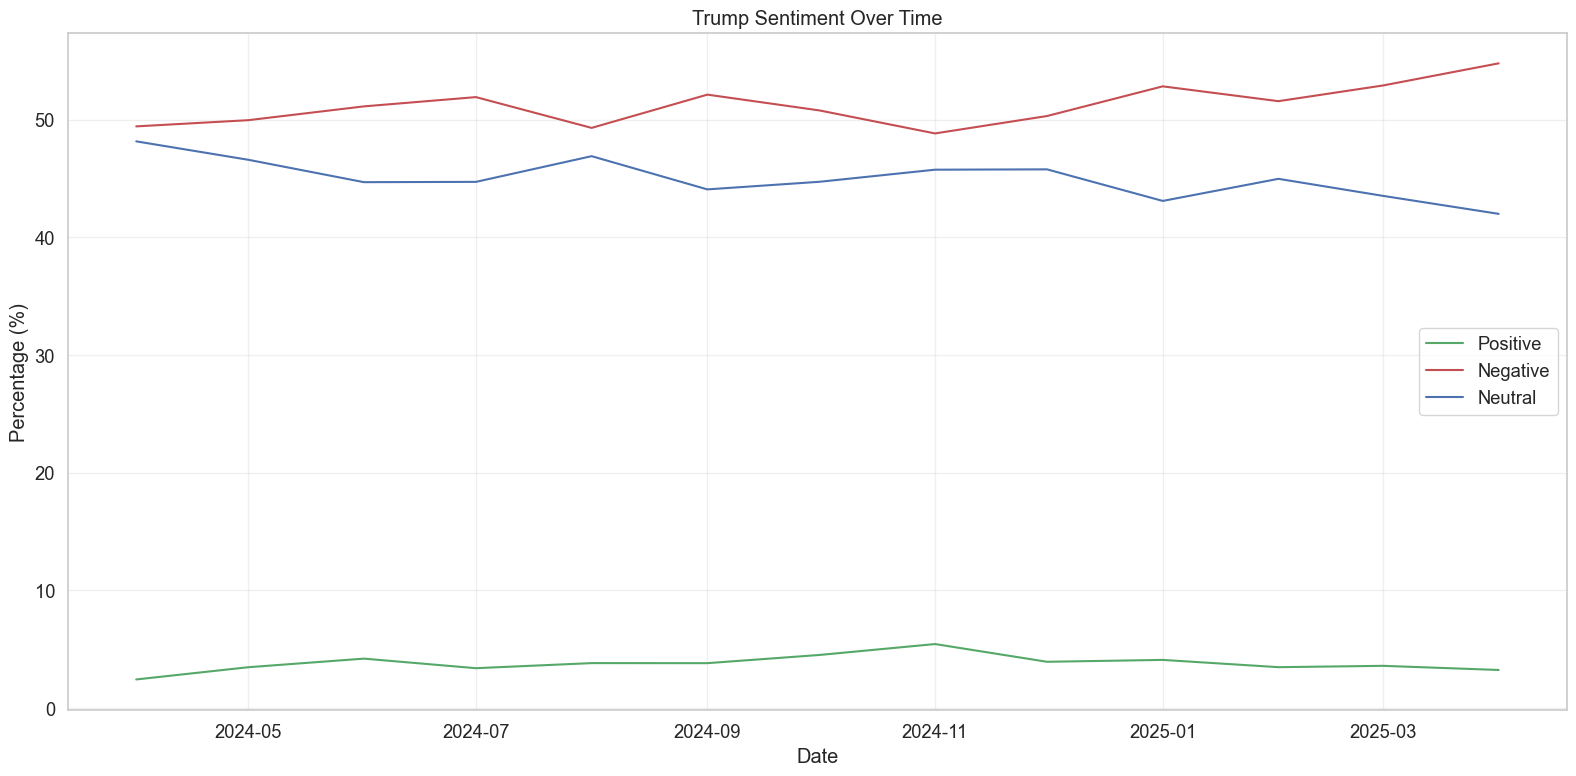

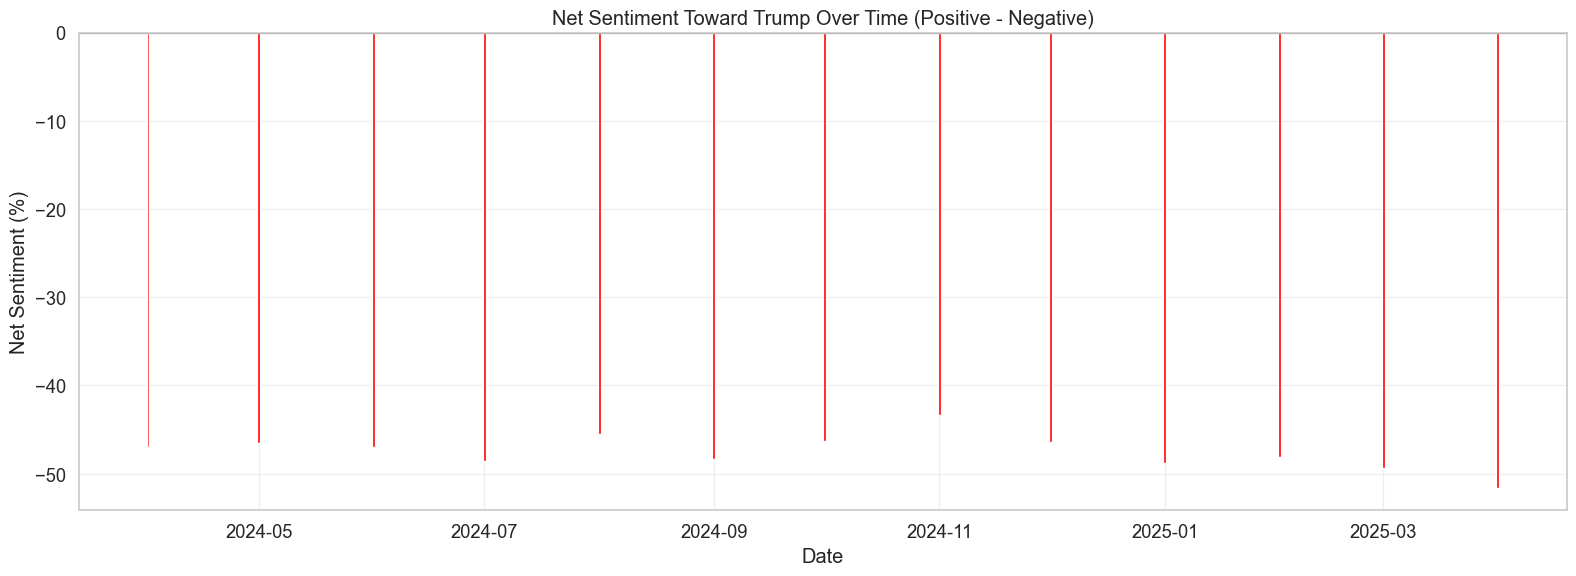

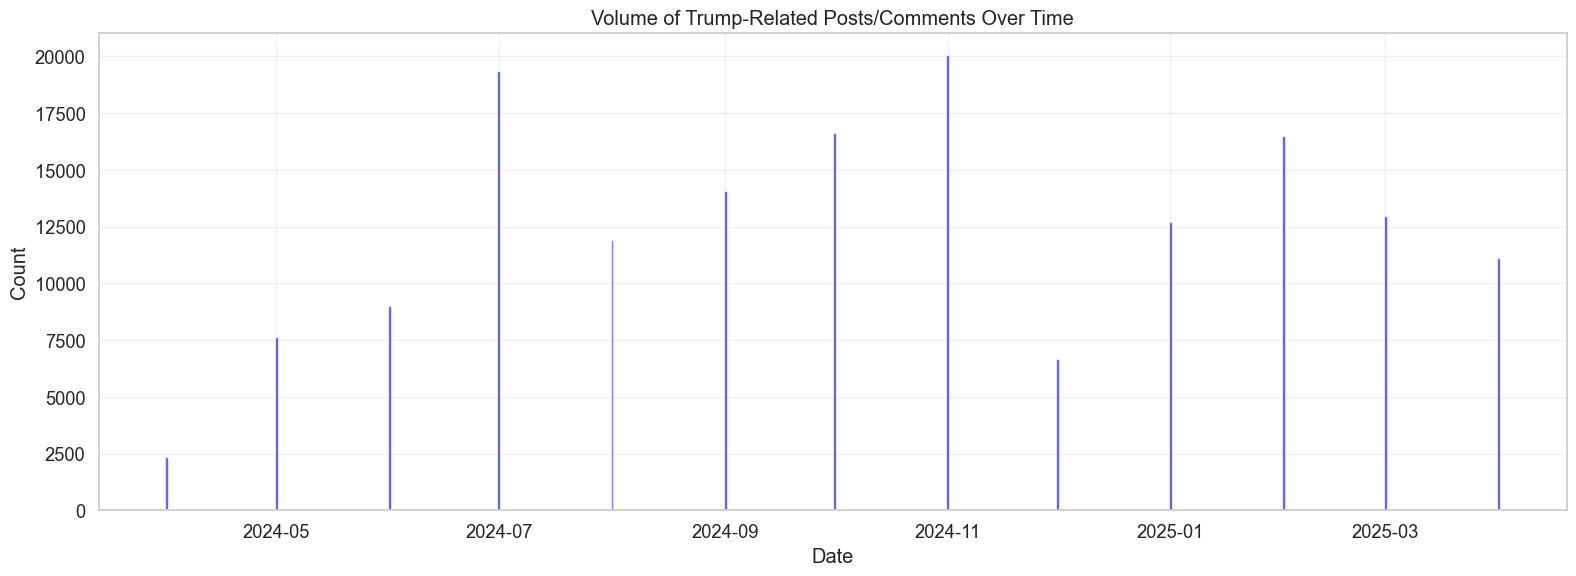


Running topic analysis for posts...

===== Key Topics Analysis by Sentiment =====

-- POSITIVE Sentiment (1684 texts) --
Top POSITIVE terms:
  win: 0.0397
  great: 0.0391
  president: 0.0369
  good: 0.0359
  donald: 0.0350
  love: 0.0323
  america: 0.0315
  make: 0.0299
  best: 0.0223
  support: 0.0157
  victory: 0.0151
  new: 0.0143
  thing: 0.0136
  american: 0.0135
  day: 0.0134

-- NEUTRAL Sentiment (23943 texts) --
Top NEUTRAL terms:
  donald: 0.0328
  say: 0.0228
  biden: 0.0224
  president: 0.0217
  harris: 0.0188
  tariff: 0.0185
  maga: 0.0176
  new: 0.0148
  kamala: 0.0142
  election: 0.0138
  win: 0.0135
  vote: 0.0131
  order: 0.0110
  think: 0.0110
  rally: 0.0107

-- NEGATIVE Sentiment (10385 texts) --
Top NEGATIVE terms:
  donald: 0.0240
  biden: 0.0188
  say: 0.0180
  democrat: 0.0164
  people: 0.0163
  president: 0.0158
  supporter: 0.0158
  assassination: 0.0138
  harris: 0.0136
  election: 0.0127
  maga: 0.0126
  like: 0.0126
  tariff: 0.0125
  attempt: 0.0119
  vot

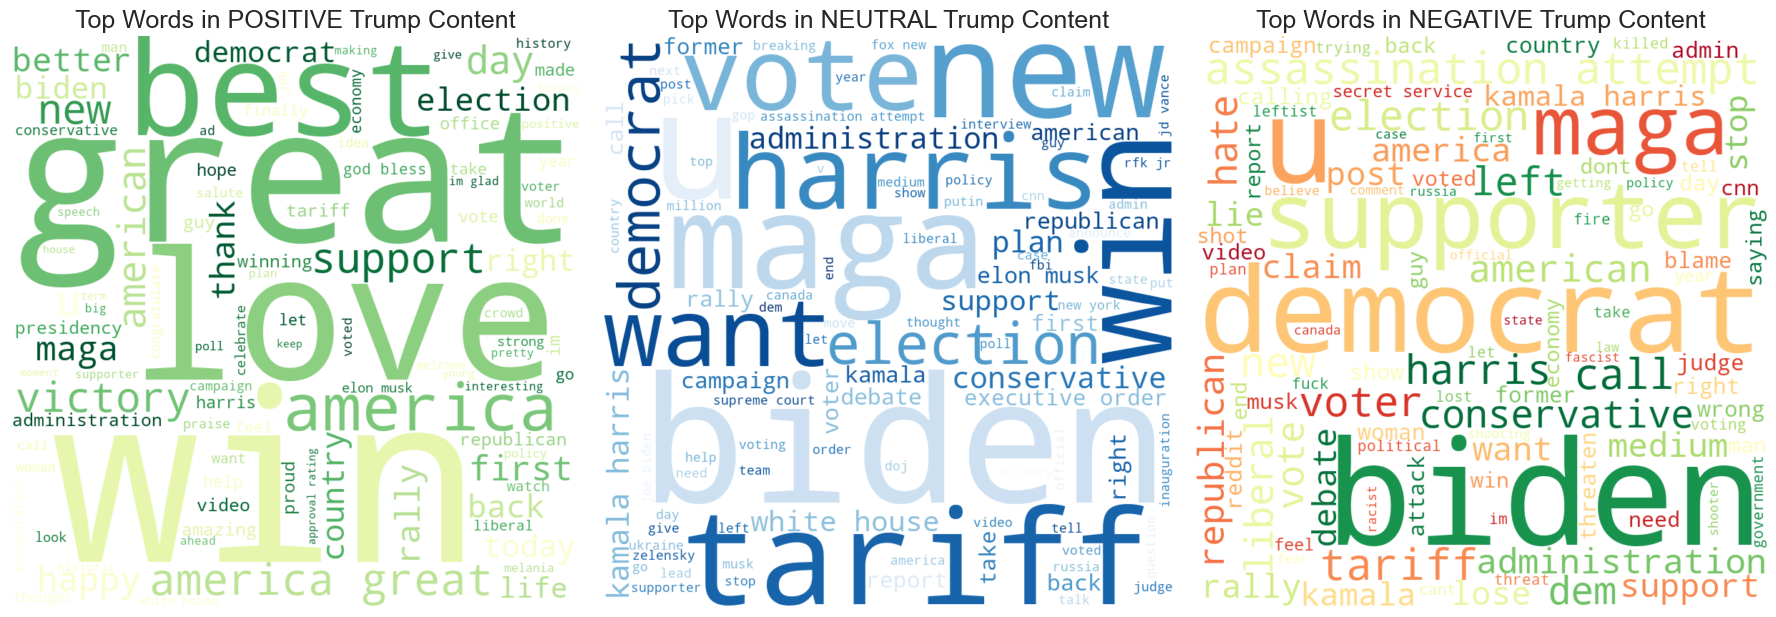


Comparing terms across sentiment categories...

Shared terms across sentiments (24):
  vote: Pos=0.0088, Neg=0.0110
  people: Pos=0.0117, Neg=0.0163
  musk: Pos=0.0076, Neg=0.0069
  like: Pos=0.0078, Neg=0.0126
  rally: Pos=0.0100, Neg=0.0092
  say: Pos=0.0105, Neg=0.0180
  president: Pos=0.0369, Neg=0.0158
  election: Pos=0.0087, Neg=0.0127
  new: Pos=0.0143, Neg=0.0077
  tariff: Pos=0.0080, Neg=0.0125
  american: Pos=0.0135, Neg=0.0093
  harris: Pos=0.0086, Neg=0.0136
  going: Pos=0.0099, Neg=0.0069
  democrat: Pos=0.0082, Neg=0.0164
  america: Pos=0.0315, Neg=0.0080

Distinctively positive terms (26):
  big: 0.0086
  state: 0.0086
  winning: 0.0080
  god: 0.0097
  thank: 0.0093
  better: 0.0096
  country: 0.0084
  great: 0.0391
  glad: 0.0089
  victory: 0.0151
  amazing: 0.0089
  today: 0.0093
  good: 0.0359
  presidency: 0.0078
  best: 0.0223

Distinctively negative terms (26):
  medium: 0.0085
  voting: 0.0070
  left: 0.0097
  voter: 0.0112
  fuck: 0.0071
  dems: 0.0078
  republi

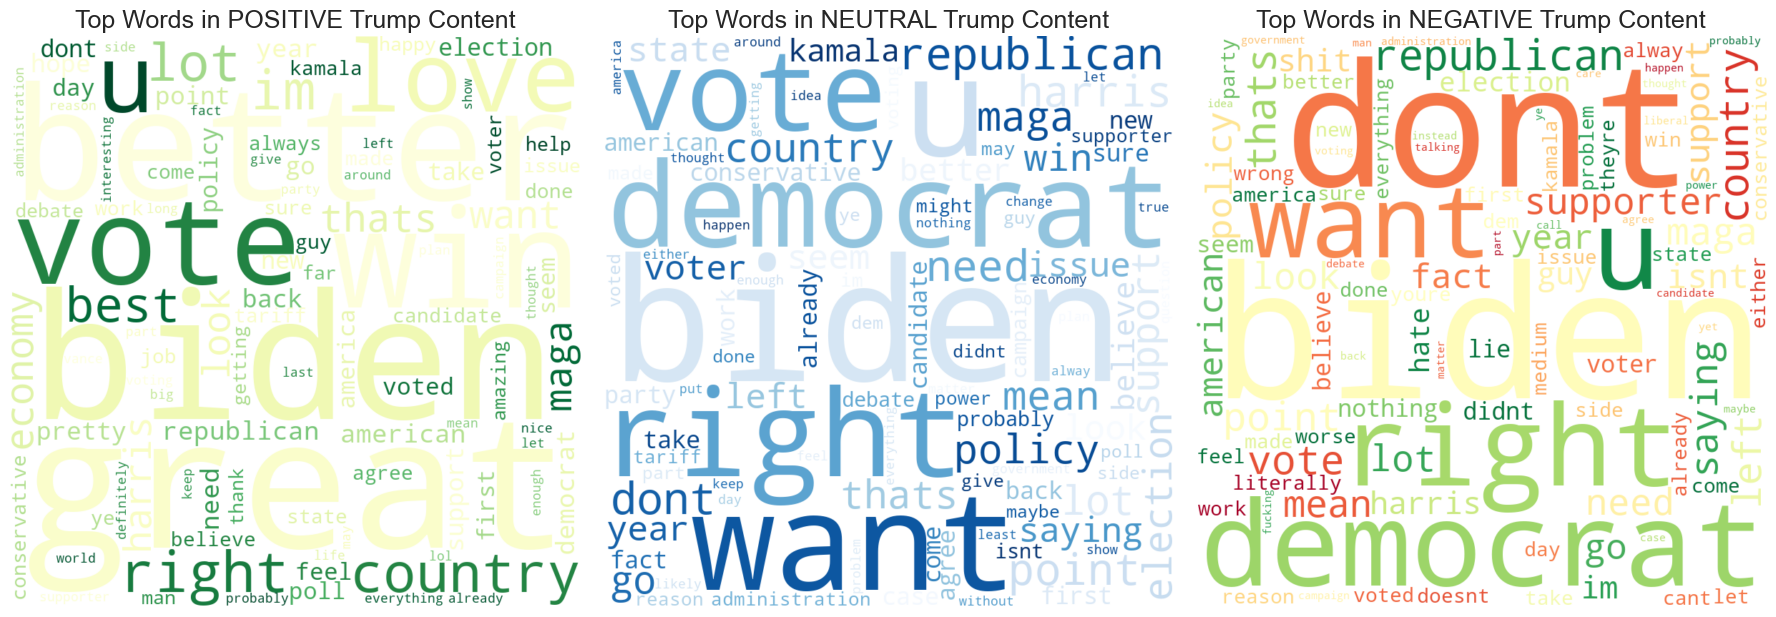


Comparing terms across sentiment categories...

Shared terms across sentiments (34):
  vote: Pos=0.0218, Neg=0.0215
  people: Pos=0.0264, Neg=0.0453
  know: Pos=0.0147, Neg=0.0214
  like: Pos=0.0282, Neg=0.0382
  say: Pos=0.0132, Neg=0.0213
  way: Pos=0.0142, Neg=0.0163
  country: Pos=0.0149, Neg=0.0163
  president: Pos=0.0255, Neg=0.0181
  republican: Pos=0.0128, Neg=0.0185
  election: Pos=0.0139, Neg=0.0191
  said: Pos=0.0116, Neg=0.0192
  american: Pos=0.0119, Neg=0.0135
  good: Pos=0.0471, Neg=0.0117
  want: Pos=0.0128, Neg=0.0221
  harris: Pos=0.0139, Neg=0.0134

Distinctively positive terms (16):
  better: 0.0256
  state: 0.0120
  job: 0.0123
  great: 0.0345
  best: 0.0188
  sure: 0.0118
  love: 0.0261
  america: 0.0179
  day: 0.0123
  yes: 0.0123
  hope: 0.0132
  win: 0.0258
  voted: 0.0124
  pretty: 0.0156
  economy: 0.0131

Distinctively negative terms (16):
  medium: 0.0123
  shit: 0.0161
  doesnt: 0.0137
  youre: 0.0118
  didnt: 0.0133
  policy: 0.0127
  saying: 0.0135
  su

<Figure size 1400x800 with 0 Axes>

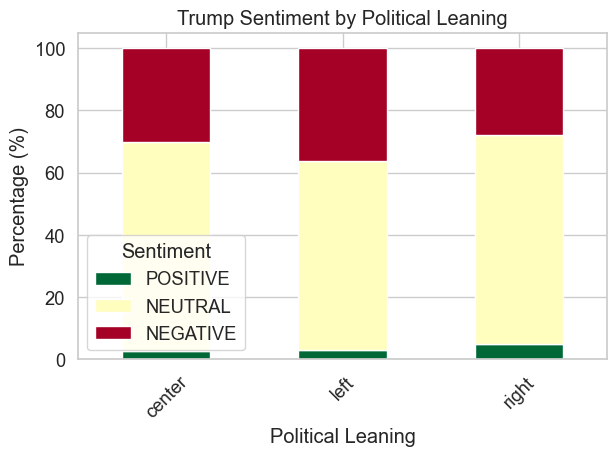

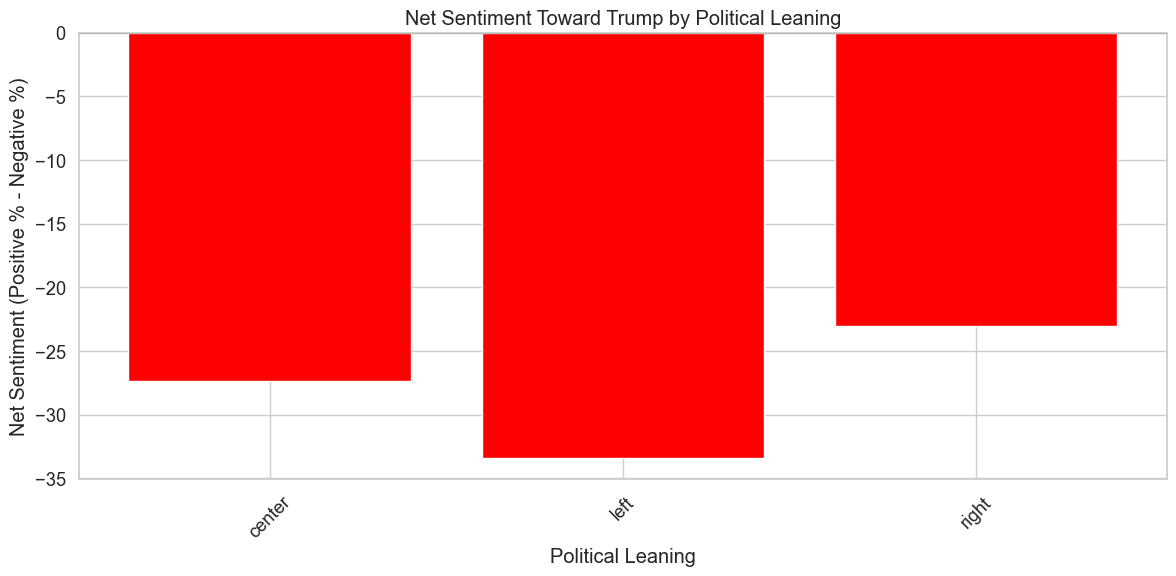


Running political leaning analysis for comments...

===== Political Leaning vs. Trump Sentiment Analysis =====
Found 160987 posts/comments from subreddits with identified political leaning
Political leaning distribution:
political_leaning
center    102338
right      50391
left        8258
Name: count, dtype: int64

Sentiment distribution by political leaning (%):
body_processed_roberta_sentiment  NEGATIVE  NEUTRAL  POSITIVE
political_leaning                                            
center                               53.85    43.39      2.76
left                                 56.62    40.24      3.14
right                                45.29    48.22      6.49


<Figure size 1400x800 with 0 Axes>

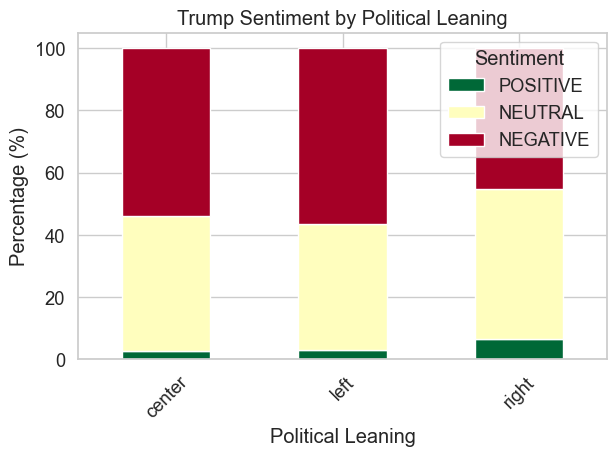

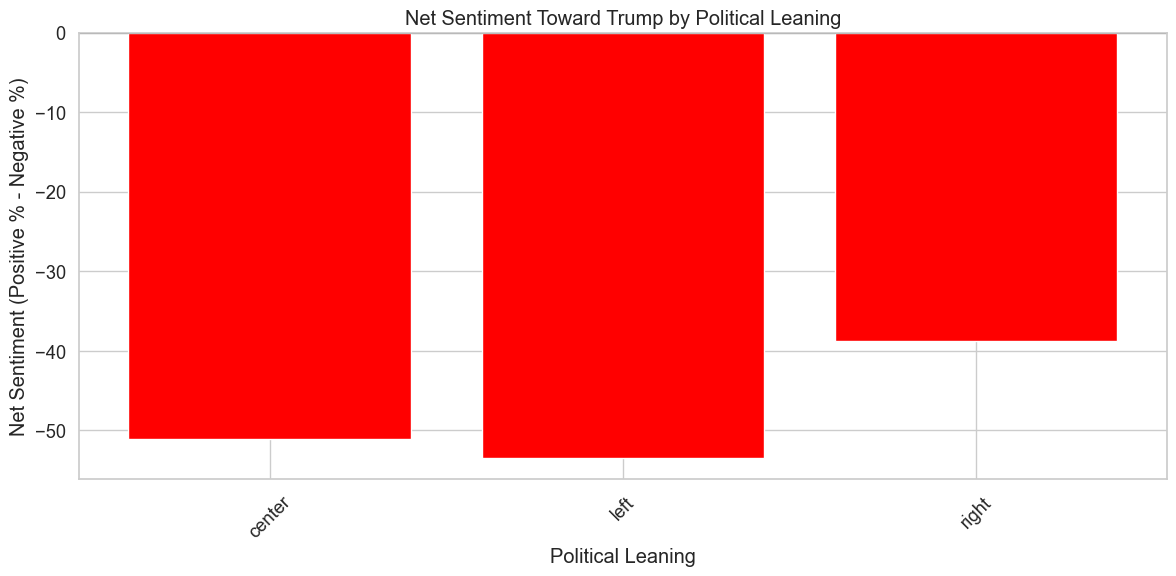


Running network analysis for posts...

===== Subreddit Sentiment Network Analysis =====
Analyzing 3 subreddits with at least 20 posts/comments
Created network with 3 nodes and 3 edges
Network modularity: -0.0000
Found 1 communities in the network


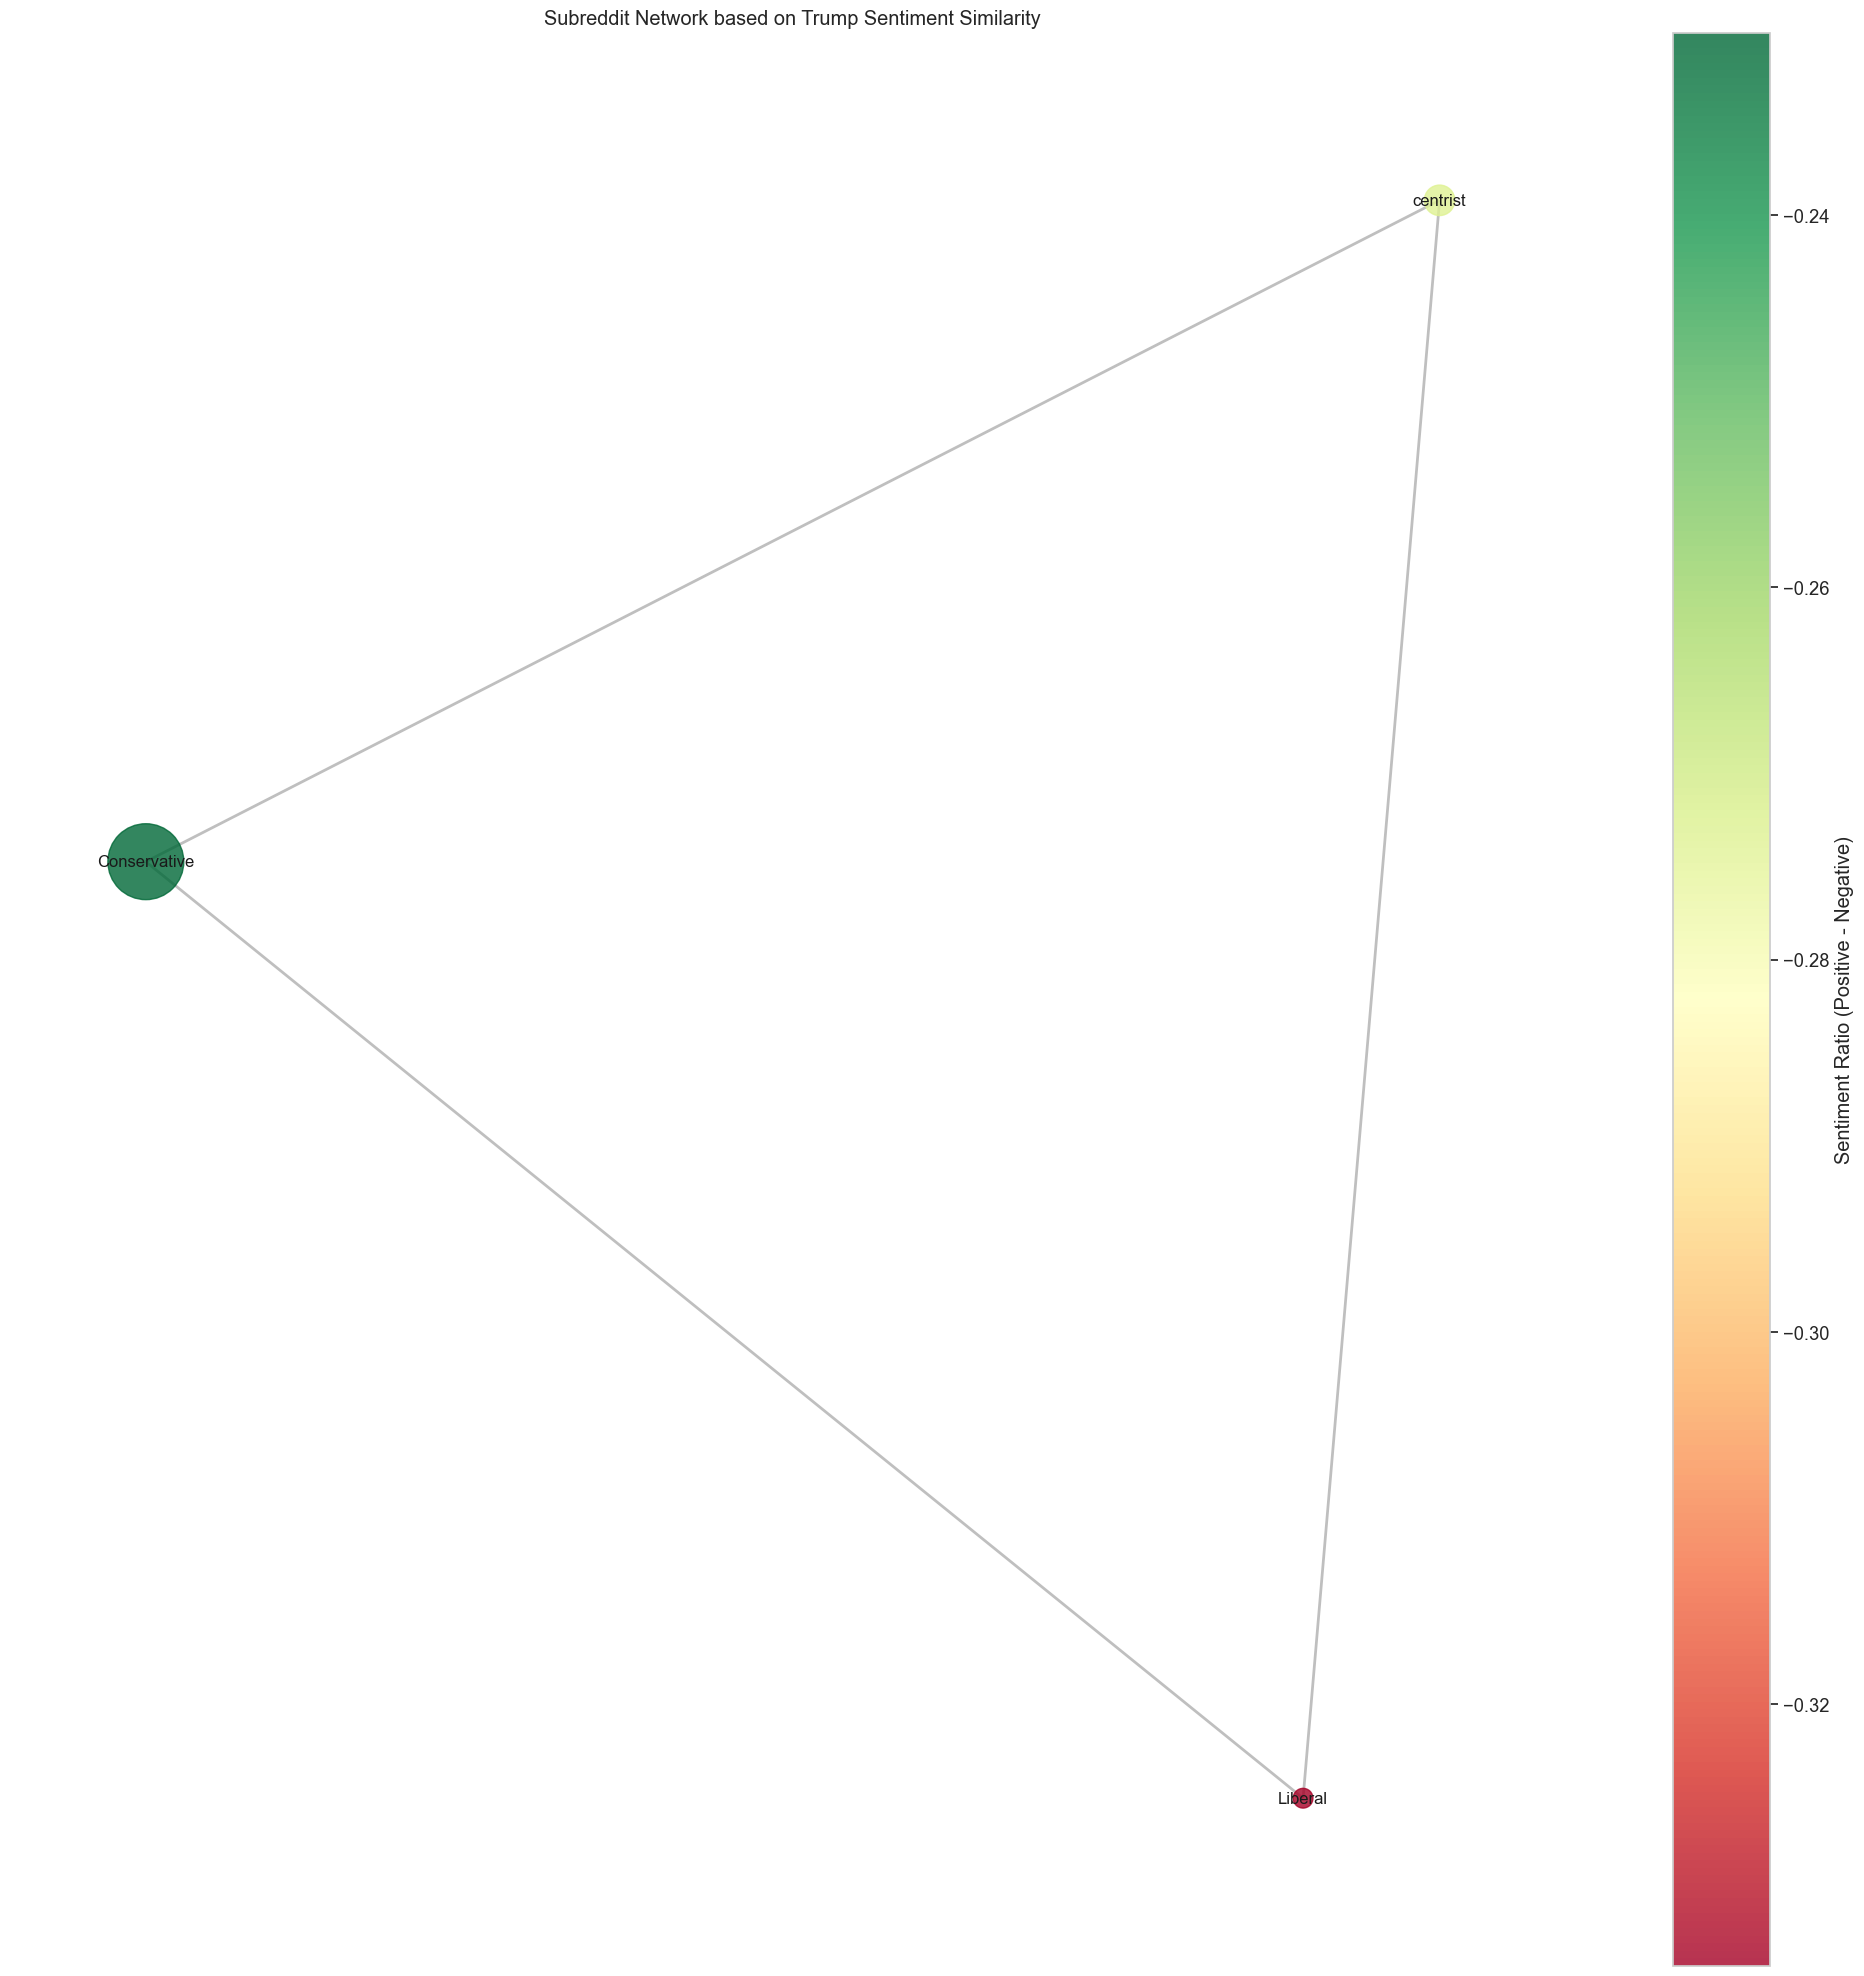


===== ADDITIONAL INSIGHTS =====

===== COMPREHENSIVE TRUMP SENTIMENT INSIGHTS =====

1. OVERALL SENTIMENT SUMMARY
----------------------------
Analysis of 36111 Trump-related posts and 160987 comments

Post Sentiment Distribution:
  NEUTRAL: 66.6%
  NEGATIVE: 28.8%
  POSITIVE: 4.7%

Comment Sentiment Distribution:
  NEGATIVE: 51.3%
  NEUTRAL: 44.7%
  POSITIVE: 3.9%

Posts Positive-to-Negative Ratio: 0.16
Comments Positive-to-Negative Ratio: 0.08
Posts Net Sentiment: -24.1%
Comments Net Sentiment: -47.4%

2. SUBREDDIT ANALYSIS
--------------------

Top 10 Subreddits by Trump-related Post Volume:
  Conservative: 29680 posts, Net Sentiment: -23.0% (Negative)
  centrist: 4614 posts, Net Sentiment: -27.4% (Negative)
  Liberal: 1817 posts, Net Sentiment: -33.4% (Negative)

Most Pro-Trump Subreddits (with at least 20 posts):
  Conservative: Net Sentiment +-23.0% (29680 posts)
  centrist: Net Sentiment +-27.4% (4614 posts)
  Liberal: Net Sentiment +-33.4% (1817 posts)

Most Anti-Trump Subredd

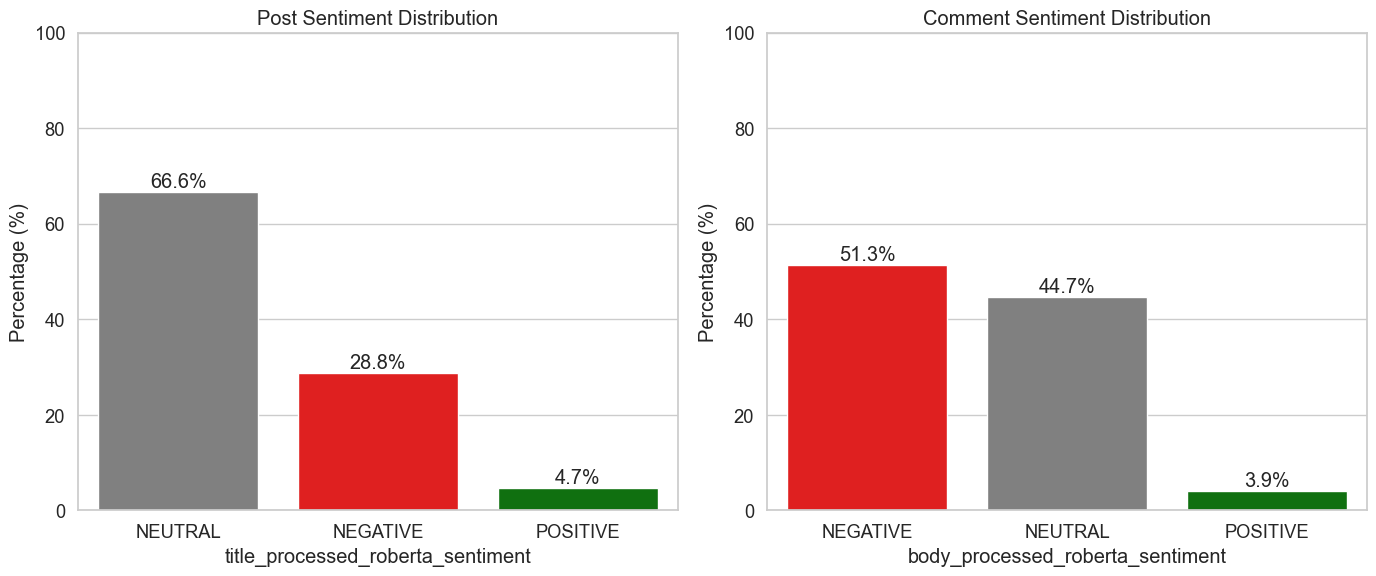

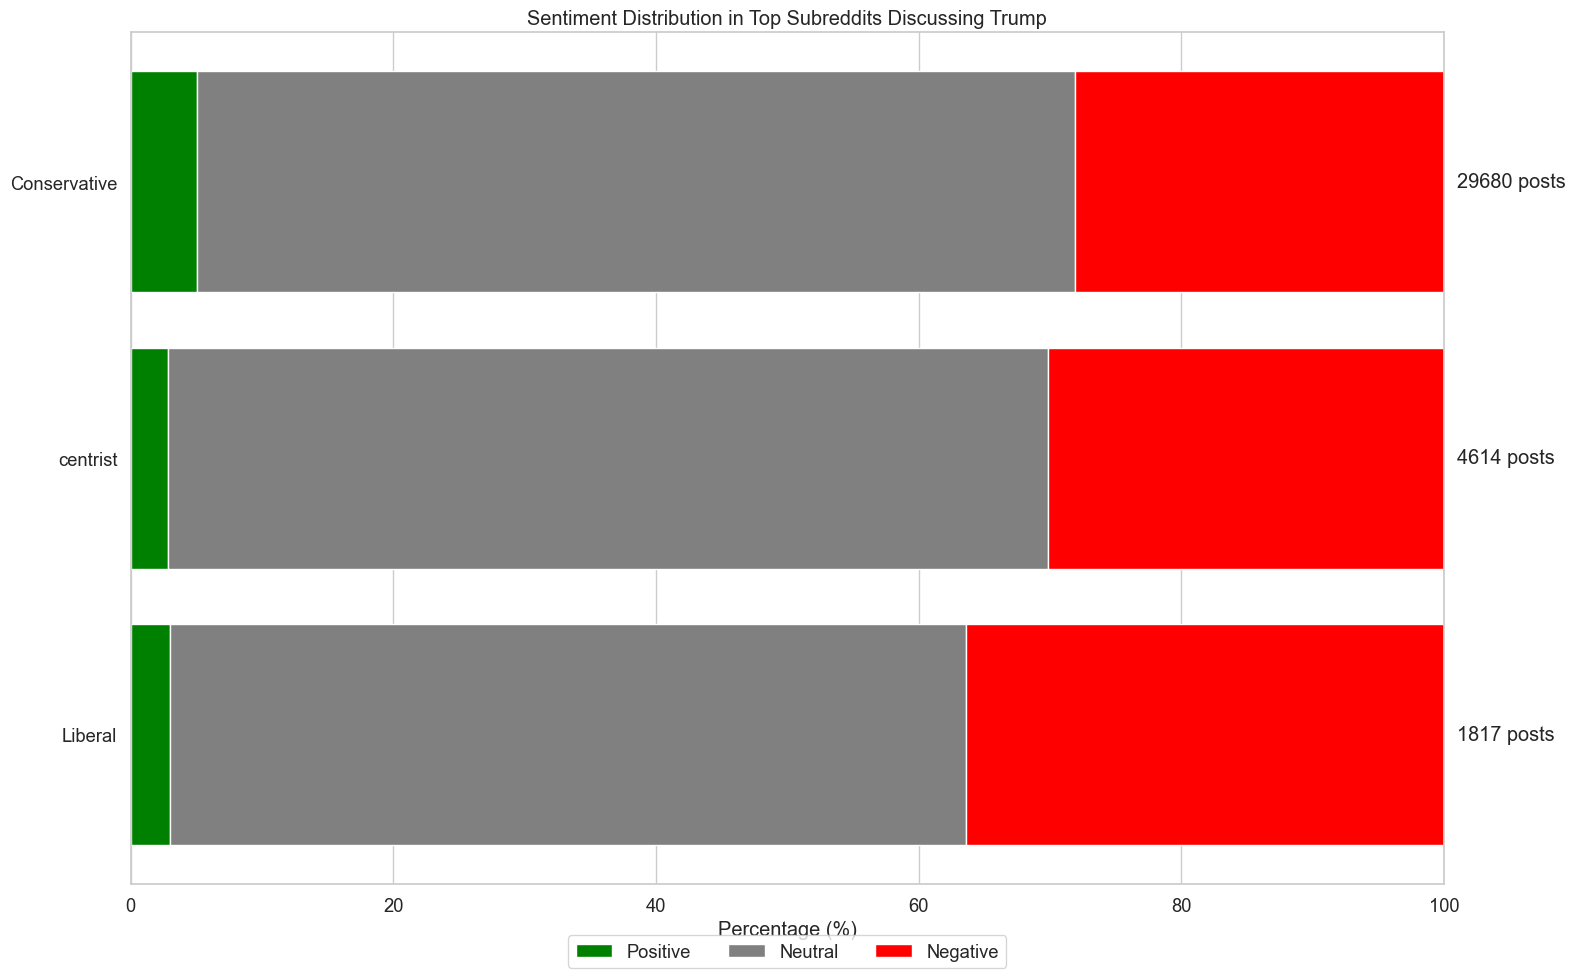

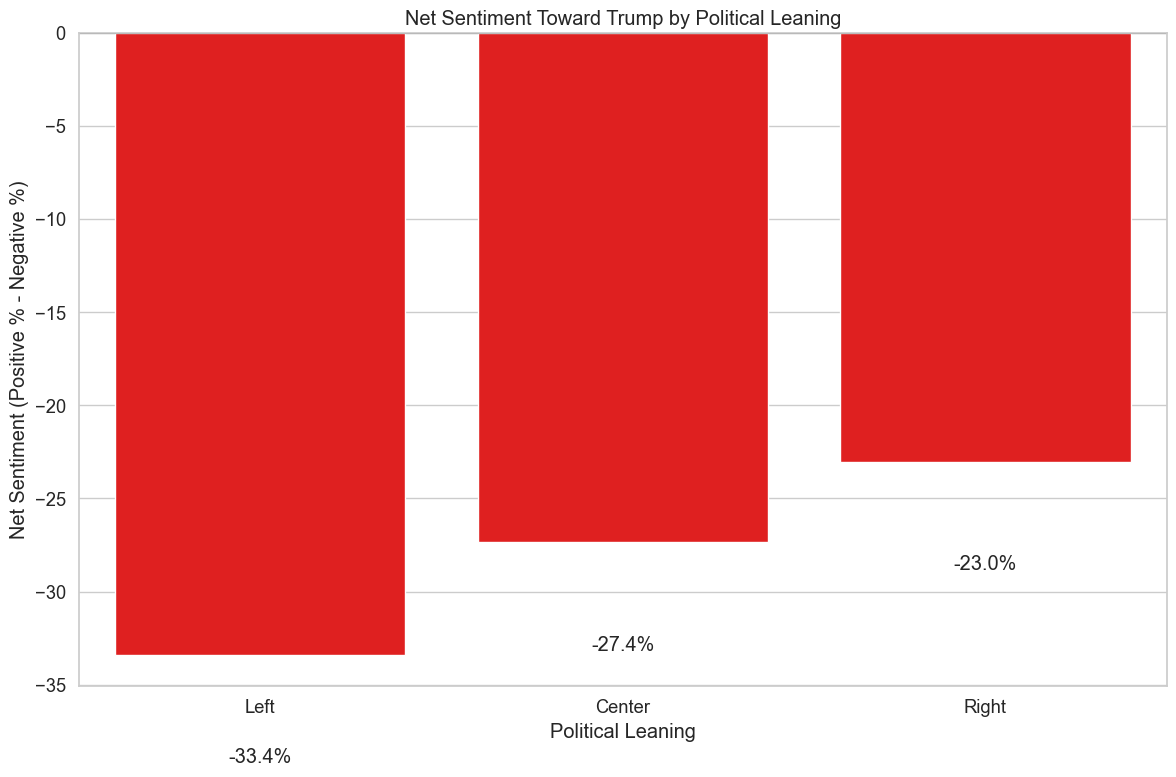


Analysis complete! The insights above provide a comprehensive view of Trump sentiment across Reddit subreddits.


In [130]:
result = run_all_analyses(trump_posts_df, trump_comments_df)

# Sentiment vs Events

In [125]:
def plot_sentiment_comparison_graphs_with_events(posts_df, comments_df, posts_sentiment_prefix, 
                                               comments_sentiment_prefix, events_list,
                                               time_interval='M', min_posts=10, min_comments=20, top_n=8):
    """
    Create two comparative line graphs with improved event annotations:
    1. One for posts across top subreddits
    2. One for comments across top subreddits
    
    Parameters:
    -----------
    posts_df : DataFrame
        DataFrame with Trump-related posts and sentiment analysis
    comments_df : DataFrame
        DataFrame with Trump-related comments and sentiment analysis
    posts_sentiment_prefix : str
        Prefix for RoBERTa sentiment columns in posts (e.g., 'title_processed_')
    comments_sentiment_prefix : str
        Prefix for RoBERTa sentiment columns in comments (e.g., 'body_processed_')
    events_list : list of tuples
        List of events as (date, label, importance) where date is a datetime,
        label is the event name, and importance is a value 1-3 (for annotation size)
    time_interval : str
        Time interval for grouping ('D' for daily, 'W' for weekly, 'M' for monthly, 'Q' for quarterly)
    min_posts : int
        Minimum number of posts required per subreddit per time period
    min_comments : int
        Minimum number of comments required per subreddit per time period
    top_n : int
        Number of top subreddits to include in each visualization
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from matplotlib.lines import Line2D
    from matplotlib.ticker import MaxNLocator
    import matplotlib.dates as mdates
    from datetime import datetime, timedelta
    from matplotlib.patches import Rectangle
    
    # Get all subreddits from both dataframes to ensure consistent colors
    posts_subreddits = posts_df['subreddit'].value_counts().head(top_n).index.tolist()
    comments_subreddits = comments_df['subreddit'].value_counts().head(top_n).index.tolist()
    
    # Combine and deduplicate
    all_subreddits = list(dict.fromkeys(posts_subreddits + comments_subreddits))
    
    # Create a consistent color mapping for all subreddits
    subreddit_colors = {}
    palette = sns.color_palette("tab10", n_colors=len(all_subreddits))
    
    for i, subreddit in enumerate(all_subreddits):
        subreddit_colors[subreddit] = palette[i]
    
    print(f"Color mapping for {len(all_subreddits)} unique subreddits")
    
    # Function to prepare data
    def prepare_trend_data(df, sentiment_prefix, data_type, min_items):
        # Check if created_utc column exists
        if 'created_utc' not in df.columns:
            print(f"Error: 'created_utc' column not found in the {data_type} DataFrame")
            return None
        
        # Convert Unix timestamp to datetime
        df['created_date'] = pd.to_datetime(df['created_utc'], unit='s')
        
        # Get sentiment label column
        sentiment_label_col = f"{sentiment_prefix}roberta_sentiment"
        
        # Group by time interval
        df['time_period'] = df['created_date'].dt.to_period(time_interval)
        
        # Identify top subreddits by count
        subreddit_counts = df['subreddit'].value_counts()
        top_subreddits = subreddit_counts.head(top_n).index.tolist()
        
        print(f"Top {len(top_subreddits)} subreddits for {data_type}: {', '.join(top_subreddits)}")
        
        # Calculate sentiment over time for each subreddit
        subreddit_trends = {}
        
        for subreddit in top_subreddits:
            subreddit_df = df[df['subreddit'] == subreddit]
            
            # Group by time period
            period_groups = subreddit_df.groupby('time_period')
            
            # Calculate metrics for each period
            trends = []
            for period, group in period_groups:
                if len(group) >= min_items:  # Only include periods with enough items
                    # Calculate sentiment percentages
                    sentiment_counts = group[sentiment_label_col].value_counts(normalize=True).to_dict()
                    pos_pct = sentiment_counts.get('POSITIVE', 0) * 100
                    neg_pct = sentiment_counts.get('NEGATIVE', 0) * 100
                    
                    # Calculate net sentiment
                    net_sentiment = pos_pct - neg_pct
                    
                    # Add to trends
                    trends.append({
                        'period': period,
                        'period_start': period.start_time,
                        'count': len(group),
                        'net_sentiment': net_sentiment
                    })
            
            # Create DataFrame for this subreddit
            if trends:
                subreddit_trends[subreddit] = pd.DataFrame(trends).sort_values('period_start')
        
        return subreddit_trends
    
    # Function to plot data with events
    def plot_data(ax, trend_data, data_type, events_list):
        if not trend_data:
            print(f"Not enough data to create meaningful time trends for {data_type}")
            return
            
        # Plot each subreddit's trend
        for subreddit, trend_df in trend_data.items():
            # Use the consistent color for this subreddit
            color = subreddit_colors.get(subreddit, 'gray')
            
            # Plot the trend line
            ax.plot(
                trend_df['period_start'], 
                trend_df['net_sentiment'],
                marker='o',
                linestyle='-',
                linewidth=2,
                markersize=6,
                color=color,
                label=subreddit
            )
        
        # Add reference line at 0
        ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        
        # Get current y-limits for positioning annotations
        y_min, y_max = ax.get_ylim()
        
        # Add events as vertical lines with improved annotations
        # Sort events by date to handle overlapping
        sorted_events = sorted(events_list, key=lambda x: x[0] if isinstance(x[0], datetime) else pd.to_datetime(x[0]))
        
        # Number the events for easier reference
        for i, (event_date, event_label, importance) in enumerate(sorted_events):
            # Convert string dates to datetime if needed
            if isinstance(event_date, str):
                event_date = pd.to_datetime(event_date)
                
            # Determine line style and annotation size based on importance
            line_style = '-' if importance >= 2 else '--'
            line_width = 0.8 + (importance * 0.2)
            alpha = 0.5 + (importance * 0.1)
            
            # Plot vertical line for event
            ax.axvline(x=event_date, color='purple', linestyle=line_style, 
                     alpha=alpha, linewidth=line_width)
            
            # Add small event number label at the top of the line
            # For posts (top chart), place at top; for comments (bottom chart), place at bottom
            if data_type == "posts":
                y_pos = y_max * 0.95
                va = 'top'
            else:
                y_pos = y_min * 0.95
                va = 'bottom'
                
            # Add small event number 
            ax.text(event_date, y_pos, f"{i+1}", 
                   color='purple', fontsize=9, fontweight='bold',
                   ha='center', va=va, 
                   bbox=dict(facecolor='white', alpha=0.7, edgecolor='purple', boxstyle='round,pad=0.3'))
        
        # Formatting with distinct titles for posts and comments
        if data_type == "posts":
            title = 'Net Sentiment Toward Trump in Reddit Posts by Subreddit'
        else:
            title = 'Net Sentiment Toward Trump in Reddit Comments by Subreddit'
            
        ax.set_title(title, fontsize=16, fontweight='bold')
        
        if data_type == "comments":  # Only add x-label for the bottom plot
            ax.set_xlabel('Date', fontsize=12)
        ax.set_ylabel('Net Sentiment (Positive % - Negative %)', fontsize=12)
        ax.grid(True, alpha=0.3)
        
        # Set y-axis to be symmetric around 0 for easier comparison
        y_max = max(abs(ax.get_ylim()[0]), abs(ax.get_ylim()[1]))
        ax.set_ylim(-y_max, y_max)
        
        # Make y-axis have reasonable number of ticks
        ax.yaxis.set_major_locator(MaxNLocator(nbins=8, prune='both'))
        
        # Improve x-axis formatting
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
        
        # Add legend with better placement
        if data_type == "posts":  # Only add legend for the top plot
            handles, labels = ax.get_legend_handles_labels()
            
            # Sort handles and labels by subreddit popularity across both datasets
            combined_counts = pd.concat([
                posts_df['subreddit'].value_counts(),
                comments_df['subreddit'].value_counts()
            ]).groupby(level=0).sum().sort_values(ascending=False)
            
            # Filter to only include labels in our legend
            legend_order = [label for label in combined_counts.index if label in labels]
            
            # Reorder handles and labels
            ordered_handles = [handles[labels.index(label)] for label in legend_order if label in labels]
            
            # Add legend with ordered items
            ax.legend(ordered_handles, legend_order, loc='upper left', 
                     bbox_to_anchor=(1.01, 1), fontsize=10, title="Subreddits")
        
        return sorted_events
    
    # Create a figure with subplots and an event reference panel
    fig = plt.figure(figsize=(18, 16))
    
    # Create a gridspec for layout
    from matplotlib.gridspec import GridSpec
    gs = GridSpec(3, 1, height_ratios=[10, 10, 4], figure=fig)
    
    # Create subplots
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    events_ax = fig.add_subplot(gs[2])
    
    # Generate the visualizations
    print("\n===== Generating Sentiment Trend Comparison Graphs =====")
    
    # Prepare data for posts and comments
    print("\nProcessing Posts data...")
    posts_trends = prepare_trend_data(posts_df, posts_sentiment_prefix, "posts", min_posts)
    
    print("\nProcessing Comments data...")
    comments_trends = prepare_trend_data(comments_df, comments_sentiment_prefix, "comments", min_comments)
    
    # Plot data with events
    sorted_events = plot_data(ax1, posts_trends, "posts", events_list)
    plot_data(ax2, comments_trends, "comments", events_list)
    
    # Add an overall title    
    # Create the events reference panel with larger, bold text
    if sorted_events:
        # Hide the axis elements
        events_ax.axis('off')
        
        # Create a cleaner event reference panel
        # Title for events section
        events_ax.text(0.5, 0.95, 'Significant Events Timeline (Referenced by Numbers in Graphs)', 
                     ha='center', va='top', fontsize=16, fontweight='bold')
        
        # Number of columns for the event grid
        n_cols = 3  # Number of columns
        n_events = len(sorted_events)
        n_rows = int(np.ceil(n_events / n_cols))
        
        # Width and height of each cell
        cell_width = 1.0 / n_cols
        cell_height = 0.9 / n_rows  # Leave room for title
        
        # Create the event grid with larger, bold text
        for i, (event_date, event_label, importance) in enumerate(sorted_events):
            # Convert string dates to datetime if needed
            if isinstance(event_date, str):
                event_date = pd.to_datetime(event_date)
                
            # Calculate grid position
            row = i // n_cols
            col = i % n_cols
            
            # Calculate position
            x = col * cell_width + 0.02
            y = 0.9 - ((row + 1) * cell_height) + 0.05  # Start from top
            
            # Format date
            date_str = event_date.strftime('%b %d, %Y')
            
            # Add event number with circle
            events_ax.text(x, y + 0.02, f"{i+1}", fontsize=12, fontweight='bold',
                        ha='left', va='center', color='purple',
                        bbox=dict(facecolor='white', edgecolor='purple', boxstyle='circle'))
            
            # Add event information with larger, bold text
            events_ax.text(x + 0.04, y + 0.02, f"{date_str}: {event_label}", 
                        fontsize=12, fontweight='bold', ha='left', va='center')
            
            # Add importance indicators using stars
            stars = '★' * importance
            events_ax.text(x + 0.04, y - 0.01, stars, fontsize=10, ha='left', va='center', color='purple')
    
    # Set axis limits for the events panel
    events_ax.set_xlim(0, 1)
    events_ax.set_ylim(0, 1)
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Make room for suptitle
    
    # Save the figure
    plt.savefig('trump_sentiment_comparison_with_events_grid.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    
    return {
        'posts_trends': posts_trends,
        'comments_trends': comments_trends
    }

Color mapping for 3 unique subreddits

===== Generating Sentiment Trend Comparison Graphs =====

Processing Posts data...
Top 3 subreddits for posts: Conservative, centrist, Liberal

Processing Comments data...
Top 3 subreddits for comments: centrist, Conservative, Liberal


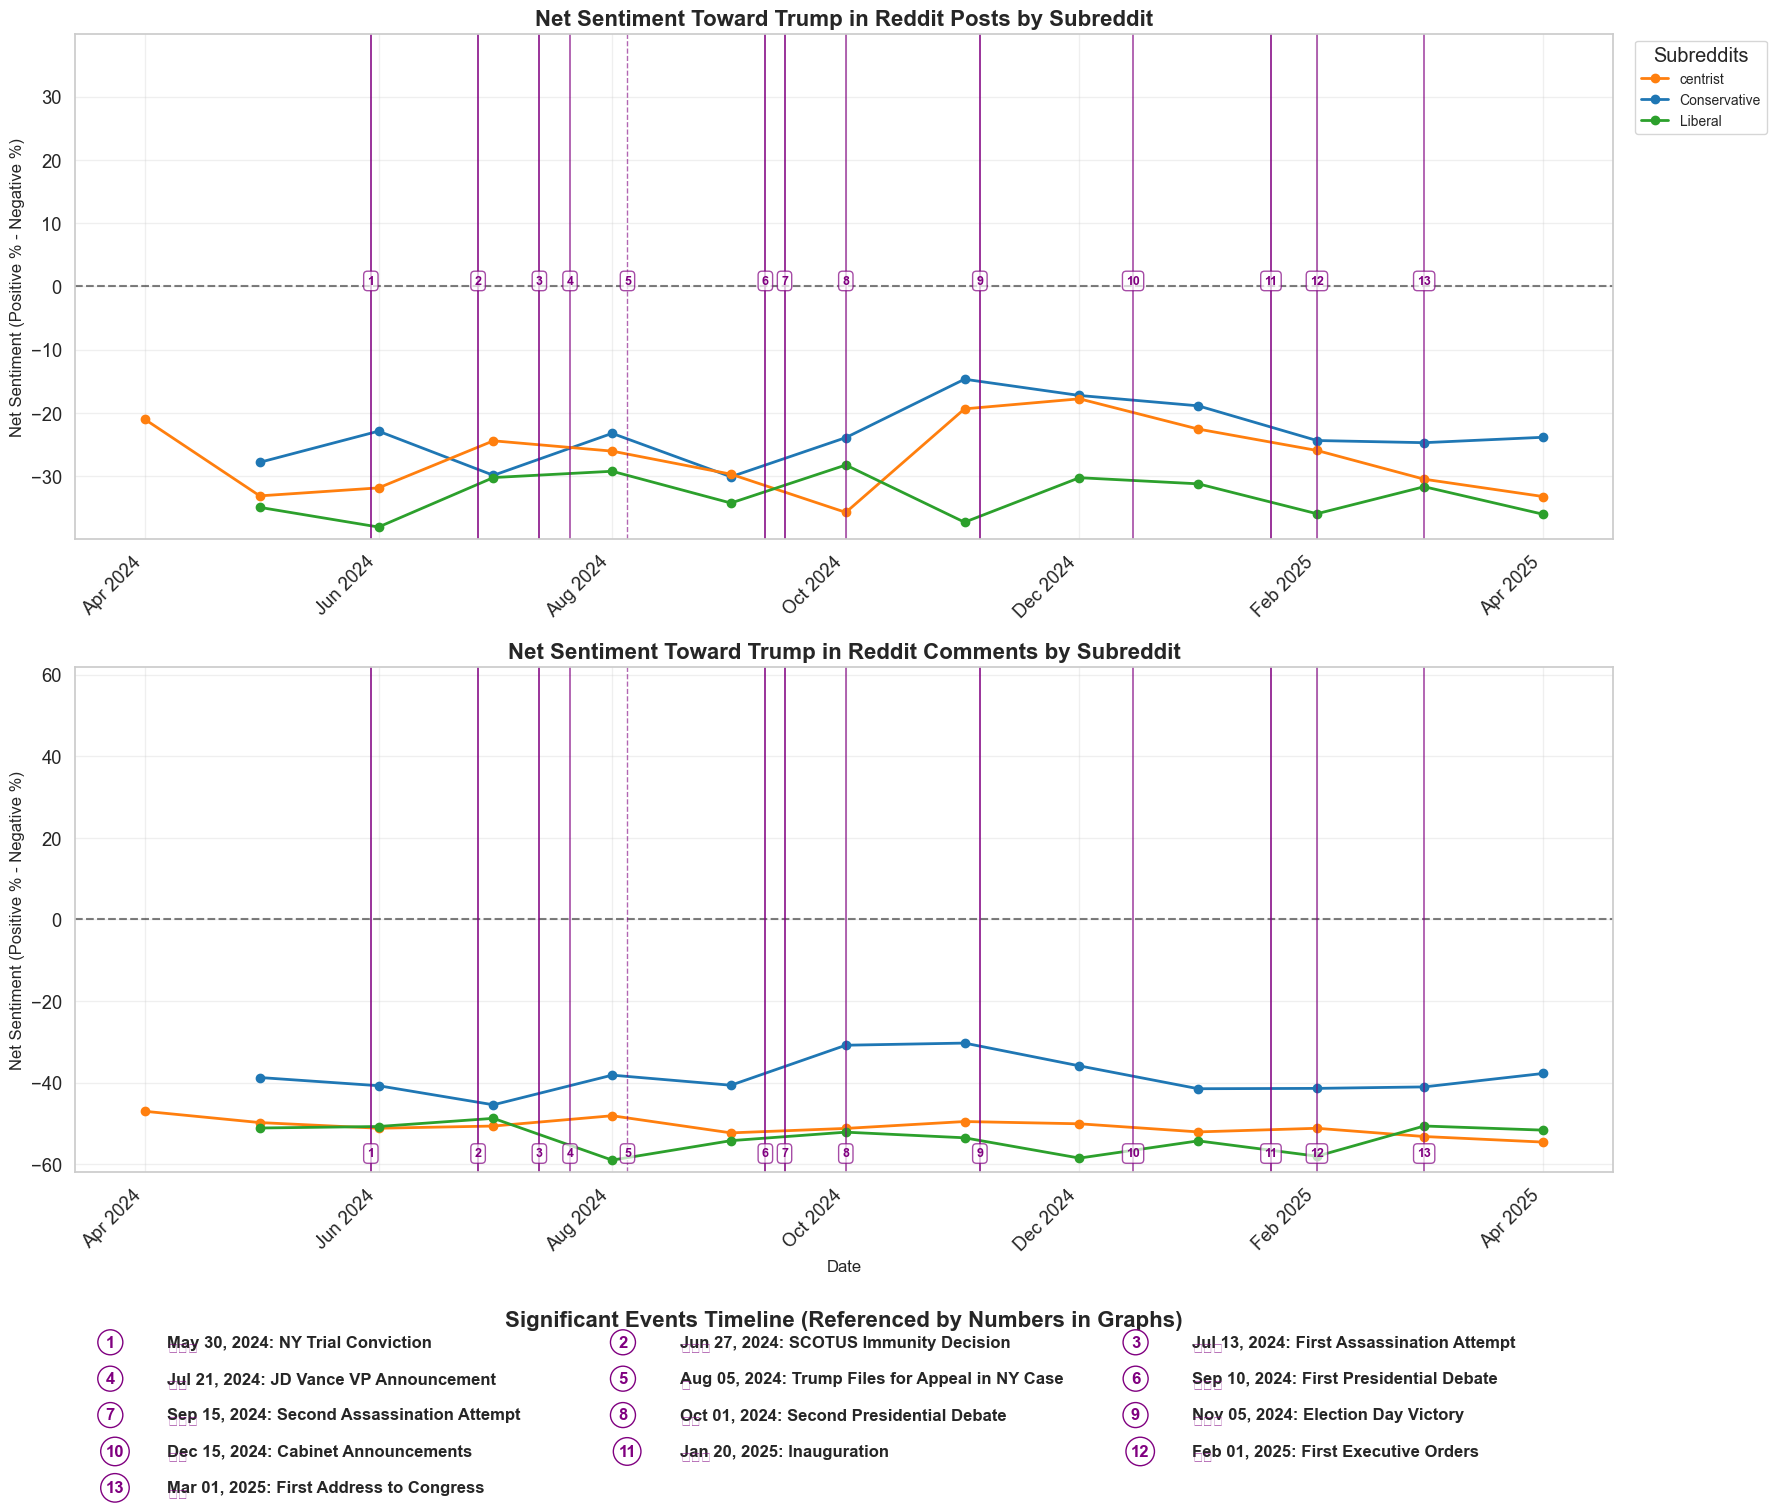

In [126]:
# Define a list of important events related to Trump
# Format: (date, event_label, importance)
# - importance ranges from 1 (minor) to 3 (major)
trump_events_2024_2025 = [
    ('2024-05-30', 'NY Trial Conviction', 3),
    ('2024-06-27', 'SCOTUS Immunity Decision', 3),
    ('2024-07-13', 'First Assassination Attempt', 3),
    ('2024-07-21', 'JD Vance VP Announcement', 2),
    ('2024-08-05', 'Trump Files for Appeal in NY Case', 1),
    ('2024-09-10', 'First Presidential Debate', 3),
    ('2024-09-15', 'Second Assassination Attempt', 3),
    ('2024-10-01', 'Second Presidential Debate', 2),
    ('2024-11-05', 'Election Day Victory', 3),
    ('2024-12-15', 'Cabinet Announcements', 2),
    ('2025-01-20', 'Inauguration', 3),
    ('2025-02-01', 'First Executive Orders', 2),
    ('2025-03-01', 'First Address to Congress', 2)
]

# Call the function with your data and events
sentiment_trends = plot_sentiment_comparison_graphs_with_events(
    trump_posts_df,              # Posts DataFrame
    trump_comments_df,           # Comments DataFrame
    'title_processed_',          # Prefix for posts sentiment columns
    'body_processed_',           # Prefix for comments sentiment columns
    trump_events_2024_2025,                # List of events to annotate
    time_interval='M',           # Monthly intervals
    min_posts=10,                # Minimum posts per time period
    min_comments=20,             # Minimum comments per time period
    top_n=6                      # Number of top subreddits to include
)